# Higgs Analysis:

>This notebook contains work performed on coffea-casa cloud server. 
> Work in progress

In [189]:
from datetime import datetime
import pytz

ist = pytz.timezone('Asia/Kolkata')

print(f"Last modified: {datetime.now(ist).strftime('%d %B %Y, %H:%M')} IST")


Last modified: 05 January 2026, 03:26 IST


# Imports 

In [190]:
import os
import sys
import time
import gc
import psutil
import json
from pathlib import Path

# Data processing
import uproot
import awkward as ak
import numpy as np

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
# import mplhep as hep

# Numerical computing
import vector
import hist
from hist import Hist
from tqdm import tqdm

# Parallel processing 
import dask
from dask import delayed, compute
from dask.distributed import Client, LocalCluster
import dask.bag as db
import dask_awkward as dak
from dask.diagnostics import ProgressBar

# others
!pip install prettytable
from prettytable import PrettyTable

vector.register_awkward()

print(" All imports loaded")

 All imports loaded


# All Directories and path

In [285]:
# BASE PATHS
HOME_DIR = Path(os.environ.get("HOME", "/home/cms-jovyan"))
PROJECT_NAME = "H-to-WW-NanoAOD-analysis"

 
# DERIVED PATHS
PROJECT_DIR = HOME_DIR / PROJECT_NAME
DATASETS_DIR = PROJECT_DIR / "Datasets"
DATA_DIR = DATASETS_DIR / "DATA"
MC_DIR = DATASETS_DIR / "MC_samples"
AUX_DIR = PROJECT_DIR / "Auxillary_files"
OUTPUT_DIR = PROJECT_DIR / "Plots" / "stacked"

 
# JSON FILES
GOLDEN_JSON_PATH = AUX_DIR / "Cert_271036-284044_13TeV_Legacy2016_Collisions16_JSON.txt"

 
# RUN PERIODS
RUN_PERIODS_2016 = {
    'Run2016G': {'run_min': 278820, 'run_max': 280385},
    'Run2016H': {'run_min': 280919, 'run_max': 284044}
}

 
# PRINT CONFIGURATION
 
print(f"HOME_DIR:         {HOME_DIR}")
print(f"PROJECT_DIR:     {PROJECT_DIR}")
print(f"DATA_DIR:        {DATA_DIR}")
print(f"MC_DIR:          {MC_DIR}")
print(f"AUX_DIR:         {AUX_DIR}")
print(f"OUTPUT_DIR:      {OUTPUT_DIR}")
print(f"GOLDEN_JSON:      {GOLDEN_JSON_PATH}")
print(f"JSON exists:     {GOLDEN_JSON_PATH.exists()}")

HOME_DIR:         /home/cms-jovyan
PROJECT_DIR:     /home/cms-jovyan/H-to-WW-NanoAOD-analysis
DATA_DIR:        /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Datasets/DATA
MC_DIR:          /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Datasets/MC_samples
AUX_DIR:         /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Auxillary_files
OUTPUT_DIR:      /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/stacked
GOLDEN_JSON:      /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Auxillary_files/Cert_271036-284044_13TeV_Legacy2016_Collisions16_JSON.txt
JSON exists:     True


In [194]:
N_WORKERS = 20

# Sample mapping 
SAMPLE_MAPPING = {
    'data': 'Data',
    'higgs':  'ggH_HWW',
    'dytoll': 'DY_to_Tau_Tau',
    'top': 'Top_antitop',
    'fakes': 'Fakes',
    'vz': 'Diboson',
    'ggww':  'ggWW',
    'ww': 'WW',
    'vg': 'VG'
}

def load_urls_from_file(filepath, max_files=None):
    """Load XRootD URLs from text file"""
    urls = []
    if not os.path.exists(filepath):
        return urls
    
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if line and line.startswith('root://'):
                urls.append(line)
                if max_files and len(urls) >= max_files:
                    break
    return urls



def load_all_files(data_dir, mc_dir, max_per_sample=None):
    """Load all file URLs from directories"""
    
    files_dict = {}
    
    for directory in [data_dir, mc_dir]:
        if not os.path.exists(directory):
            continue
            
        for filename in os.listdir(directory):
            if not filename.endswith(('.txt')):
                continue
                
            filepath = os.path.join(directory, filename)
            filename_lower = filename.lower().replace('.txt', '')
            
            # Find label
            label = None
            for pattern, sample_label in SAMPLE_MAPPING.items():
                if pattern in filename_lower:
                    label = sample_label
                    break
            
            if not label:
                print(f"   Unknown file: {filename} - skipping")
                continue
            
            # Load URLs
            urls = load_urls_from_file(filepath, max_per_sample)
            
            if urls:
                if label in files_dict:
                    files_dict[label].extend(urls)
                else:
                    files_dict[label] = urls
    
    return files_dict


# files = load_all_files(DATA_DIR, MC_DIR, max_per_sample=10)  # TESTING
files = load_all_files(DATA_DIR, MC_DIR)  # FULL 

print("\n" + "="*70)
print("FILES TO PROCESS")
print("="*70)
total = 0
for label, urls in files.items():
    print(f"{label:20s}: {len(urls):4d} files")
    total += len(urls)
print("_"*70)
print(f"{'TOTAL':20s}: {total:4d} files")
print("="*70)



FILES TO PROCESS
Data                :   48 files
VG                  :   32 files
ggH_HWW             :   40 files
WW                  :    7 files
Fakes               :  206 files
Diboson             :   73 files
DY_to_Tau_Tau       :   61 files
ggWW                :  112 files
Top_antitop         :  197 files
______________________________________________________________________
TOTAL               :  776 files


In [246]:
SAMPLES = {
    "Fakes":          {"color": "#B3B3B3", "is_signal": False, "stack_order": 1},
    
    "VG":             {"color": "#FFCC00", "is_signal": False, "stack_order": 2},
    "Diboson":        {"color": "#A6CEE3", "is_signal": False, "stack_order": 3},
    
    "DY_to_Tau_Tau":  {"color": "#33A02C", "is_signal": False, "stack_order": 4},
    "Top_antitop":    {"color": "#FF7F00", "is_signal": False, "stack_order": 5},
    
    "ggWW":           {"color": "#6BAED6", "is_signal": False, "stack_order": 6},
    "WW":             {"color": "#1F78B4", "is_signal": False, "stack_order": 7},
    
    "ggH_HWW":        {"color": "#E41A1C", "is_signal": True,  "stack_order": 8},
    
    "Data":           {"color": "#000000", "is_signal": False, "stack_order": -1},
}

# Helper dictionaries
colour = {name: props["color"] for name, props in SAMPLES.items()}
stack_order = {name: props["stack_order"] for name, props in SAMPLES.items() if props["stack_order"] >= 0}

In [247]:
colour

{'Fakes': '#B3B3B3',
 'VG': '#FFCC00',
 'Diboson': '#A6CEE3',
 'DY_to_Tau_Tau': '#33A02C',
 'Top_antitop': '#FF7F00',
 'ggWW': '#6BAED6',
 'WW': '#1F78B4',
 'ggH_HWW': '#E41A1C',
 'Data': '#000000'}

In [248]:
stack_order

{'Fakes': 1,
 'VG': 2,
 'Diboson': 3,
 'DY_to_Tau_Tau': 4,
 'Top_antitop': 5,
 'ggWW': 6,
 'WW': 7,
 'ggH_HWW': 8}

# JSON validation functions

In [193]:
def load_golden_json(json_path, run_periods=None):
    
    with open(json_path, 'r') as f:
        golden_json = json.load(f)
    
    valid_lumis = {}
    for run_str, lumi_ranges in golden_json.items():
        run = int(run_str)
        
        # Filter by run periods 
        if run_periods is not None:
            in_period = any(
                period['run_min'] <= run <= period['run_max']
                for period in run_periods.values()
            )
            if not in_period:
                continue
        
        valid_lumis[run] = [tuple(lr) for lr in lumi_ranges]
    
    return valid_lumis


def apply_json_mask(arrays, json_path, run_periods=None):
    """
    Apply golden JSON mask to select certified luminosity sections.
    """
    valid_lumis = load_golden_json(json_path, run_periods)
    
    runs = ak.to_numpy(arrays.run)
    lumis = ak.to_numpy(arrays.luminosityBlock)
    
    mask = np.zeros(len(runs), dtype=bool)
    

    for run, lumi_ranges in valid_lumis.items():
        run_mask = (runs == run)
        
     
        if not np.any(run_mask):
            continue
        
        # Check lumi sections 
        run_lumis = lumis[run_mask]
        run_lumi_mask = np.zeros(len(run_lumis), dtype=bool)
        
        for lumi_start, lumi_end in lumi_ranges:
            run_lumi_mask |= (run_lumis >= lumi_start) & (run_lumis <= lumi_end)
        
        mask[run_mask] = run_lumi_mask
    
    return ak.Array(mask)

# Loading branches to use 

In [198]:
Batch_size = 50_000
def load_events(file_url, batch_size=50_000, timeout=600, max_retries=3, retry_wait=10, is_data = False):

    
    columns = [
        "Electron_pt", "Electron_eta", "Electron_phi", "Electron_mass", 
        "Electron_mvaFall17V2Iso_WP90", "Electron_charge",
        
        "Muon_pt", "Muon_eta", "Muon_phi", "Muon_mass", 
        "Muon_tightId", "Muon_charge", "Muon_pfRelIso04_all",
        "MET_pt", "MET_phi",
        
        "Jet_pt", "Jet_eta", "Jet_phi", "Jet_mass",
        "Jet_btagDeepFlavB", "nJet", "Jet_jetId", "Jet_puId",
    ]

    if is_data:
        columns.extend(["run","luminosityBlock"])
    else: columns.append("genWeight")
        
    for attempt in range(max_retries):
        try:
            
            with uproot.open(file_url, timeout=timeout, num_workers=1) as f:
                tree = f['Events']
                
                
                for arrays in tree.iterate(columns, step_size=batch_size, library="ak"):
                    yield arrays
                
               
                return
                
        except (TimeoutError, OSError, IOError, ConnectionError) as e:
            error_type = type(e).__name__
            file_name = file_url.split('/')[-1]
            
            if attempt < max_retries - 1:
                print(f"      {error_type} on {file_name}")
                print(f"       Retry {attempt+1}/{max_retries-1} in {retry_wait}s...")
                time.sleep(retry_wait)
            else:
                print(f"     FAILED after {max_retries} attempts: {file_name}")
                print(f"       Error: {str(e)[:100]}")
                raise
                
        except Exception as e:
            
            file_name = file_url.split('/')[-1]
            print(f"     Unexpected error on {file_name}: {str(e)[:100]}")
            raise


# Helper functions

In [199]:
# %%
def wrap_angle_to_pi(angle):
    """More concise way to wrap angle to [-π, π] range"""
    return (angle + np.pi) % (2 * np.pi) - np.pi

def create_lepton_vector(lepton):
    """Create 4-vector from lepton properties - unified function"""
    return vector.array({
        "pt": lepton.pt,
        "eta": lepton.eta,
        "phi": lepton.phi,
        "mass": lepton.mass
    })

# Event Selection

## Selecting tight leptons (Electrons and Muon)

In [200]:

# %%
def select_tight_leptons(arrays):
    """Apply tight ID and isolation cuts to leptons"""
    # Define selection masks
    tight_electron_mask = arrays.Electron_mvaFall17V2Iso_WP90 == 1
    tight_muon_mask = (arrays.Muon_tightId == 1) & (arrays.Muon_pfRelIso04_all < 0.15)
    
    # Create structured arrays for selected leptons
    tight_electrons = ak.zip({
        "pt": arrays.Electron_pt[tight_electron_mask],
        "eta": arrays.Electron_eta[tight_electron_mask],
        "phi": arrays.Electron_phi[tight_electron_mask],
        "mass": arrays.Electron_mass[tight_electron_mask],
        "charge": arrays.Electron_charge[tight_electron_mask],
        "flavor": ak.ones_like(arrays.Electron_pt[tight_electron_mask]) * 11
    })
    
    tight_muons = ak.zip({
        "pt": arrays.Muon_pt[tight_muon_mask],
        "eta": arrays.Muon_eta[tight_muon_mask],
        "phi": arrays.Muon_phi[tight_muon_mask],
        "mass": arrays.Muon_mass[tight_muon_mask],
        "charge": arrays.Muon_charge[tight_muon_mask],
        "flavor": ak.ones_like(arrays.Muon_pt[tight_muon_mask]) * 13
    })
    
    # Combine into single collection
    tight_leptons = ak.concatenate([tight_electrons, tight_muons], axis=1)
    
    return tight_leptons, tight_electron_mask, tight_muon_mask

## Selecting Electron and Muon candidates

In [201]:
def select_e_mu_events(tight_leptons, met_arrays, leading_pt_cut=25, subleading_pt_cut=15):
    """Select events with exactly 1 electron and 1 muon"""
    
    # Sort by pT
    sorted_leptons = tight_leptons[ak.argsort(tight_leptons.pt, ascending=False)]
    
    # Require at least 2 leptons
    mask_2lep = ak.num(sorted_leptons) == 2
    events_2lep = sorted_leptons[mask_2lep]
    met_2lep = met_arrays[mask_2lep]
    
    if len(events_2lep) == 0:
        return None, None, {}, None
    
    # Get leading and subleading
    leading = events_2lep[:, 0]
    subleading = events_2lep[:, 1]
    
    # Selection criteria
    mask_1e1mu = ((leading.flavor == 11) & (subleading.flavor == 13)) | \
                 ((leading.flavor == 13) & (subleading.flavor == 11))
    mask_opposite_charge = leading.charge * subleading.charge < 0
    mask_pt = (leading.pt > leading_pt_cut) & (subleading.pt > subleading_pt_cut)
    
    # Final selection
    final_mask = mask_1e1mu & mask_opposite_charge & mask_pt
    
    # Store cutflow information
    cutflow = {
        'events_2lep': len(leading),
        'events_1e1mu': ak.sum(mask_1e1mu),
        'events_opposite_charge': ak.sum(mask_1e1mu & mask_opposite_charge),
        'events_final': ak.sum(final_mask)
    }
    
    return leading[final_mask], subleading[final_mask], cutflow, met_2lep[final_mask]


## Counting jets and 0/1/2 Jet categorisation

In [202]:
def count_jets(arrays, jet_pt_threshold=30, tight_leptons=None):

    # Step 1: Create Jet object from individual arrays
    jets = ak.zip({
        "pt": arrays.Jet_pt,
        "eta": arrays. Jet_eta,
        "phi": arrays.Jet_phi,
        "mass": arrays. Jet_mass,
        "jetId": arrays.Jet_jetId,
        "btagDeepFlavB": arrays. Jet_btagDeepFlavB,
        "puId": arrays.Jet_puId 
    })
    
    # Step 2: Good jet selection
    pu_id_mask = (jets.pt > 50) | ((jets.pt <= 50) & (jets.puId >= 4))
    good_mask = (jets.jetId >= 2) & (abs(jets.eta) < 4.7) & pu_id_mask
    
    # Step 3: Lepton cleaning
    if tight_leptons is not None and ak.max(ak.num(tight_leptons)) > 0:
        # Delta R calculation
        jets_eta = jets. eta[:, :, None]
        jets_phi = jets.phi[:, :, None]
        leps_eta = tight_leptons.eta[:, None, :]
        leps_phi = tight_leptons.phi[:, None, :]
        
        deta = jets_eta - leps_eta
        dphi = (jets_phi - leps_phi + np.pi) % (2 * np.pi) - np.pi
        dr = np.sqrt(deta**2 + dphi**2)
        
        min_dr = ak.min(dr, axis=-1)
        
        min_dr = ak.fill_none(min_dr, 999.0)
        good_mask = good_mask & (min_dr > 0.4)
    
    good_jets = jets[good_mask]
    
    # Step 4: Sort by pT
    sorted_jets = good_jets[ak.argsort(good_jets.pt, axis=1, ascending=False)]
    
    lead_jet_pt = ak.fill_none(ak.firsts(sorted_jets.pt), 0)
    sublead_jet_pt = ak.fill_none(ak.firsts(sorted_jets[:, 1:].pt), 0)
    
    # Step 5: Category masks based on jet count
    isZeroJet = (lead_jet_pt < jet_pt_threshold)
    isOneJet = (lead_jet_pt >= jet_pt_threshold) & (sublead_jet_pt < jet_pt_threshold)
    isTwoJet = (sublead_jet_pt >= jet_pt_threshold)
    
    n_jets = ak.sum(sorted_jets. pt >= jet_pt_threshold, axis=1)
    
    return n_jets, good_mask, sorted_jets, isZeroJet, isOneJet, isTwoJet

## bjet categorization

In [203]:
def get_bjet_categories(arrays, btag_threshold=0.2217, eta_max=2.5):
    """
    Get different b-jet categories needed for SR/CR selection.
    """
    # Base b-jet selection 
    base_bjet_mask = (
        (arrays.Jet_jetId >= 2) &
        (abs(arrays.Jet_eta) < eta_max) &
        (arrays.Jet_btagDeepFlavB > btag_threshold)
    )
    
    # Different pT categories
    bjets_20 = base_bjet_mask & (arrays.Jet_pt > 20)
    bjets_20_30 = base_bjet_mask & (arrays.Jet_pt > 20) & (arrays.Jet_pt <= 30)
    bjets_30 = base_bjet_mask & (arrays.Jet_pt > 30)
    
    # Count per event
    n_bjets_20 = ak.sum(bjets_20, axis=1)
    n_bjets_20_30 = ak.sum(bjets_20_30, axis=1) 
    n_bjets_30 = ak.sum(bjets_30, axis=1)
    
    return {
        # For Signal Regions 
        'passes_bjet_veto': n_bjets_20 == 0,  
        
        # For Control Regions
        'has_btag_20_30': n_bjets_20_30 > 0,  # Top CR 0-jet
        'has_btag_30': n_bjets_30 > 0,        # Top CR 1-jet, 2-jet
        
        # Counts
        'n_bjets_20': n_bjets_20,
        'n_bjets_20_30': n_bjets_20_30,
        'n_bjets_30': n_bjets_30
    }


def apply_bjet_selections(arrays):
   
    bjet_info = get_bjet_categories(arrays)
    
    # For Signal Regions
    sr_bjet_veto = bjet_info['passes_bjet_veto']
    
    # For Control Regions
    cr_top_0jet = bjet_info['has_btag_20_30']
    cr_top_1jet_2jet = bjet_info['has_btag_30']
    
    return sr_bjet_veto, bjet_info

## Signal regions

In [204]:
def apply_signal_region_cuts(leading, subleading, met, masses, ptlls, mt_higgs, 
                           mt_l2_met, isZeroJet, isOneJet, isTwoJet, 
                           bjet_veto_mask, mjj=None):
    """Apply Signal Region selections for all jet categories."""
    
    # Base global selection for Signal Regions
    sr_base = (
        (leading.pt > 25) & 
        (subleading.pt > 15) &  
        (met.pt > 20) &
        (ptlls > 30) &
        (masses > 12) &
        (mt_l2_met > 30) &
        (subleading.pt <= 20) &  
        (mt_higgs > 60) &        
        bjet_veto_mask           
    )
    
    # Apply mjj window for 2-jet category
    if mjj is not None:
        mjj_window = apply_mjj_window(mjj)
    else:
        mjj_window = ak.ones_like(isTwoJet, dtype=bool)
    
    sr_regions = {
        'SR_0jet': sr_base & isZeroJet,
        'SR_1jet': sr_base & isOneJet,
        'SR_2jet': sr_base & isTwoJet & mjj_window
    }
    
    return sr_regions


## control region

In [205]:
def apply_control_region_cuts(leading, subleading, met, masses, ptlls, mt_higgs, 
                            mt_l2_met, isZeroJet, isOneJet, isTwoJet, 
                            bjet_info, mjj=None):
    """Apply Control Region selections for all jet categories."""
    
    # Base global selection for Control Regions
    cr_base = (
        (leading.pt > 25) & 
        (subleading.pt > 15) &
        (met.pt > 20) &
        (ptlls > 30) &
        (masses > 12) &
        (mt_l2_met > 30) &
        (subleading.pt <= 20)
    )
    
    # Apply mjj window for 2-jet category
    if mjj is not None:
        mjj_window = apply_mjj_window(mjj)
    else:
        mjj_window = ak.ones_like(isTwoJet, dtype=bool)
    
    cr_regions = {}
    
    # === TOP CONTROL REGIONS ===
    cr_top_base = cr_base & (masses > 50)
    
    cr_regions['CR_top_0jet'] = (
        cr_top_base & 
        isZeroJet & 
        bjet_info['has_btag_20_30']  # 20 < pT < 30 GeV b-jets for 0-jet
    )
    
    cr_regions['CR_top_1jet'] = (
        cr_top_base & 
        isOneJet & 
        bjet_info['has_btag_30']     # pT > 30 GeV b-jets for 1-jet
    )
    
    cr_regions['CR_top_2jet'] = (
        cr_top_base & 
        isTwoJet & 
        mjj_window &
        bjet_info['has_btag_30']     # pT > 30 GeV b-jets for 2-jet
    )
    
    # === TAU-TAU CONTROL REGIONS ===
    cr_tau_base = (
        cr_base & 
        (mt_higgs < 60) & 
        (masses > 40) & 
        (masses < 80) &
        bjet_info['passes_bjet_veto']  
    )
    
    cr_regions['CR_tau_0jet'] = cr_tau_base & isZeroJet
    cr_regions['CR_tau_1jet'] = cr_tau_base & isOneJet  
    cr_regions['CR_tau_2jet'] = cr_tau_base & isTwoJet & mjj_window
    
    return cr_regions

## Global Cuts

In [206]:
def apply_global_cuts(leading, subleading, met, mt_higgs, mt_l2_met,ptlls,masses):
    """Apply global selection cuts"""
    # Global cuts
    mask_subleading_pt = subleading.pt >= 15 
    mask_mt_higgs = mt_higgs > 60
    mask_mt_l2_met = mt_l2_met > 30
    mask_met_pt = met.pt > 20
    mask_ptll  = ptlls > 30
    mask_mll = masses > 12 
    
    # Combine all masks
    global_mask = mask_mt_higgs & mask_mt_l2_met & mask_subleading_pt & mask_met_pt & mask_ptll & mask_mll

    return global_mask, {
        'pass_mt_higgs': ak.sum(mask_mt_higgs),
        'pass_mt_l2_met': ak.sum(mask_mt_l2_met),
        'pass_subleading_pt': ak.sum(mask_subleading_pt),
        'pass_met_pt': ak.sum(mask_met_pt),
        'pass_ptll': ak.sum(mask_ptll),
        'pass_mll': ak.sum(mask_mll),
        'pass_global': ak.sum(global_mask)
    }

---
# Calculations 

## Calculating  kinematic variables 
- Invariant mass of dilepton(electron and muon) system
- Transverse momentum of dilepton system
- Azimuathal seperation between dileptons
- Transverse mass of Higgs
- Transvers mass of subleading lepton and $E^T_{miss}$ 
  

In [207]:
def cal_kinematic_var(leading, subleading, met):

    lepton_1 = create_lepton_vector(leading)
    lepton_2 = create_lepton_vector(subleading)


    dilepton = lepton_1 + lepton_2

    masses = dilepton.mass
    ptll = dilepton.pt
    dphi = wrap_angle_to_pi(leading.phi - subleading.phi)


    mt_higgs_dphi = wrap_angle_to_pi(dilepton.phi - met.phi)
    mt_higgs = np.sqrt(2 * dilepton.pt * met.pt * (1 - np.cos(mt_higgs_dphi)))

    mt_l2_met_dphi = wrap_angle_to_pi(subleading.phi - met.phi)
    mt_l2_met = np.sqrt(2 * subleading.pt * met.pt * (1 - np.cos(mt_l2_met_dphi)))


    return masses, ptll, dphi, mt_higgs, mt_l2_met


## Calculating Invriant mass of jets and applying $m_{jj}$

In [208]:
def calculate_mjj(jets):
    """Calculate invariant mass of the two leading jets.
    
    Assumes jets are already sorted by pT (descending).
    Returns 0 for events with < 2 jets.
    """
    # Get number of jets per event
    n_jets = ak.num(jets)
    
    # Initialize mjj with zeros for all events
    mjj = ak.zeros_like(n_jets, dtype=float)
    
    # Create mask for events with at least 2 jets
    has_two_jets = n_jets >= 2
    
    # Only proceed if there are events with 2+ jets
    if ak.any(has_two_jets):
        # Use padding to safely access indices
        jets_padded = ak.pad_none(jets, 2, axis=1)
        
        # Create 4-vectors for jets
        jet_vectors = ak.zip({
            "pt": ak.fill_none(jets_padded.pt, 0.0),
            "eta": ak.fill_none(jets_padded.eta, 0.0),
            "phi": ak.fill_none(jets_padded.phi, 0.0),
            "mass": ak.fill_none(jets_padded.mass, 0.0)
        }, with_name="Momentum4D")
        
        # Get first two jets
        jet1 = jet_vectors[:, 0]
        jet2 = jet_vectors[:, 1]
        
        # Calculate invariant mass using vector addition
        dijet = jet1 + jet2
        mjj_calculated = dijet.mass
        
        # Apply only where we have 2+ jets
        mjj = ak.where(has_two_jets, mjj_calculated, 0.0)
    
    return mjj

def apply_mjj_window(mjj):
    return (mjj < 65) | ((mjj > 105) & (mjj < 120))

# Histogram Initialization

In [265]:
variables_to_plots = {
        'mass': hist.axis.Regular(10, 0, 200, name="mass", label="m_ll [GeV]"),
        'met': hist.axis.Regular(10, 0, 200, name="met", label="MET [GeV]"),
        'dphi': hist.axis.Regular(10, 0, np.pi, name="dphi", label="dphi(l,l)"),
        'ptll': hist.axis.Regular(10, 0, 200, name="ptll", label="p_T^ll [GeV]"),
        'mt_higgs': hist.axis.Regular(10, 0, 300, name="mt_higgs", label="m_T^H [GeV]"),
        'mt_l2_met': hist.axis.Regular(10, 0, 200, name="mt_l2_met", label="m_T(l2,MET) [GeV]"),
        'mjj': hist.axis.Regular(10, 0, 500, name="mjj", label="m_jj [GeV]"),
        'leading_pt': hist.axis.Regular(10, 0, 200, name="leading_pt", label="Leading lepton p_T [GeV]"),
        'subleading_pt': hist.axis.Regular(10, 0, 200, name="subleading_pt", label="Subleading lepton p_T [GeV]"),
    }
stage_names = [
        'before_cuts', 'global', '0jet', '1jet', '2jet',
        'SR_0jet', 'SR_1jet', 'SR_2jet',
        'CR_top_0jet', 'CR_top_1jet', 'CR_top_2jet',
        'CR_tau_0jet', 'CR_tau_1jet', 'CR_tau_2jet'
    ]

def initialize_stage_histograms():
    """Initialize histograms for all selection stages"""
    
    stage_histograms = {}
    for stage in stage_names:
        stage_histograms[stage] = {
            var_name: Hist(axis) for var_name, axis in variables_to_plots.items()
        }
    
    return stage_histograms

# Initialize for all samples
hist_data = {}
for label in ['Data', 'ggH_HWW', 'DY_to_Tau_Tau', 'Top_antitop', 'Fakes', 
              'Diboson', 'ggWW', 'WW', 'VG']:
    hist_data[label] = initialize_stage_histograms()

print("Histogram storage initialized")

Histogram storage initialized


# Add Sample mapping & xsec weight calculator

In [210]:
# Sample information
sample_info = {
    "Higgs": {"xsec": 1.0315, "sum_genWeight": 63_281_828.0},
    "DYtoLL": {"xsec": 6189.39, "sum_genWeight": 82_448_512.0},
    "Top": {"xsec": 232.58, "sum_genWeight": 11_433_399_296.0},
    "Fakes": {"xsec": 61_891.05, "sum_genWeight": 9_740_958_564_352.0},
    "VZ": {"xsec": 26.54765, "sum_genWeight": 134_985_184.0},
    "ggWW": {"xsec": 5.7483, "sum_genWeight": 17_662_000.0},
    "WW": {"xsec": 12.178, "sum_genWeight": 32_147_096.0},
    "VG": {"xsec": 464.101, "sum_genWeight": 3_109_819_392.0}
}

# Luminosity in pb^-1
Luminosity_pb = 16_393  # 1 fb^-1 = 1,000 pb^-1

# Map your sample labels to process names
SAMPLE_TO_PROCESS = {
    'ggH_HWW': 'Higgs',
    'DY_to_Tau_Tau': 'DYtoLL',
    'Top_antitop': 'Top',
    'Fakes': 'Fakes',
    'Diboson': 'VZ',
    'ggWW': 'ggWW',
    'WW': 'WW',
    'VG': 'VG',
    'Data': None 
}

def calculate_event_weights(genWeight, process_name):
    """
    Calculate per-event weights using formula:
    weight = (xsec × L × genWeight) / sum_genWeight
    
    Parameters:
    - genWeight: awkward array of per-event generator weights
    - process_name: process name (e.g., 'Higgs', 'WW')
    
    Returns:
    - event_weights: scaled weights for luminosity
    """
    if process_name is None:  # Data
        return ak.ones_like(genWeight)
    
    info = sample_info[process_name]
    xsec = info['xsec']
    sum_genWeight = info['sum_genWeight']
    
    # Formula: (xsec × L × genWeight) / sum_genWeight
    event_weights = (xsec * Luminosity_pb * genWeight) / sum_genWeight
    
    return event_weights

print("Sample info and weight calculator loaded")

Sample info and weight calculator loaded


# Processing

## Processing function

In [211]:
def processing_file(label, file_url, file_idx, json_path=None):
   
    file_name = file_url.split('/')[-1]
   
    is_data = (label == 'Data')
    process_name = SAMPLE_TO_PROCESS.get(label, None)

    empty_cutflow = {stage: 0 for stage in [
        'total','after_json', 'e_mu_preselection', 'global_cuts',
        '0jet', '1jet', '2jet',
        'SR_0jet', 'SR_1jet', 'SR_2jet',
        'CR_top_0jet', 'CR_top_1jet', 'CR_top_2jet',
        'CR_tau_0jet', 'CR_tau_1jet', 'CR_tau_2jet'
    ]}
    
    try:
        stage_histograms = initialize_stage_histograms()
        cutflow = empty_cutflow.copy()
        weighted_cutflow = empty_cutflow.copy()
        
        max_file_retries = 3
        
        for file_attempt in range(max_file_retries):
            try:
                batch_count = 0
                for arrays in load_events(
                    file_url,
                    batch_size=50_000,
                    # timeout=XROOTD_TIMEOUT,
                    # max_retries=XROOTD_MAX_RETRIES,
                    is_data=is_data
                    # retry_wait=XROOTD_RETRY_WAIT
                ):
                    batch_count += 1
                    
                    batch_start = time.time()
                    cutflow['total'] += len(arrays)

                    # calculate weights
                   
                    if is_data:
                        event_weights = ak.ones_like(arrays.MET_pt)
                    else:
                        event_weights = calculate_event_weights(arrays.genWeight, process_name)
                    
                    
                    weighted_cutflow['total'] += float(ak.sum(event_weights))
                        
                    # apply JSON mask for data
                      
                    if is_data and json_path is not None:
                        json_mask = apply_json_mask(arrays, json_path,run_periods=RUN_PERIODS_2016)
                        n_events_after = ak.sum(json_mask)
                        cutflow['after_json'] += int(n_events_after)
                        weighted_cutflow['after_json'] += float(ak.sum(event_weights[json_mask]))

                        if n_events_after == 0:
                            continue

                        arrays = arrays[json_mask]
                        event_weights = event_weights[json_mask]
                    

                    # Get tight leptons
                      
                    tight_leptons, _, _ = select_tight_leptons(arrays)
                   
                    
                    met = ak.zip({"pt": arrays.MET_pt, "phi": arrays.MET_phi})
                    
                    # Apply e-mu selection
                      
                    leading, subleading, emu_cutflow, met_selected = select_e_mu_events(tight_leptons, met)
                   
                    
                    if leading is None or len(leading) == 0:
                        del arrays, tight_leptons, met, event_weights
                        gc.collect()
                        continue

                    sorted_leptons = tight_leptons[ak.argsort(tight_leptons.pt, ascending=False)]
                    has_2lep = ak.num(sorted_leptons) == 2
                    events_2lep = sorted_leptons[has_2lep]
                    
                    if len(events_2lep) == 0:
                        del arrays, tight_leptons, met, leading, subleading, met_selected
                        gc.collect()
                        continue
                    
                    lead_all = events_2lep[:, 0]
                    sublead_all = events_2lep[:, 1]
                    
                    mask_1e1mu = ((lead_all.flavor == 11) & (sublead_all.flavor == 13)) | \
                                 ((lead_all.flavor == 13) & (sublead_all.flavor == 11))
                    mask_charge = lead_all.charge * sublead_all.charge < 0
                    mask_pt = (lead_all.pt > 25) & (sublead_all.pt > 15)
                    
                    emu_mask_2lep = mask_1e1mu & mask_charge & mask_pt
                    
                    indices_2lep = ak.where(has_2lep)[0]
                    indices_selected = ak.to_numpy(indices_2lep[emu_mask_2lep])
                    
                    emu_mask_full = np.zeros(len(has_2lep), dtype=bool)
                    emu_mask_full[indices_selected] = True
                    emu_mask_full = ak.Array(emu_mask_full)
                    
                    # Apply mask to weights
                    event_weights = event_weights[emu_mask_full]
                    
                    cutflow['e_mu_preselection'] += len(leading)
                    weighted_cutflow['e_mu_preselection'] += float(ak.sum(event_weights))
                    
                    # Calculate kinematic variables
                      
                    masses, ptlls, dphis, mt_higgs, mt_l2_met = cal_kinematic_var(
                        leading, subleading, met_selected
                    )
                    
                    
                    mjj_before = ak.zeros_like(masses)
                    
                    # Fill before_cuts histograms 
                      
                    weights_np = ak.to_numpy(event_weights)
                    masses_np = ak.to_numpy(masses)
                    met_np = ak.to_numpy(met_selected.pt)
                    dphis_np = ak.to_numpy(dphis)
                    ptlls_np = ak.to_numpy(ptlls)
                    mt_higgs_np = ak.to_numpy(mt_higgs)
                    mt_l2_met_np = ak.to_numpy(mt_l2_met)
                    mjj_before_np = ak.to_numpy(mjj_before)
                    leading_pt_np = ak.to_numpy(leading.pt)
                    subleading_pt_np = ak.to_numpy(subleading.pt)
                    
                    stage_histograms['before_cuts']['mass'].fill(masses_np, weight=weights_np)
                    stage_histograms['before_cuts']['met'].fill(met_np, weight=weights_np)
                    stage_histograms['before_cuts']['dphi'].fill(dphis_np, weight=weights_np)
                    stage_histograms['before_cuts']['ptll'].fill(ptlls_np, weight=weights_np)
                    stage_histograms['before_cuts']['mt_higgs'].fill(mt_higgs_np, weight=weights_np)
                    stage_histograms['before_cuts']['mt_l2_met'].fill(mt_l2_met_np, weight=weights_np)
                    stage_histograms['before_cuts']['mjj'].fill(mjj_before_np, weight=weights_np)
                    stage_histograms['before_cuts']['leading_pt'].fill(leading_pt_np, weight=weights_np)
                    stage_histograms['before_cuts']['subleading_pt'].fill(subleading_pt_np, weight=weights_np)
                   
                    
                    # Global cuts and jet counting 
                    indices_emu = indices_selected 
                      
                    n_jets_full, _, sorted_jets_full, isZeroJet_full, isOneJet_full, isTwoJet_full = count_jets(
                        arrays, tight_leptons=tight_leptons
                    )
                   
                    
                    mjj_full = calculate_mjj(sorted_jets_full)
                    mjj_selected = mjj_full[indices_emu]
                    mjj_selected = ak.fill_none(mjj_selected, 0.0)
                    
                    global_cut_mask, _ = apply_global_cuts(
                        leading, subleading, met_selected, mt_higgs, mt_l2_met, ptlls, masses
                    )
                    bjet_veto_full, bjet_info_full = apply_bjet_selections(arrays)
                    bjet_veto_selected = bjet_veto_full[indices_emu]
                    bjet_info_selected = {
                        key: value[indices_emu] for key, value in bjet_info_full.items()
                    }
                    
                    global_mask_selected = global_cut_mask & bjet_veto_selected
                    cutflow['global_cuts'] += ak.sum(global_mask_selected)
                    weighted_cutflow['global_cuts'] += float(ak.sum(event_weights[global_mask_selected]))
                    
                    if ak.sum(global_mask_selected) > 0:
                        
                        def fill_histograms(stage_name, mask):
                            if ak.sum(mask) == 0:
                                return
                            
                            weights_masked = ak.to_numpy(event_weights[mask])
                            stage_histograms[stage_name]['mass'].fill(masses_np[ak.to_numpy(mask)], weight=weights_masked)
                            stage_histograms[stage_name]['met'].fill(met_np[ak.to_numpy(mask)], weight=weights_masked)
                            stage_histograms[stage_name]['dphi'].fill(dphis_np[ak.to_numpy(mask)], weight=weights_masked)
                            stage_histograms[stage_name]['ptll'].fill(ptlls_np[ak.to_numpy(mask)], weight=weights_masked)
                            stage_histograms[stage_name]['mt_higgs'].fill(mt_higgs_np[ak.to_numpy(mask)], weight=weights_masked)
                            stage_histograms[stage_name]['mt_l2_met'].fill(mt_l2_met_np[ak.to_numpy(mask)], weight=weights_masked)
                            stage_histograms[stage_name]['mjj'].fill(ak.to_numpy(mjj_selected[mask]), weight=weights_masked)
                            stage_histograms[stage_name]['leading_pt'].fill(leading_pt_np[ak.to_numpy(mask)], weight=weights_masked)
                            stage_histograms[stage_name]['subleading_pt'].fill(subleading_pt_np[ak.to_numpy(mask)], weight=weights_masked)
                        
                        fill_histograms('global', global_mask_selected)
                        
                        isZeroJet_selected = isZeroJet_full[indices_emu]
                        isOneJet_selected = isOneJet_full[indices_emu]
                        isTwoJet_selected = isTwoJet_full[indices_emu]

                        mask_0jet = global_mask_selected & isZeroJet_selected
                        mask_1jet = global_mask_selected & isOneJet_selected
                        mask_2jet = global_mask_selected & isTwoJet_selected

                        cutflow['0jet'] += ak.sum(mask_0jet)
                        cutflow['1jet'] += ak.sum(mask_1jet)
                        cutflow['2jet'] += ak.sum(mask_2jet)
                        
                        weighted_cutflow['0jet'] += float(ak.sum(event_weights[mask_0jet]))
                        weighted_cutflow['1jet'] += float(ak.sum(event_weights[mask_1jet]))
                        weighted_cutflow['2jet'] += float(ak.sum(event_weights[mask_2jet]))

                        fill_histograms('0jet', mask_0jet)
                        fill_histograms('1jet', mask_1jet)
                        fill_histograms('2jet', mask_2jet)
                        
                        # Signal and Control Regions
                        sr_regions = apply_signal_region_cuts(
                            leading, subleading, met_selected, masses, ptlls, mt_higgs,
                            mt_l2_met, isZeroJet_selected, isOneJet_selected, isTwoJet_selected,
                            bjet_veto_selected, mjj_selected
                        )
                        
                        cr_regions = apply_control_region_cuts(
                            leading, subleading, met_selected, masses, ptlls, mt_higgs,
                            mt_l2_met, isZeroJet_selected, isOneJet_selected, isTwoJet_selected,
                            bjet_info_selected, mjj_selected
                        )
                        
                        all_regions = {**sr_regions, **cr_regions}
                        
                        for region_name, region_mask in all_regions.items():
                            cutflow[region_name] += ak.sum(region_mask)
                            weighted_cutflow[region_name] += float(ak.sum(event_weights[region_mask]))
                            fill_histograms(region_name, region_mask)
                    
                    
                    
                    # Clear memory after each batch
                    del arrays, tight_leptons, met, leading, subleading, met_selected
                    del masses, ptlls, dphis, mt_higgs, mt_l2_met
                    del weights_np, masses_np, met_np, dphis_np, ptlls_np
                    del mt_higgs_np, mt_l2_met_np, leading_pt_np, subleading_pt_np
                    gc.collect()
                
                return label, stage_histograms, cutflow, weighted_cutflow, None
                
            except (OSError, IOError, ValueError) as e:
                error_type = type(e).__name__
                if file_attempt < max_file_retries - 1:
                    print(f"  {label}/{file_name}: {error_type} - Retry {file_attempt+1}/{max_file_retries}")
                    time.sleep(5)  
                    gc.collect()
                    continue
                else:
                    error_msg = f"{file_name}: {error_type} after {max_file_retries} attempts - {str(e)[:100]}"
                    print(f" {label}/{file_name}: FAILED")
                    return label, initialize_stage_histograms(), empty_cutflow, empty_cutflow, error_msg
            
            except Exception as e:
                import traceback
                error_msg = f"{file_name}: {type(e).__name__} - {str(e)[:100]}"
                print(f"  {label}/{file_name}: {type(e).__name__}")
                return label, initialize_stage_histograms(), empty_cutflow, empty_cutflow, error_msg
        
        return label, stage_histograms, cutflow, weighted_cutflow, None
        
    except Exception as e:
        import traceback
        error_msg = f"{file_name}: Unexpected error - {traceback.format_exc()[:200]}"
        print(f"  {label}/{file_name}: Critical error")
        return label, initialize_stage_histograms(), empty_cutflow, empty_cutflow, error_msg
    
    finally:
        gc.collect()

## Main processing loop using Dask

In [212]:
# %%
# MAIN PROCESSING 

print("\n" + "="*70)
print("PROCESSING START!!")
print("="*70)

# Check system resources
cpu_cores = os.cpu_count()
ram_gb = psutil.virtual_memory().available / (1024**3)
total_files = sum(len(urls) for urls in files.values())


# Add this before processing
print(f"Initial RAM usage: {psutil.virtual_memory().percent}%")

print(f"System Info:")
print(f"  CPU cores: {cpu_cores}")
print(f"  Available RAM: {ram_gb:.1f} GB")
print(f"  Total files: {total_files}")
print(f"  Samples: {len(files)}")
print(f"  Workers: {N_WORKERS}")
print(f"  Batch_size: {Batch_size}")
print(f"  Active workers: min({N_WORKERS}, {total_files}) = {min(N_WORKERS, total_files)}")
print(f"  For Luminosity: {Luminosity_pb/1000} pb^-1")
print("="*70)

start_time = time.time()

delayed_tasks = []
task_metadata = []

for label, urls in files.items():
    is_data = (label == 'Data')
    json_path =  GOLDEN_JSON_PATH if is_data else None
    
    if is_data and json_path:
        print(f"\n{label}: Using Golden JSON validation")

    
    for file_idx, file_url in enumerate(urls):
        task = delayed(processing_file)(label, file_url, file_idx, json_path)
        delayed_tasks.append(task)
        task_metadata.append((label, file_url))

print(f"\nCreated {len(delayed_tasks)} parallel tasks")
print(f"Processing with {min(N_WORKERS, len(delayed_tasks))} active workers\n")

print("Processing files in parallel...")
with ProgressBar():
    with dask.config.set(scheduler='threads', num_workers=N_WORKERS):
        results = dask.compute(*delayed_tasks)

print("\n" + "="*70)
print("File processing complete. Merging results...")
print("="*70)

hist_data_final = {}
cutflow_final = {}
weighted_cutflow_final = {}  

# Initialize storage for each sample
for label in files.keys():
    hist_data_final[label] = initialize_stage_histograms()
    cutflow_final[label] = {stage: 0 for stage in [
        'total','after_json', 'e_mu_preselection', 'global_cuts',
        '0jet', '1jet', '2jet',
        'SR_0jet', 'SR_1jet', 'SR_2jet',
        'CR_top_0jet', 'CR_top_1jet', 'CR_top_2jet',
        'CR_tau_0jet', 'CR_tau_1jet', 'CR_tau_2jet'
    ]}
    weighted_cutflow_final[label] = {stage: 0.0 for stage in [
        'total','after_json', 'e_mu_preselection', 'global_cuts',
        '0jet', '1jet', '2jet',
        'SR_0jet', 'SR_1jet', 'SR_2jet',
        'CR_top_0jet', 'CR_top_1jet', 'CR_top_2jet',
        'CR_tau_0jet', 'CR_tau_1jet', 'CR_tau_2jet'
    ]}

error_count = 0
for task_idx, result in enumerate(results):
   
    label, stage_histograms, cutflow, weighted_cutflow, error = result
    
    if error:
        error_count += 1
        file_url = task_metadata[task_idx][1]
        file_name = file_url.split('/')[-1]
        print(f" ERROR in {label}/{file_name}")
        continue

    # Accumulate raw cutflow
    for stage, count in cutflow.items():
        cutflow_final[label][stage] += count
    
   
    for stage, weighted_count in weighted_cutflow.items():
        weighted_cutflow_final[label][stage] += weighted_count
    
    # Accumulate histograms
    for stage_name, hists in stage_histograms.items():
        for var_name, hist_obj in hists.items():
            hist_data_final[label][stage_name][var_name] += hist_obj

total_time = time.time() - start_time

print("\n" + "="*70)
print("FINAL EVENT COUNTS BY SAMPLE")
print("="*70)

total_events = 0
for label in files.keys():
    events = cutflow_final[label]['total']
    total_events += events
    print(f"{label:20s}: {events:>12,} events")

print("_"*70)
print(f"{'TOTAL':20s}: {total_events:>12,} events")
print("="*70)

if error_count > 0:
    print(f"\n {error_count} file(s) failed during processing")

print(f"\n Processing completed in {total_time:.1f}s ({total_time/60:.1f} min)")
print(f" Average: {total_time/len(delayed_tasks):.2f}s per file")
print(f" Throughput: {total_events/total_time:,.0f} events/sec")
print(f"Peak RAM usage: {psutil.virtual_memory().percent}%")
print("="*70 + "\n")

del delayed_tasks, results, task_metadata
gc.collect()





PROCESSING START!!
Initial RAM usage: 25.7%
System Info:
  CPU cores: 112
  Available RAM: 374.1 GB
  Total files: 776
  Samples: 9
  Workers: 20
  Batch_size: 50000
  Active workers: min(20, 776) = 20
  For Luminosity: 16.393 pb^-1

Data: Using Golden JSON validation

Created 776 parallel tasks
Processing with 20 active workers

Processing files in parallel...
[########################################] | 100% Completed | 4hr 6ms

File processing complete. Merging results...

FINAL EVENT COUNTS BY SAMPLE
Data                :   66,191,128 events
VG                  :   34,915,878 events
ggH_HWW             :    2,996,000 events
WW                  :    2,900,000 events
Fakes               :  228,430,227 events
Diboson             :   15,551,954 events
DY_to_Tau_Tau       :   82,448,537 events
ggWW                :   17,662,000 events
Top_antitop         :  138,717,000 events
______________________________________________________________________
TOTAL               :  589,812,724 event

306968

# Outputs

## Cutflow

In [282]:

def print_cutflow(cutflow_final, weighted_cutflow_final):

    
    # Define stages
    stage_info = [
        ('total', 'Total'),
        # ('after_json', 'After_Json'),
        ('e_mu_preselection', 'e-μ'),
        ('global_cuts', 'Global'),
        ('0jet', '0-jet'),
        ('1jet', '1-jet'),
        ('2jet', '2-jet'),
        ('SR_0jet', 'SR 0j'),
        ('SR_1jet', 'SR 1j'),
        ('SR_2jet', 'SR 2j'),
        ('CR_top_0jet', 'CRt 0j'),
        ('CR_top_1jet', 'CRt 1j'),
        ('CR_top_2jet', 'CRt 2j'),
        ('CR_tau_0jet', 'CR_DY-ττ 0j'),
        ('CR_tau_1jet', 'CR_DY-ττ 1j'),
        ('CR_tau_2jet', 'CR_DY-ττ 2j'),
    ]
    
    # sample order
    sample_order = [
        'Data',
        'ggH_HWW',
        'WW',
        'ggWW',
        'DY_to_Tau_Tau',
        'Top_antitop',
        'Diboson',
        'VG',
        'Fakes'
    ]
    
    # MC samples only 
    mc_samples = [s for s in sample_order if s != 'Data']
    
    # Create table
    table = PrettyTable()
    stage_names = [stage[1] for stage in stage_info]
    table.field_names = ['Sample'] + stage_names
    
    table.align['Sample'] = 'l'
    for stage_name in stage_names:
        table.align[stage_name] = 'r'
    
    count_type = "RAW COUNTS"
    
    # Add rows for each sample
    for sample in sample_order:
        if sample not in cutflow_final:
            continue
            
        row = [sample]
        for stage_key, _ in stage_info:
            
            # If Data and Total column, grab 'after_json' value
            if sample == 'Data' and stage_key == 'total':
                count = cutflow_final[sample].get('after_json', 0)
            else:
                count = cutflow_final[sample].get(stage_key, 0)

            row.append(f"{count:,}")
        table.add_row(row)
    
    # Separator
    table.add_row(['-'*10] + ['-'*8]*len(stage_info))
    
    # Add total row (MC only)
    total_row = ['TOTAL (MC)']
    for stage_key, _ in stage_info:
        total = sum(cutflow_final[sample].get(stage_key, 0) 
                   for sample in mc_samples if sample in cutflow_final)
        total_row.append(f"{total:,}")
    table.add_row(total_row)
    
    print("\n" + "_"*187)
    print(f"CUTFLOW: {count_type}")
    print("_"*187)
    print(table)
    print("_"*187 + "\n")
    
    # weighted cutflow 
    if weighted_cutflow_final is not None:
        table_weighted = PrettyTable()
        table_weighted.field_names = ['Sample'] + stage_names
        
        table_weighted.align['Sample'] = 'l'
        for stage_name in stage_names:
            table_weighted.align[stage_name] = 'r'
        
        for sample in sample_order:
            if sample not in weighted_cutflow_final:
                continue
                
            row = [sample]
            for stage_key, _ in stage_info:
                
                # If Data and Total column, grab 'after_json' value
                if sample == 'Data' and stage_key == 'total':
                    weighted_count = weighted_cutflow_final[sample].get('after_json', 0)
                else:
                    weighted_count = weighted_cutflow_final[sample].get(stage_key, 0)
                
                row.append(f"{weighted_count:,.2f}")
            table_weighted.add_row(row)
        
        # Separator
        table_weighted.add_row(['-'*10] + ['-'*10]*len(stage_info))
        
        # Add total row 
        total_weighted_row = ['TOTAL (MC)']
        for stage_key, _ in stage_info:
            total_weighted = sum(weighted_cutflow_final[sample].get(stage_key, 0) 
                               for sample in mc_samples if sample in weighted_cutflow_final)
            total_weighted_row.append(f"{total_weighted:,.2f}")
        table_weighted.add_row(total_weighted_row)
        
        print("\n" + "_"*187)
        print("CUTFLOW: WEIGHTED YIELDS (scaled to 16 fb⁻¹)")
        print("_"*187)
        print(table_weighted)
        print("_"*187 + "\n")

# Execution
print_cutflow(cutflow_final, weighted_cutflow_final)


___________________________________________________________________________________________________________________________________________________________________________________________
CUTFLOW: RAW COUNTS
___________________________________________________________________________________________________________________________________________________________________________________________
+---------------+-------------+-----------+-----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+-------------+-------------+-------------+
| Sample        |       Total |       e-μ |    Global |     0-jet |    1-jet |    2-jet |    SR 0j |    SR 1j |    SR 2j |   CRt 0j |   CRt 1j |   CRt 2j | CR_DY-ττ 0j | CR_DY-ττ 1j | CR_DY-ττ 2j |
+---------------+-------------+-----------+-----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+-------------+-------------+-------------+
| Data   

> Image in case the table is messed up 

![cutflow image](cutflow_scaled.png)


# Plots

## Superimposed plots

In [266]:
def plot_stage_comparison(variable, var_props, hist_data_all):
    """Create comparison plot across selection stages for a given variable using histograms"""
    
    stages = ['before_cuts', 'global', '0jet', '1jet', '2jet']
    stage_labels = ['Before cuts', 'Global cuts', '0-jet', '1-jet', '≥2-jet']
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4), dpi=300) 
    
    # Map variable names to histogram keys
    var_map = {
        'mass': 'mass',
        'met': 'met',
        'dphi': 'dphi',
        'ptll': 'ptll',
        'mt_higgs': 'mt_higgs',
        'mt_l2_met': 'mt_l2_met',
        'mjj': 'mjj'
    }
    
    hist_key = var_map.get(variable, variable)
    xlabel = var_props.label or variable
    xlim = (var_props.edges[0], var_props.edges[-1])
    
    for idx, (stage, stage_label) in enumerate(zip(stages, stage_labels)):
        ax = axes[idx]
        
        # Plot each sample
        for sample in files.keys():
            if sample not in hist_data_all:
                continue
                
            if stage not in hist_data_all[sample]:
                continue
                
            if hist_key not in hist_data_all[sample][stage]:
                continue
            
            # Get histogram
            hist = hist_data_all[sample][stage][hist_key]
            
      
            total = hist.sum()
            if total == 0:
                continue
            
           
            values = hist.values()
            edges = hist.axes[0].edges
            
            # Normalize to density
            bin_widths = np.diff(edges)
            if total > 0:
                density = values / (total * bin_widths)
            else:
                density = values
            
            # Plot based on sample type
            if "DATA" in sample.upper():
                centers = 0.5 * (edges[:-1] + edges[1:])
                ax.plot(centers, density,
                       marker='o', 
                       markersize=2,
                       linestyle='none',
                       color='black',
                       label=sample,
                       zorder=10)
            else:
                
                linewidth = 1.5 if SAMPLES[sample]["is_signal"] else 1
                ax.stairs(density, edges,
                         linewidth=linewidth,
                         label=sample, 
                         color=SAMPLES[sample]["color"],
                         alpha=0.8)
        
        ax.set_xlabel(xlabel, fontsize=10)
        ax.set_title(stage_label, fontsize=11, fontweight='bold')
        ax.set_xlim(xlim)
        ax.set_ylim(bottom=0, top=None)  # Sets bottom=0
        
        ax.legend(fontsize=8, loc='best')
        if idx == 0:
            ax.set_ylabel('Random Units', fontsize=10)
        
        # ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'{variable.upper()} Distribution Across Selection Stages', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig


Plotting mass...


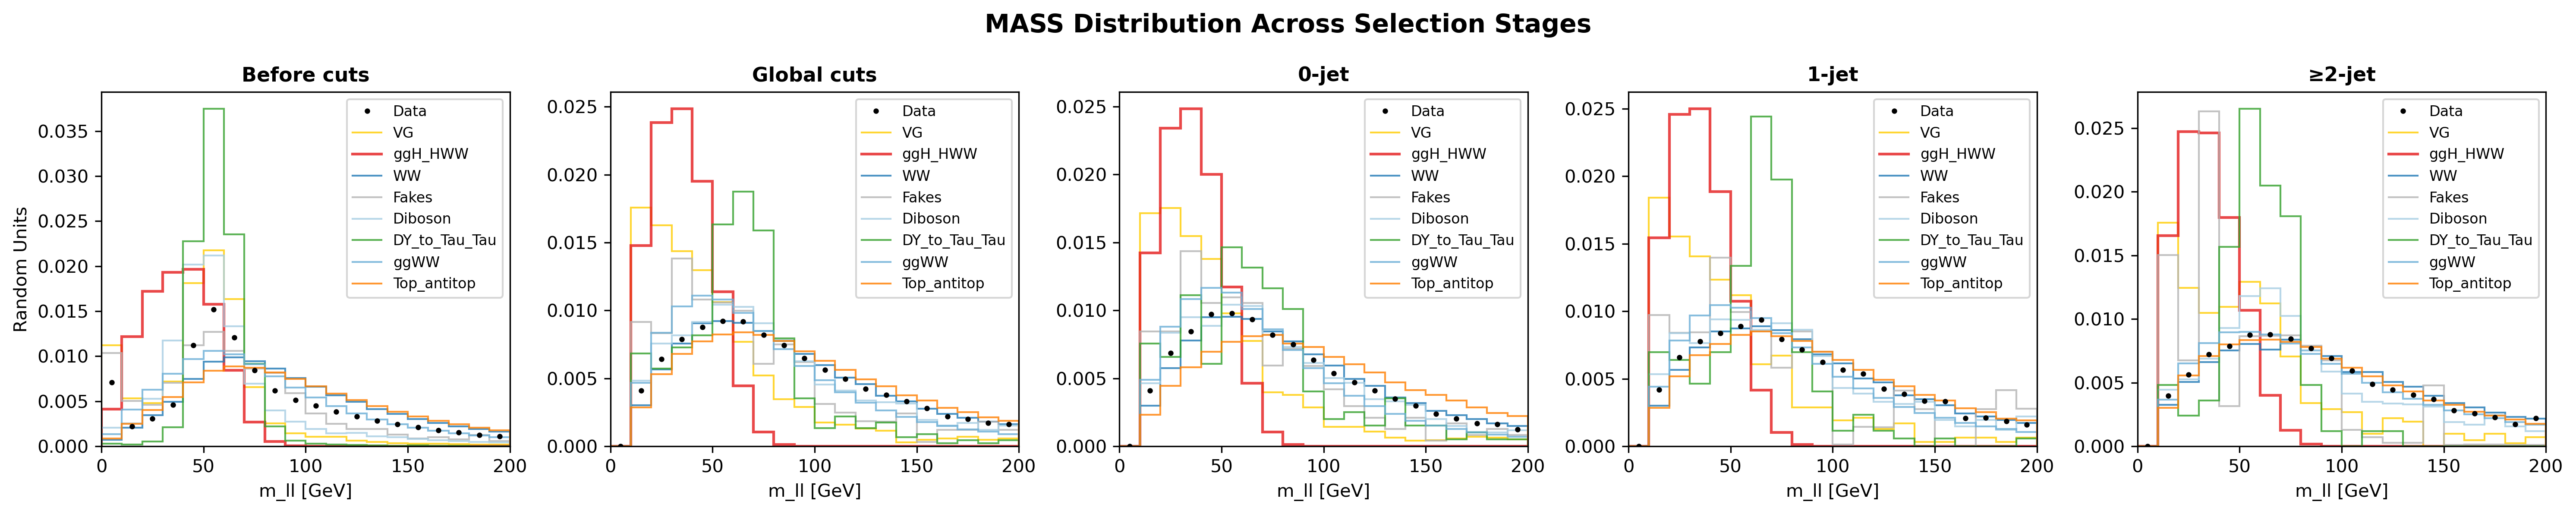


Plotting met...


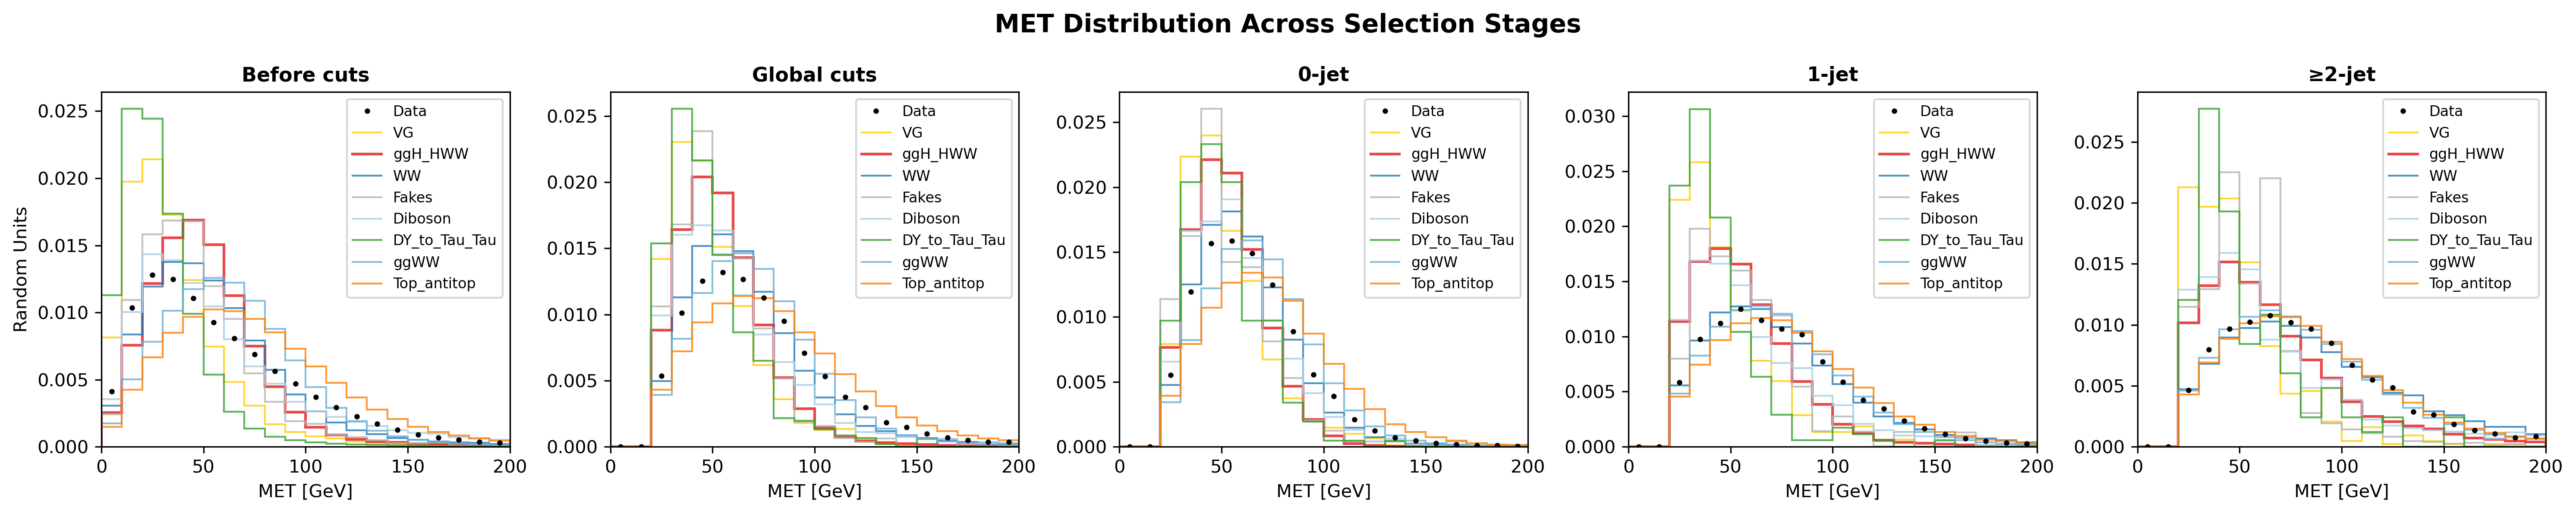


Plotting dphi...


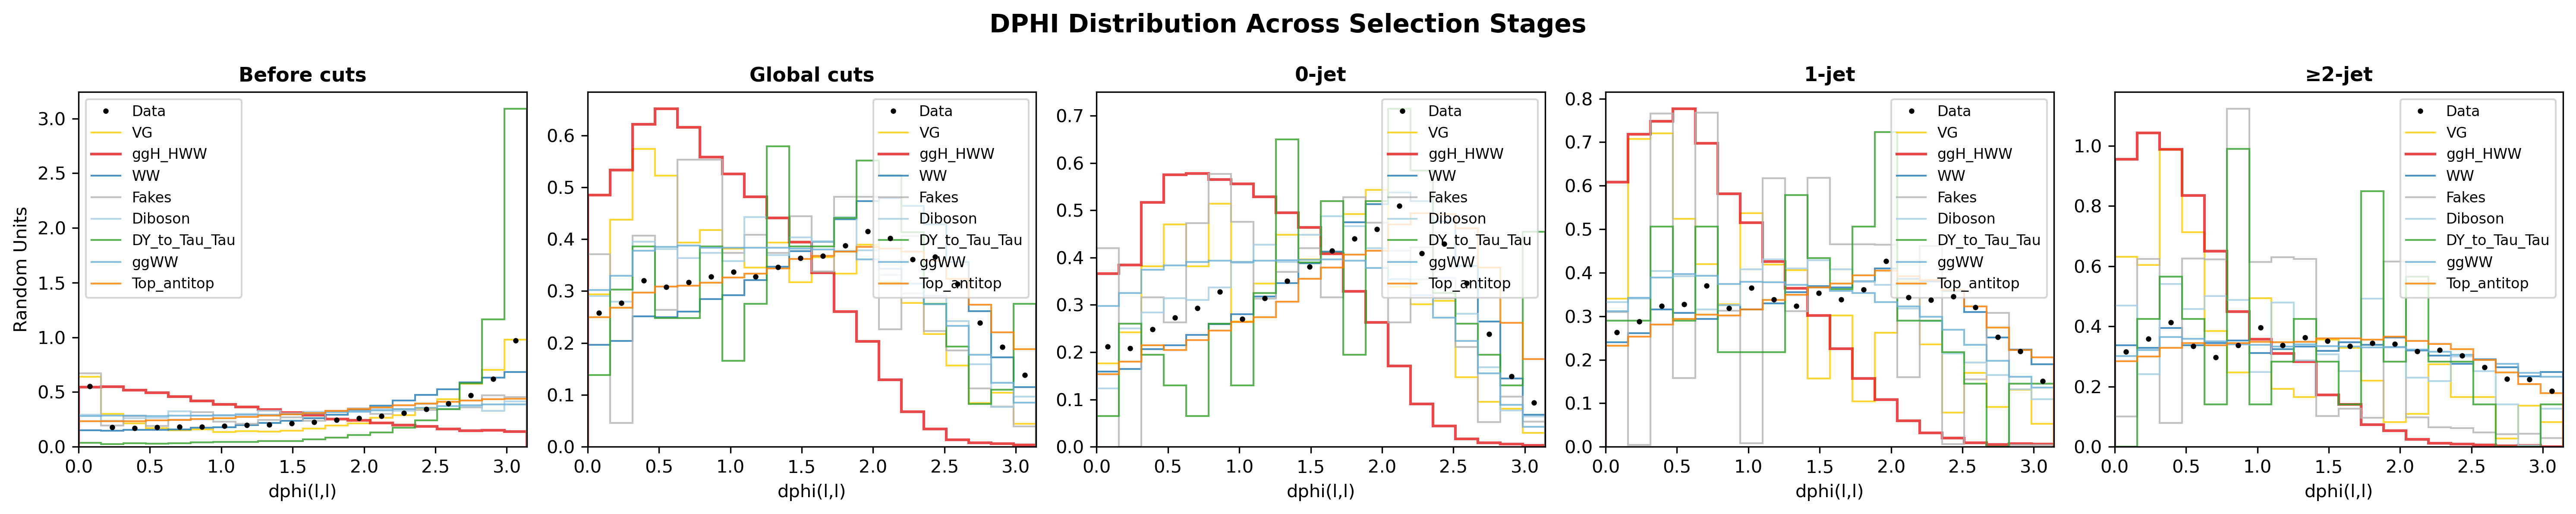


Plotting ptll...


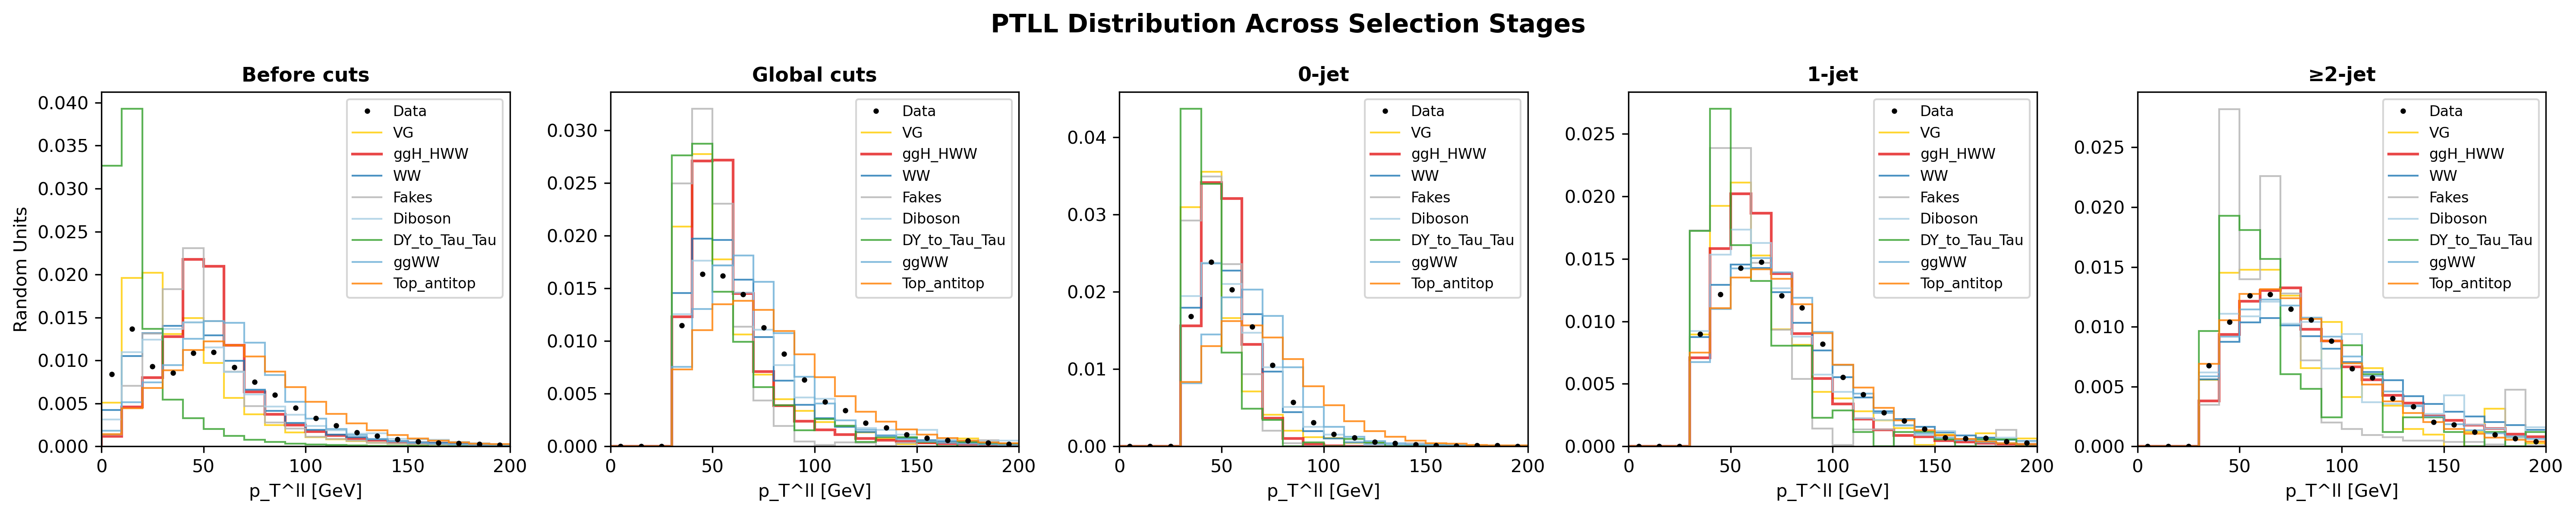


Plotting mt_higgs...


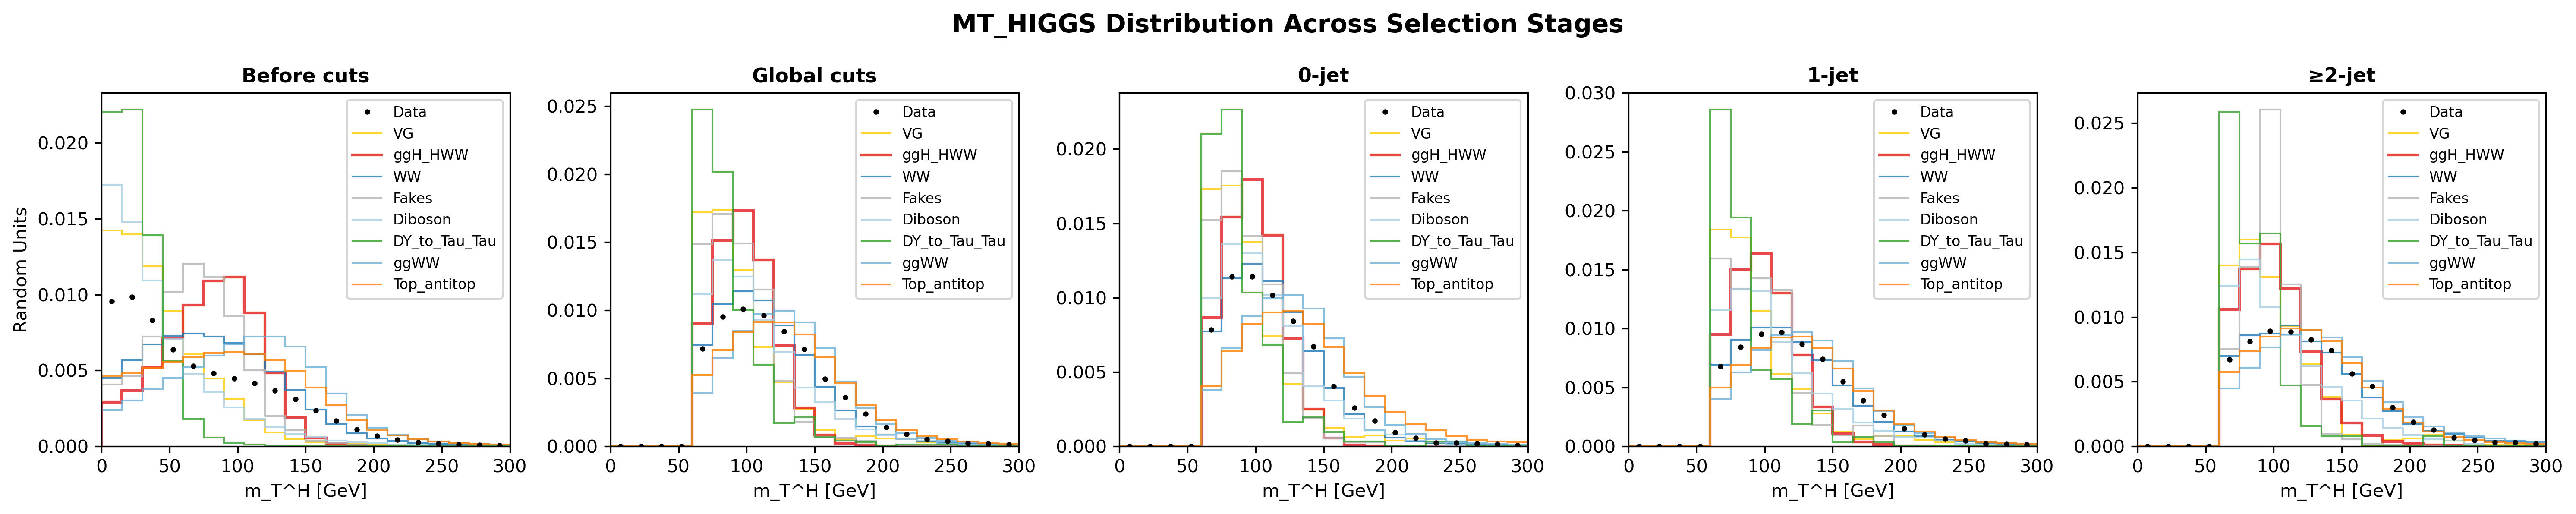


Plotting mt_l2_met...


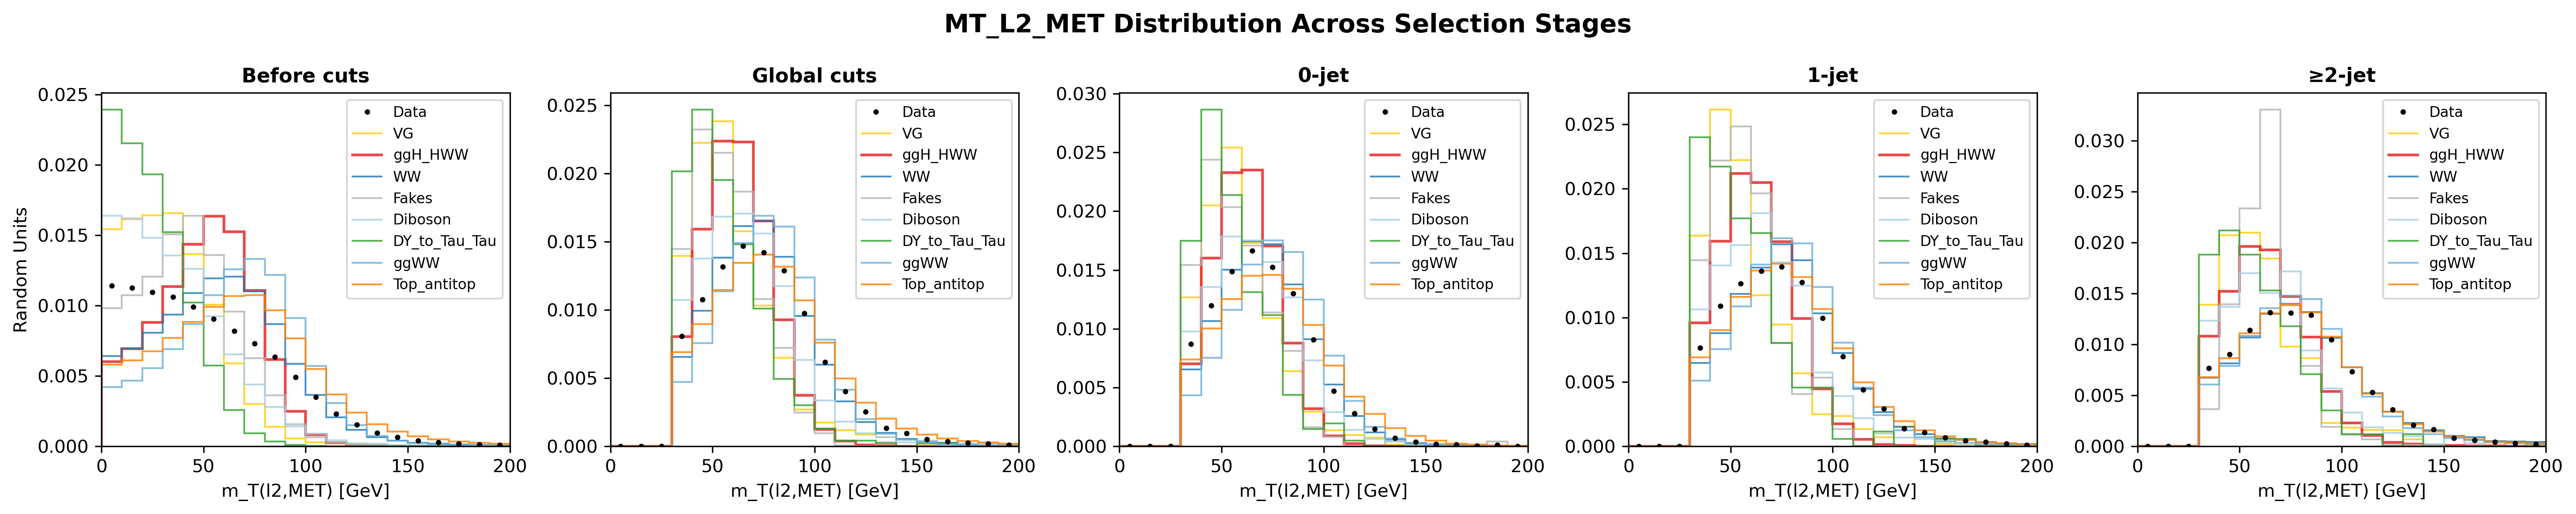


Plotting mjj...


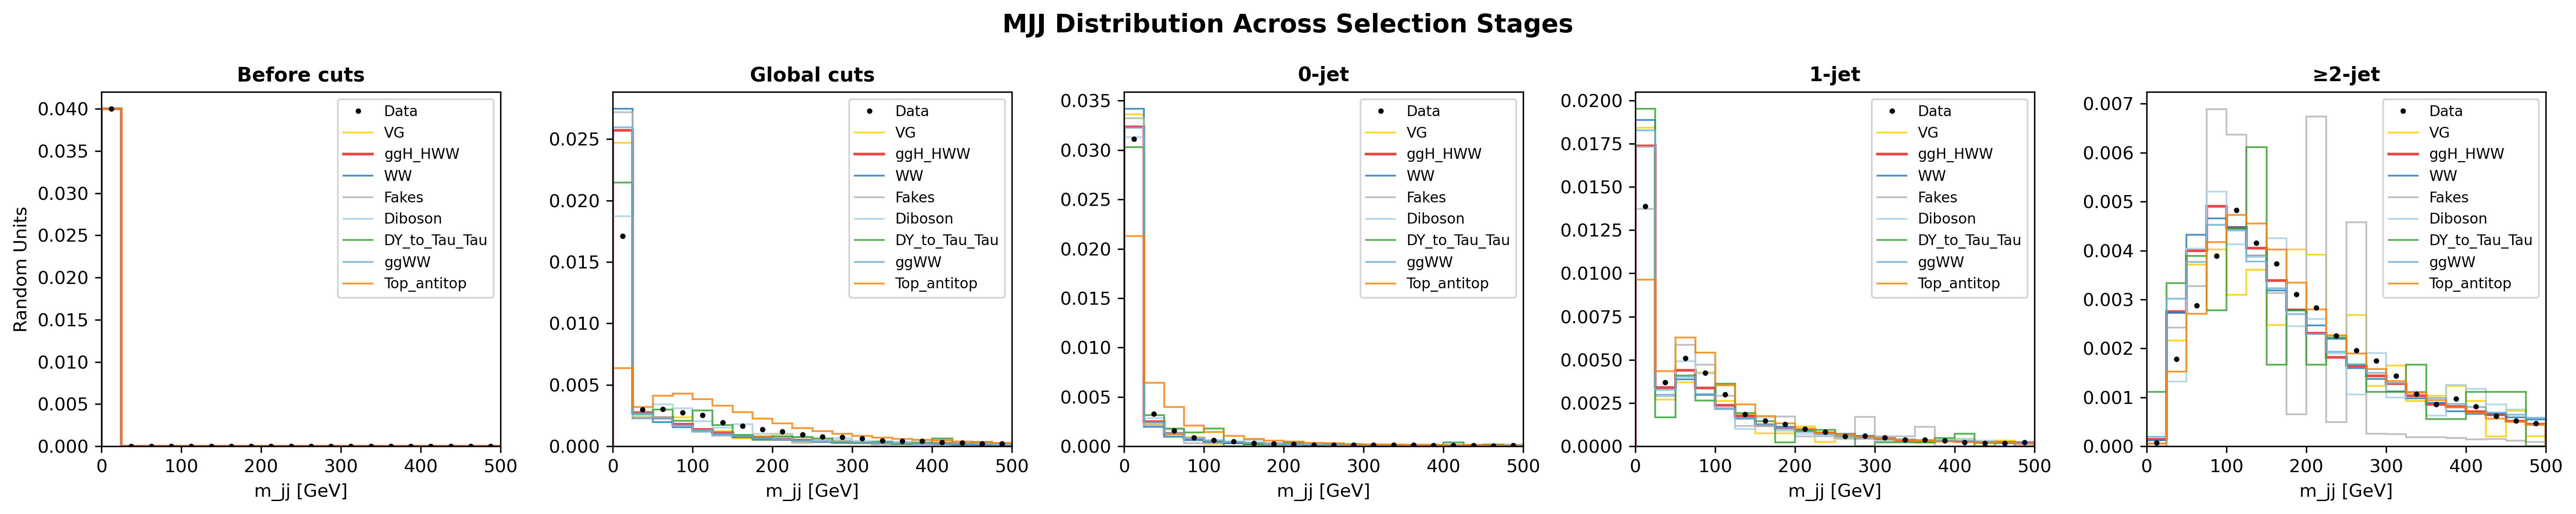


Plotting leading_pt...


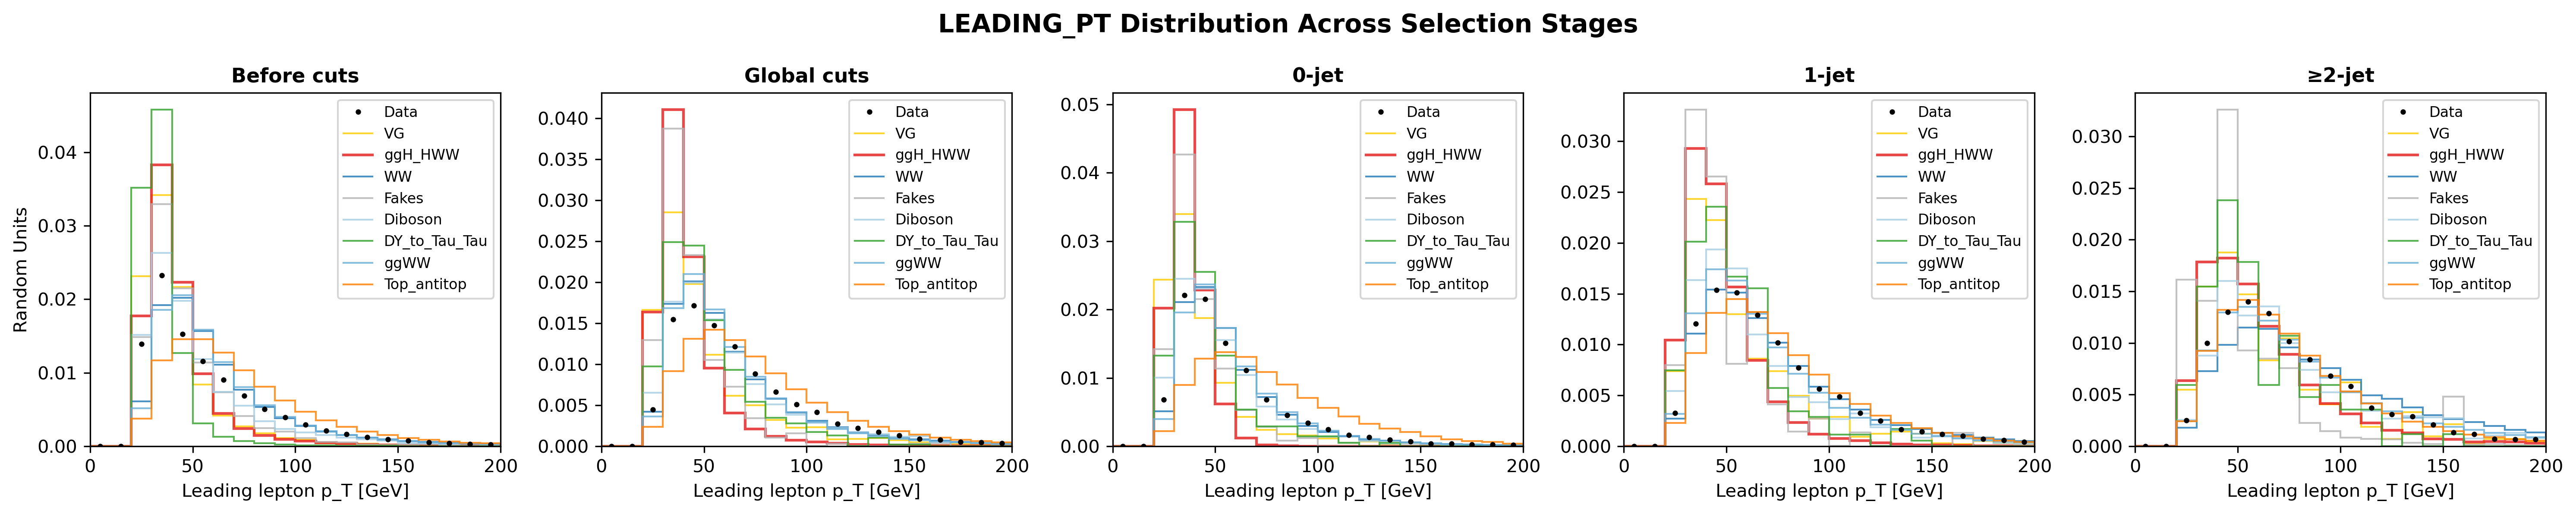


Plotting subleading_pt...


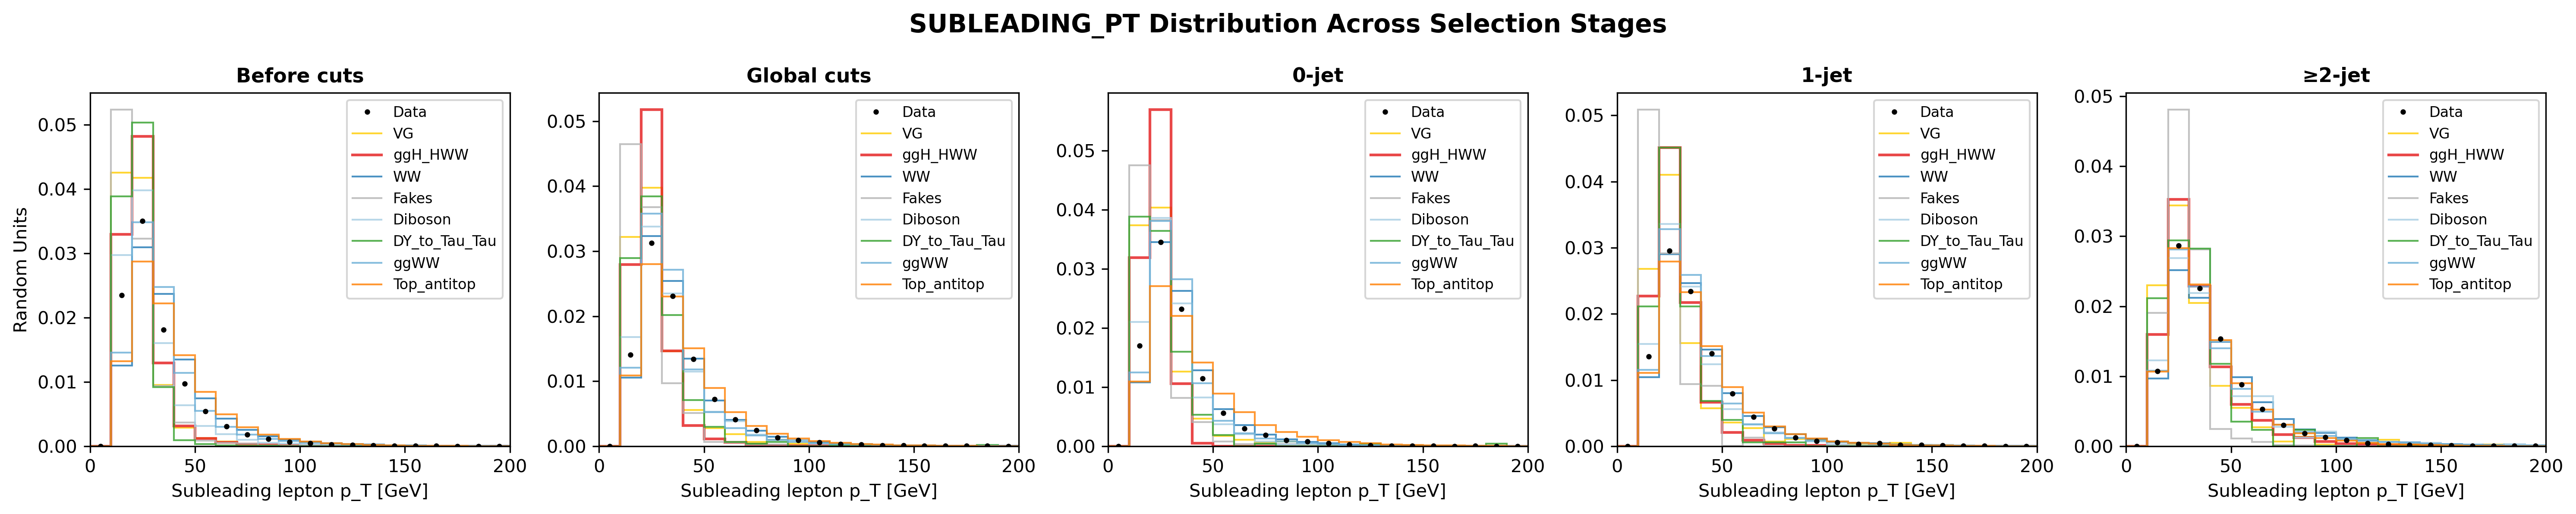

In [267]:
# Plot all variables
for var_name, var_props in variables_to_plots.items():
    print(f"\nPlotting {var_name}...")
    fig = plot_stage_comparison(var_name, var_props, hist_data_final)
    plt.show()

## Stacked plots

### Helper Function

In [273]:
def get_backgrounds_and_signal():
    """Return list of background samples and signal sample sorted by stack_order"""
    
    # Get all background samples with their stack_order
    backgrounds = []
    for sample, props in SAMPLES.items():
        if not props["is_signal"] and props["stack_order"] >=0:
            backgrounds.append((sample, props["stack_order"]))
    
    # Sort by stack_order 
    backgrounds.sort(key=lambda x: x[1])
    backgrounds = [sample for sample, _ in backgrounds]
    
    # Get signal
    signal = None
    for sample, props in SAMPLES.items():
        if props["is_signal"]:
            signal = sample
            break
    
    return backgrounds, signal


def get_data_sample():
    """Return the data sample"""
    return 'Data'


def get_histogram_data(hist_data_all, sample, stage, hist_key):
    """Get histogram data, return None if not available."""
    try:
        hist = hist_data_all[sample][stage][hist_key]
        if hist.sum() == 0:
            return None, None
        
        values = hist.values()
        edges = hist.axes[0].edges
        
        return values, edges
    except (KeyError, AttributeError):
        return None, None

### plotting function

In [287]:
def cms_label(ax, lumi_text="16.393 fb$^{-1}$ (13 TeV)"):
    # Top Left - CMS Open Data
    ax.text(0.0, 1.02, "CMS OpenData", 
            transform=ax.transAxes, 
            fontsize=14, 
            fontweight='bold', 
            ha='left', 
            va='bottom')
    
    # Top Right - Luminosity
    ax.text(1.0, 1.02, lumi_text, 
            transform=ax.transAxes, 
            fontsize=12, 
            ha='right', 
            va='bottom')

def stacked_plots(variable, var_props, hist_data_all, output_dir="plots"):
    
    PLOT_DATA = True 
    os.makedirs(output_dir, exist_ok=True)
    
    use_log_scale = True  
    y_padding = 100 if use_log_scale else 1.4
    xlabel = var_props.get('xlabel', variable)
    xlim = var_props.get('xlim', None)
    
    
    plot_groups = {
        "Signal_Region": [
            ('SR_0jet', 'SR 0-jet'), 
            ('SR_1jet', 'SR 1-jet'), 
            ('SR_2jet', 'SR 2-jet')
        ],
        "Control_Region_Top": [
            ('CR_top_0jet', 'Top CR 0-jet'), 
            ('CR_top_1jet', 'Top CR 1-jet'), 
            ('CR_top_2jet', 'Top CR 2-jet')
        ],
        "Control_Region_Tau": [
            ('CR_tau_0jet', r'$\tau\tau$ CR 0-jet'), 
            ('CR_tau_1jet', r'$\tau\tau$ CR 1-jet'), 
            ('CR_tau_2jet', r'$\tau\tau$ CR 2-jet')
        ]
    }

    backgrounds, signal = get_backgrounds_and_signal()
    data_sample = get_data_sample()
    backgrounds.sort(key=lambda s: SAMPLES[s].get("stack_order", 0))

    samples_to_cache = backgrounds + [signal, data_sample]
    hist_cache = {}
    
    all_regions = []
    for group in plot_groups.values():
        all_regions.extend(group)
        
    for sample in samples_to_cache:
        if sample is None: continue
        hist_cache[sample] = {}
        for stage, _ in all_regions:
            values, edges = get_histogram_data(hist_data_all, sample, stage, variable)
            if values is not None and edges is not None:  
                hist_cache[sample][stage] = (values, edges)

    for group_name, region_list in plot_groups.items():
        
        print(f"Processing Group: {group_name}...")
        
        fig = plt.figure(figsize=(24, 8), dpi=100)
        
        plt.subplots_adjust(left=0.05, right=0.98, top=0.85, bottom=0.12)
        
        gs = fig.add_gridspec(2, 3, height_ratios=[3, 1], hspace=0.1, wspace=0.25)
        
        plotted_anything = False
        
        group_handles = {}
        bg_labels_ordered = [] 

        for col_idx, (stage, stage_label) in enumerate(region_list):
            
            ax_main = fig.add_subplot(gs[0, col_idx])
            ax_ratio = fig.add_subplot(gs[1, col_idx], sharex=ax_main)
            plt.setp(ax_main.get_xticklabels(), visible=False)

            edges = None
            for sample in hist_cache:
                if stage in hist_cache[sample]:
                    _, edges = hist_cache[sample][stage]
                    break

            if edges is None:
                ax_main.text(0.5, 0.5, 'No data', ha='center', transform=ax_main.transAxes)
                continue
                
            plotted_anything = True

            # 1. PREPARE STACK
            bg_values = []
            bg_colors = []
            
            for sample in backgrounds:
                if sample in hist_cache and stage in hist_cache[sample]:   
                    values, _ = hist_cache[sample][stage]
                    bg_values.append(values)
                    bg_colors.append(SAMPLES[sample]["color"])
                    if sample not in group_handles: 
                        group_handles[sample] = mpatches.Patch(facecolor=SAMPLES[sample]["color"], label=sample)
                        bg_labels_ordered.append(sample) 

            # Signal (Stacked)
            signal_values = None
            if signal and signal in hist_cache and stage in hist_cache[signal]:  
                signal_values, _ = hist_cache[signal][stage]
                bg_values.append(signal_values)
                bg_colors.append(SAMPLES[signal]["color"])
                if signal not in group_handles:
                      group_handles[signal] = plt.Line2D([0],[0], color=SAMPLES[signal]["color"], linewidth=2.5, label=signal)
                      bg_labels_ordered.append(signal)

            #  PLOT MAIN
            if bg_values:  
                ax_main.hist([edges[:-1] for _ in bg_values], bins=edges, weights=bg_values,
                             stacked=True, color=bg_colors, histtype='stepfilled', alpha=1.0, edgecolor='none')

            # Signal Overlay
            if signal_values is not None:
                ax_main.hist(edges[:-1], bins=edges, weights=signal_values, histtype='step',
                             color=SAMPLES[signal]["color"], linewidth=2.5, zorder=10)

            # Data
            data_values = None
            if PLOT_DATA and data_sample in hist_cache and stage in hist_cache[data_sample]:
                data_values, _ = hist_cache[data_sample][stage]
                centers = 0.5 * (edges[:-1] + edges[1:])
                ax_main.errorbar(centers, data_values, yerr=np.sqrt(np.maximum(data_values, 0)), 
                                 fmt='o', color='black', markersize=4, zorder=11, label=data_sample)
                if data_sample not in group_handles:
                    group_handles[data_sample] = plt.Line2D([0],[0], marker='o', color='black', linestyle='none', label=data_sample)

            #  PLOT RATIO
            total_mc = np.sum(bg_values, axis=0) if bg_values else np.zeros(len(edges)-1)
            ax_ratio.axhline(1.0, color='gray', linestyle='--', linewidth=1)

            if data_values is not None and np.sum(total_mc) > 0:
                valid_bins = total_mc > 0
                ratio = np.zeros_like(total_mc)
                ratio[valid_bins] = data_values[valid_bins] / total_mc[valid_bins]
                ratio_err = np.zeros_like(total_mc)
                ratio_err[valid_bins] = np.sqrt(data_values[valid_bins]) / total_mc[valid_bins]
                
                centers = 0.5 * (edges[:-1] + edges[1:])
                ax_ratio.errorbar(centers, ratio, yerr=ratio_err, fmt='o', color='black', markersize=3)

            # STYLING
            cms_label(ax_main)
            
            # Limits
            ax_ratio.set_ylim(0.0, 2.0)
            ax_ratio.set_ylabel("Data / Pred", fontsize=10)
            ax_ratio.set_xlabel(xlabel, fontsize=12)
            ax_ratio.grid(True, linestyle=':', alpha=0.5)

            y_max = np.max(total_mc) if len(total_mc) > 0 else 0
            if data_values is not None: y_max = max(y_max, np.max(data_values))
            
            if use_log_scale:
                ax_main.set_yscale('log')
                ax_main.set_ylim(0.1, 1000)
            else:
                ax_main.set_ylim(0, y_max * 1.4)
                
            if xlim: ax_main.set_xlim(xlim)
            else: ax_main.set_xlim(edges[0], edges[-1])

            ax_main.set_title(stage_label, fontsize=14, fontweight='bold')
            ax_main.set_ylabel('Events', fontsize=12)

        if plotted_anything:
            final_handles = []
            final_labels = []
            
            # Data first
            if data_sample in group_handles:
                final_handles.append(group_handles[data_sample])
                final_labels.append(data_sample)
            
            # Signal second
            if signal in group_handles:
                final_handles.append(group_handles[signal])
                final_labels.append(signal)

            # Backgrounds 
            for sample in reversed(backgrounds):
                if sample in group_handles and sample in bg_labels_ordered:
                    final_handles.append(group_handles[sample])
                    final_labels.append(sample)

            fig.legend(final_handles, final_labels, 
                       loc='upper center', 
                       bbox_to_anchor=(0.5, 0.98), 
                       ncol=6, 
                       fontsize=12, 
                       frameon=False)

            filename_base = f"{output_dir}/{variable}_{group_name}"
            plt.savefig(f"{filename_base}.png", bbox_inches='tight')
            print(f"Saved: {filename_base}.png")
            plt.show()
        
        plt.close(fig)

    return "Grouped plots complete."


GENERATING DISTRIBUTION PLOTS 
Variables: mass, met, ptll, dphi, mt_higgs, mt_l2_met, mjj, leading_pt, subleading_pt
Output Directory: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/stacked
--------------------------------------------------------------------------------

---> Processing mass...
Processing Group: Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/stacked/mass_Signal_Region.png


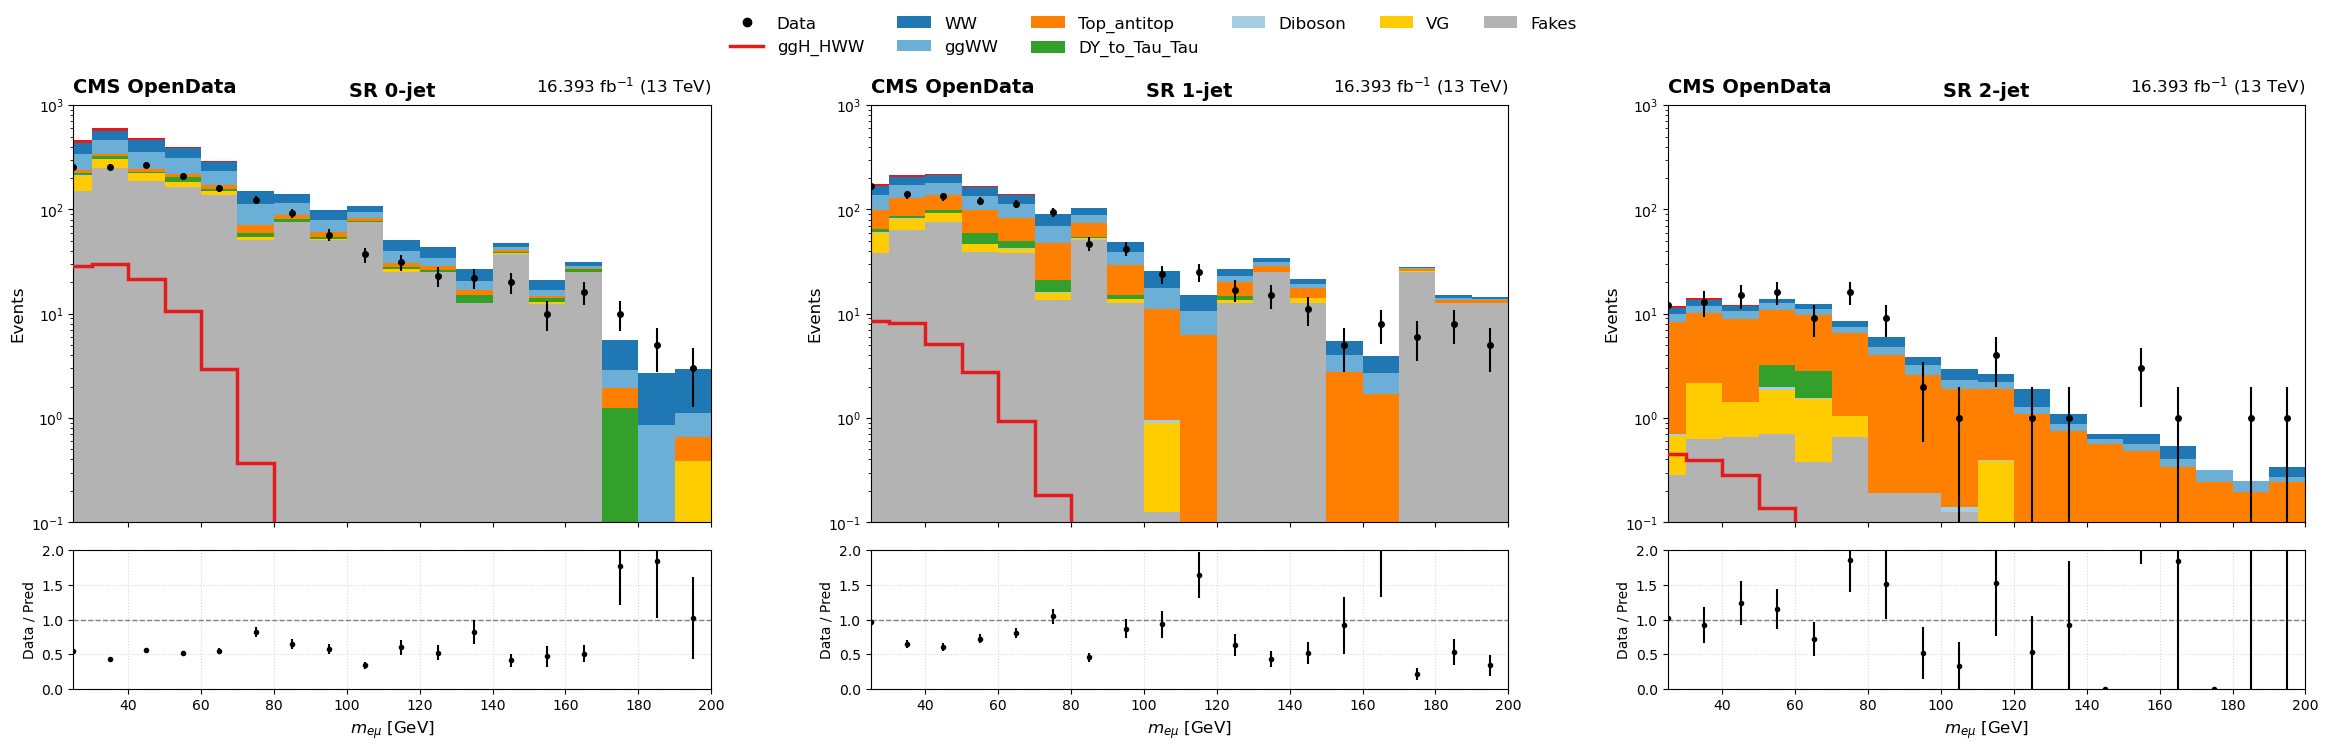

Processing Group: Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/stacked/mass_Control_Region_Top.png


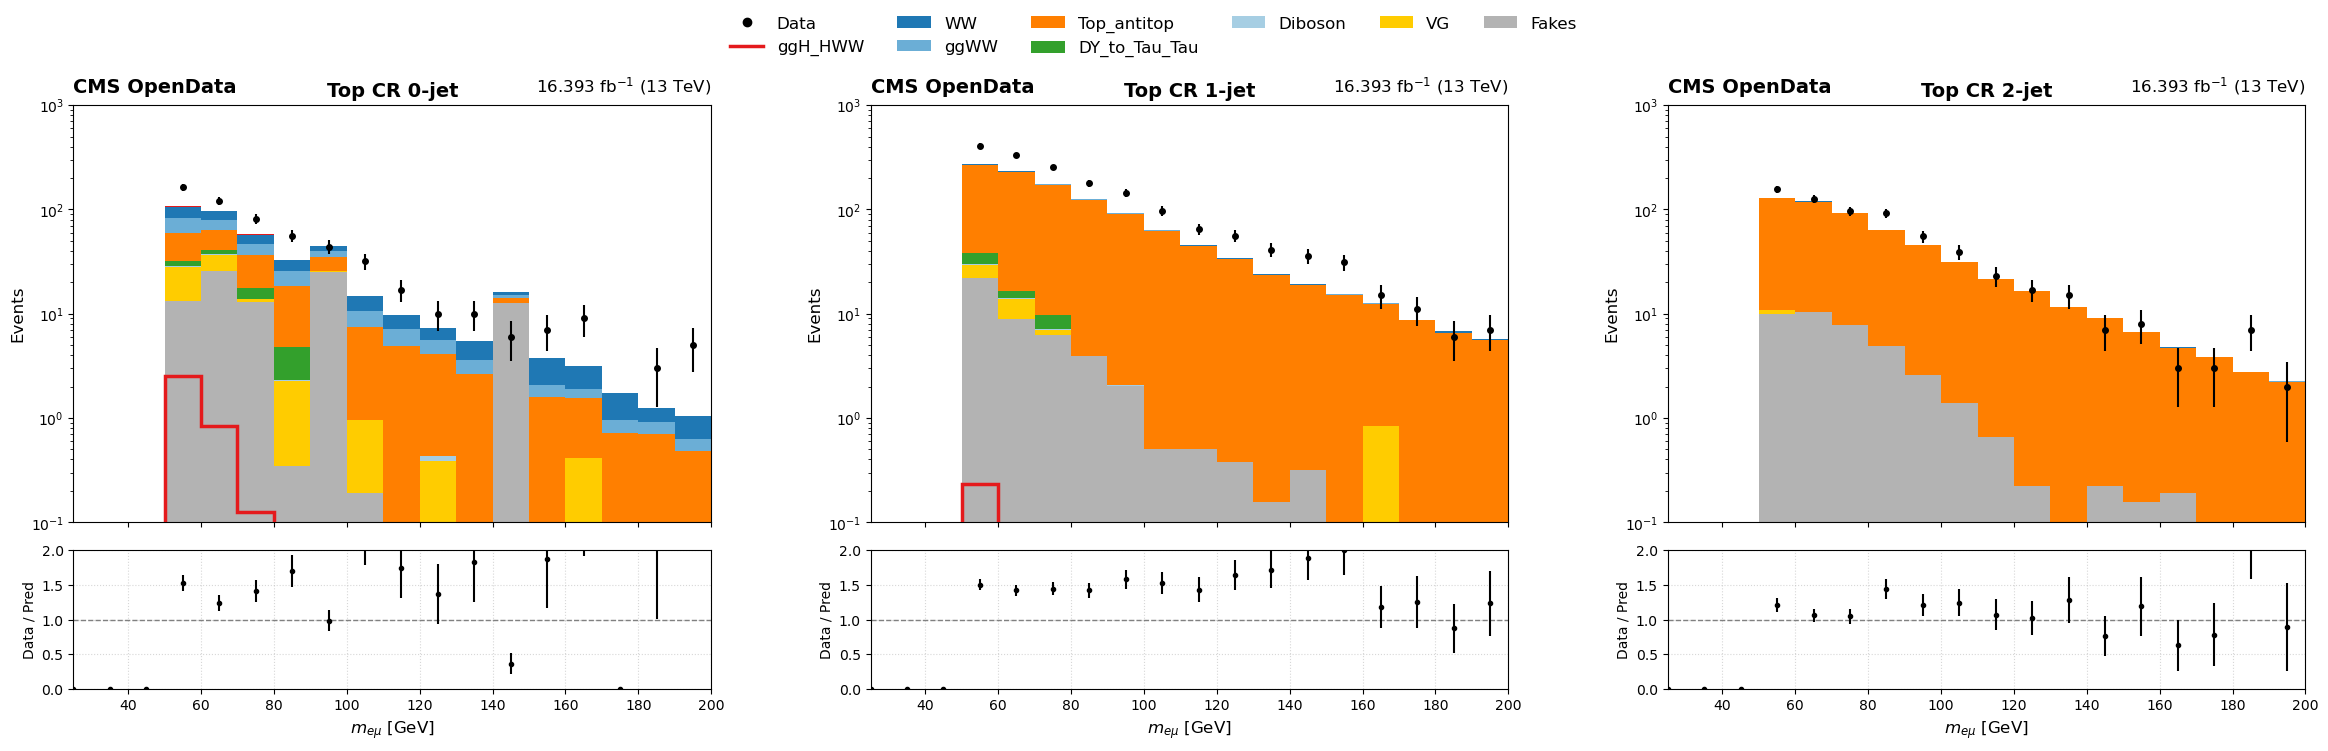

Processing Group: Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/stacked/mass_Control_Region_Tau.png


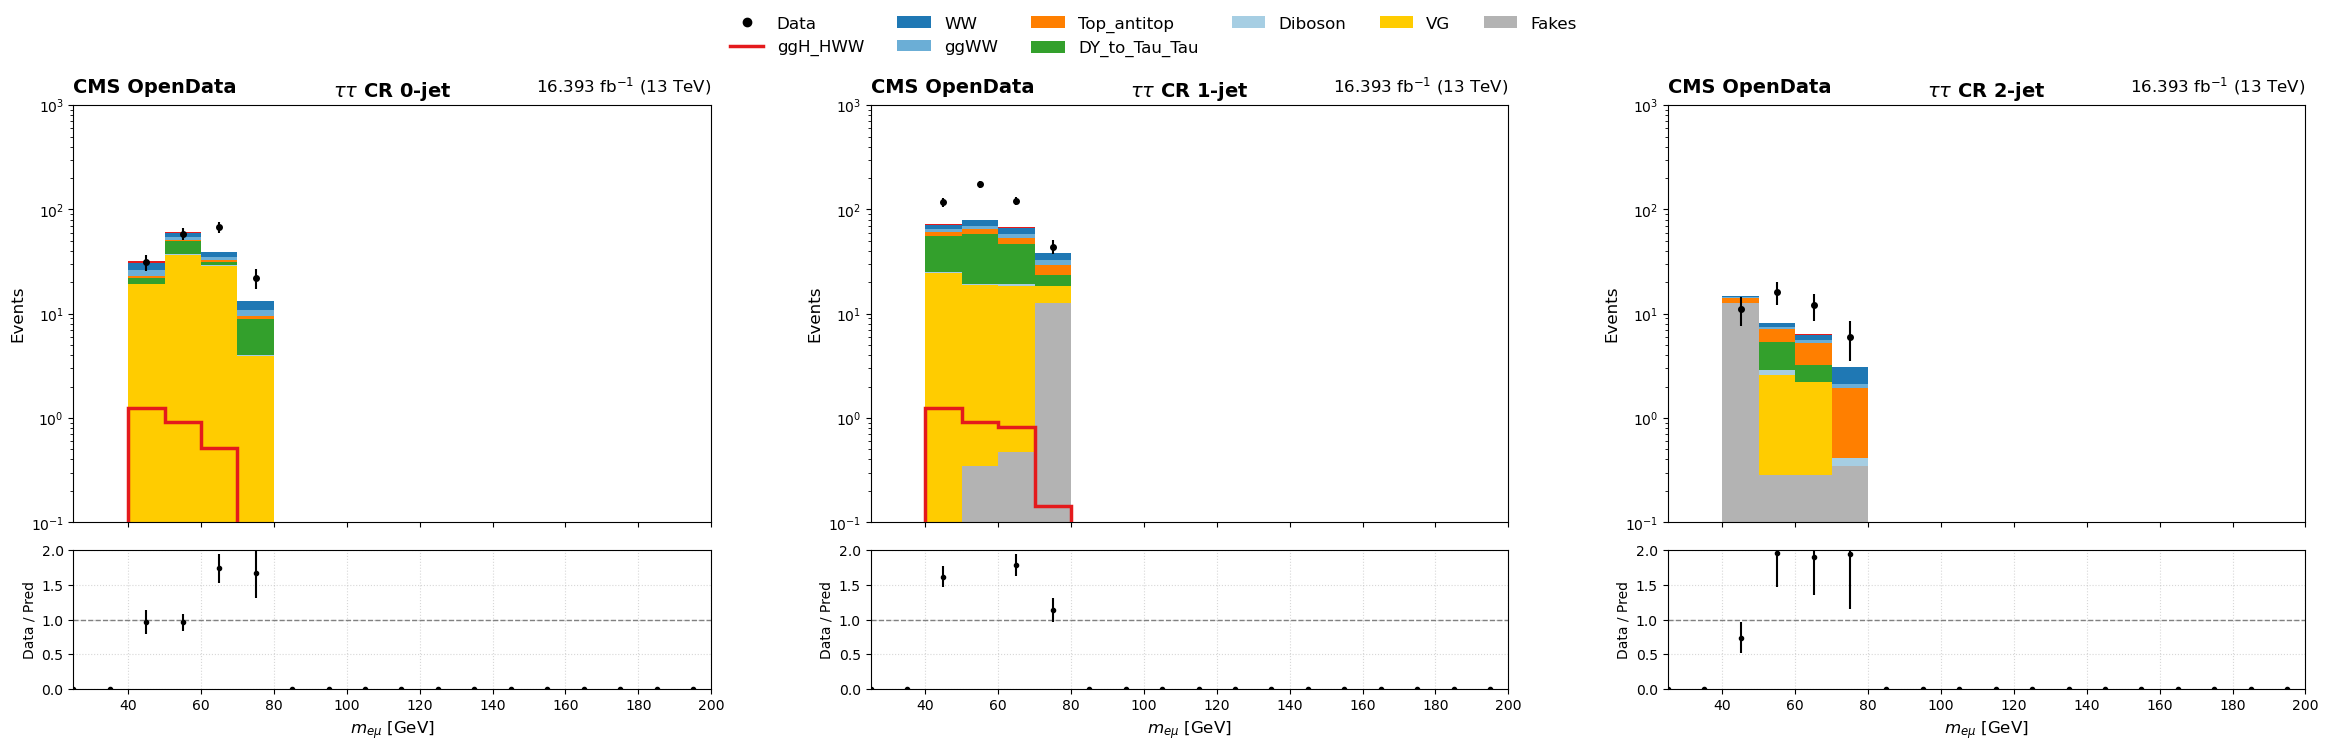


---> Processing met...
Processing Group: Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/stacked/met_Signal_Region.png


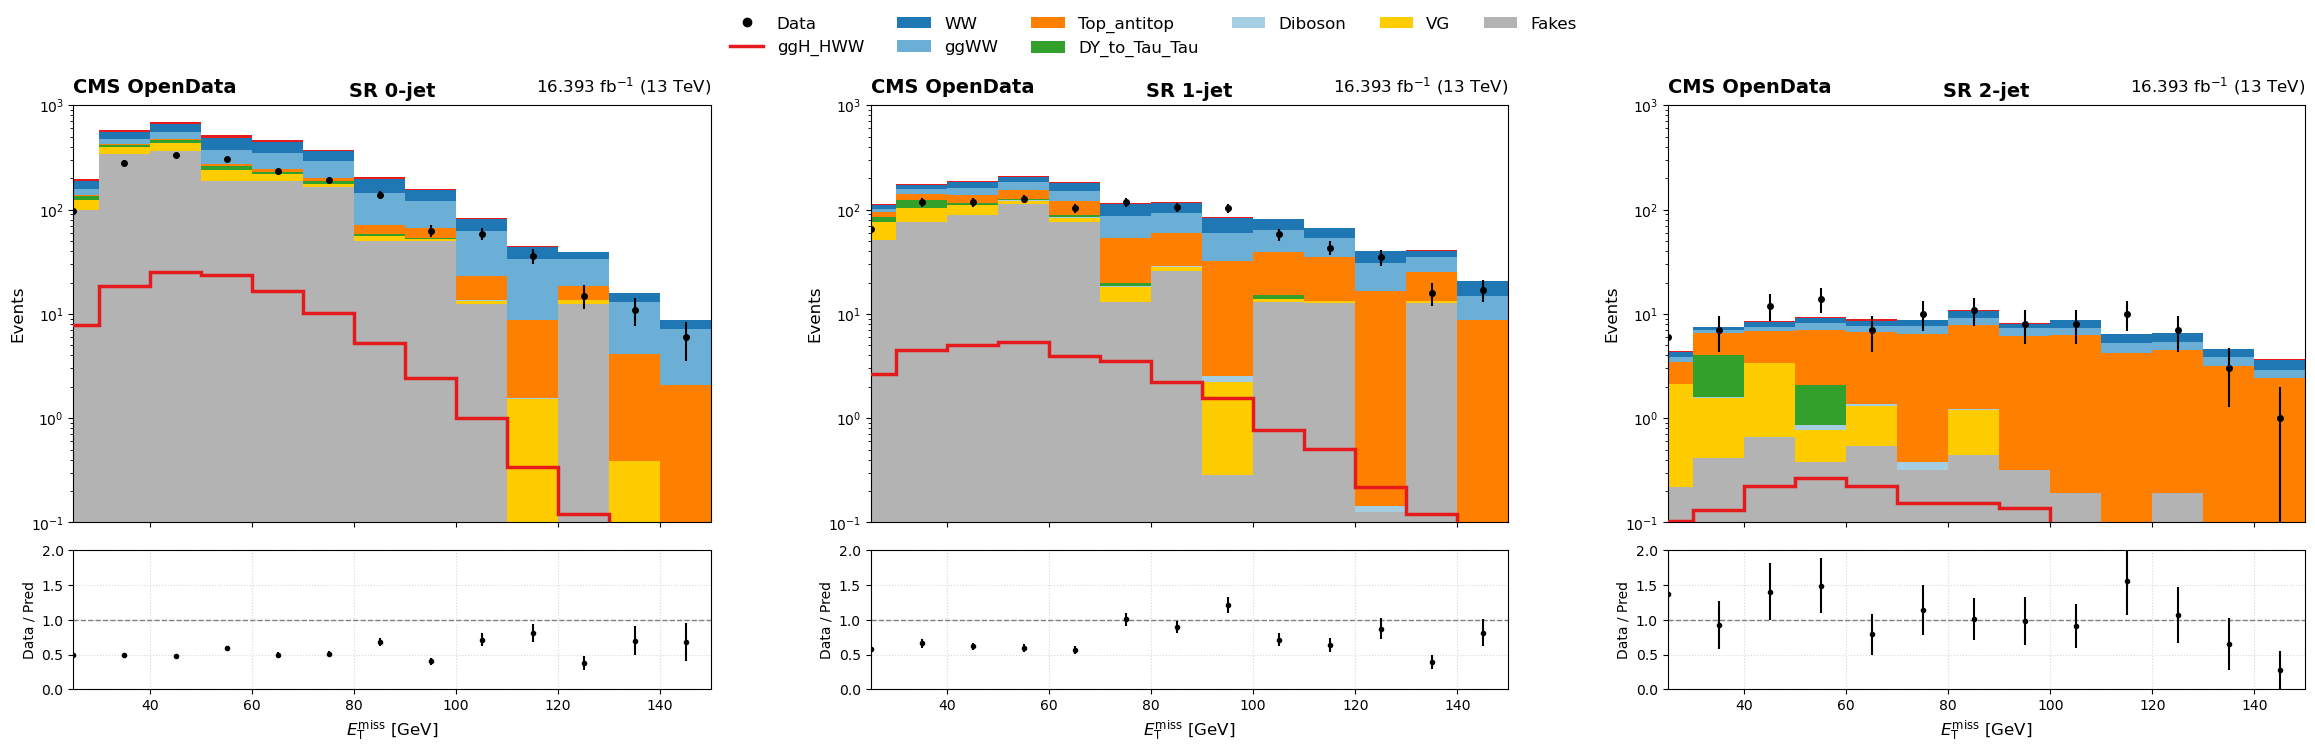

Processing Group: Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/stacked/met_Control_Region_Top.png


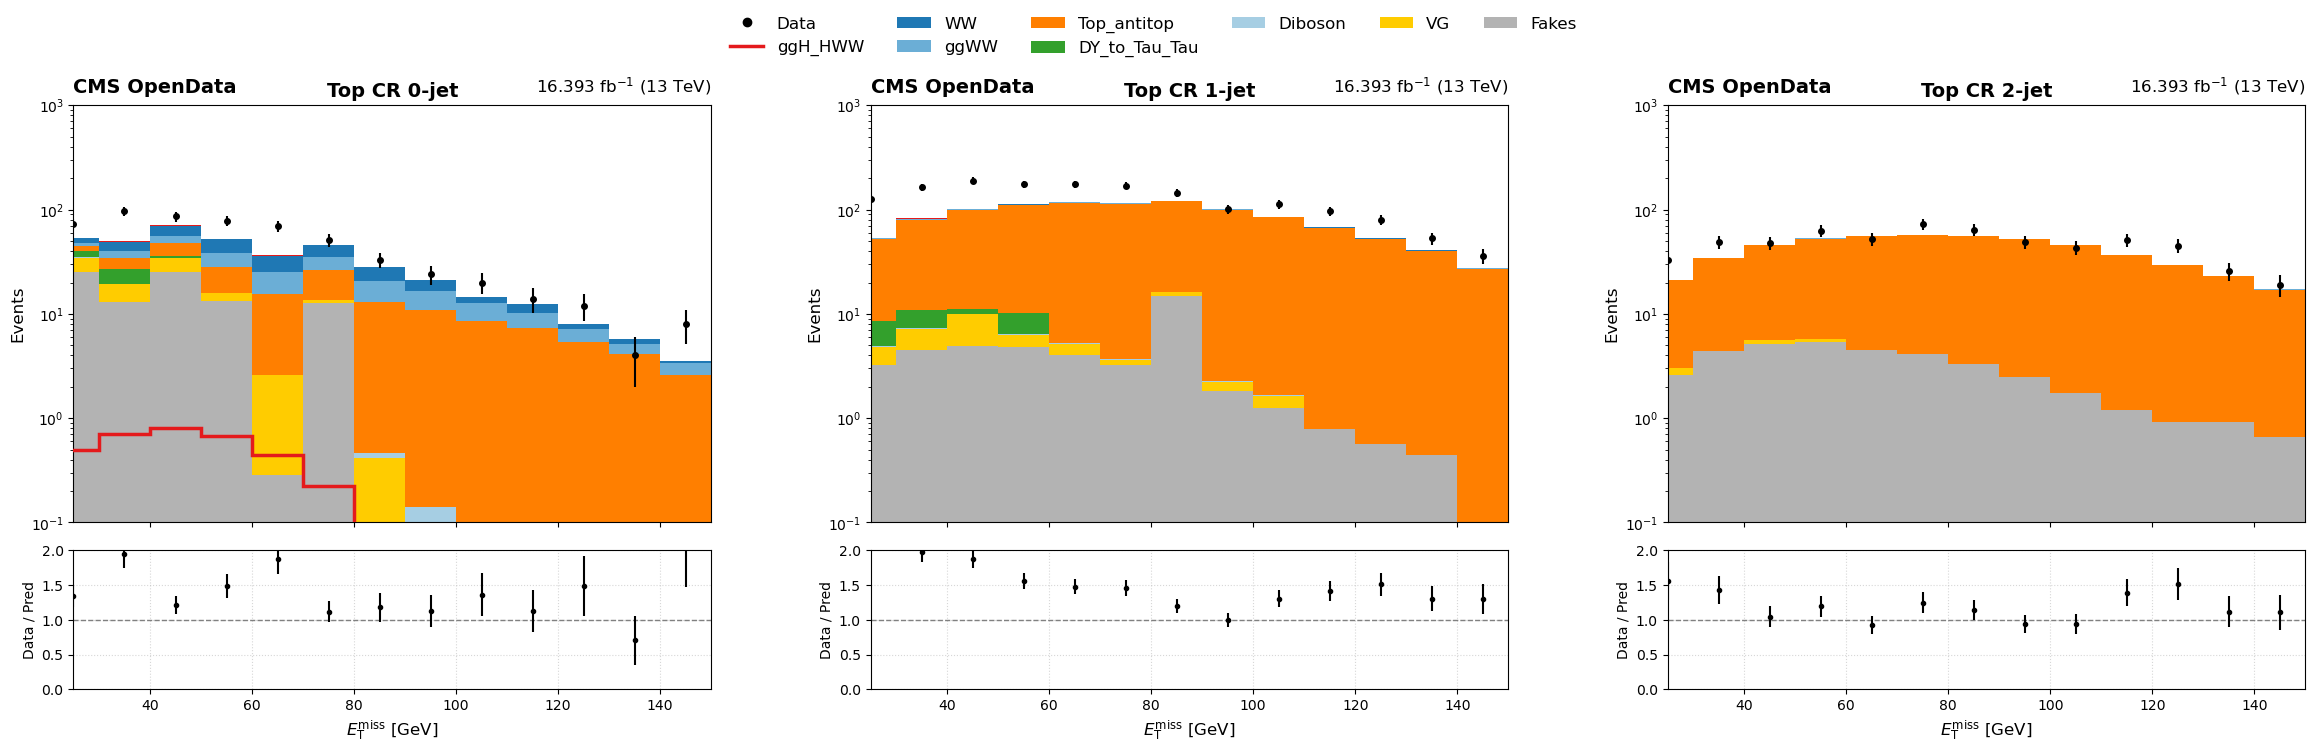

Processing Group: Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/stacked/met_Control_Region_Tau.png


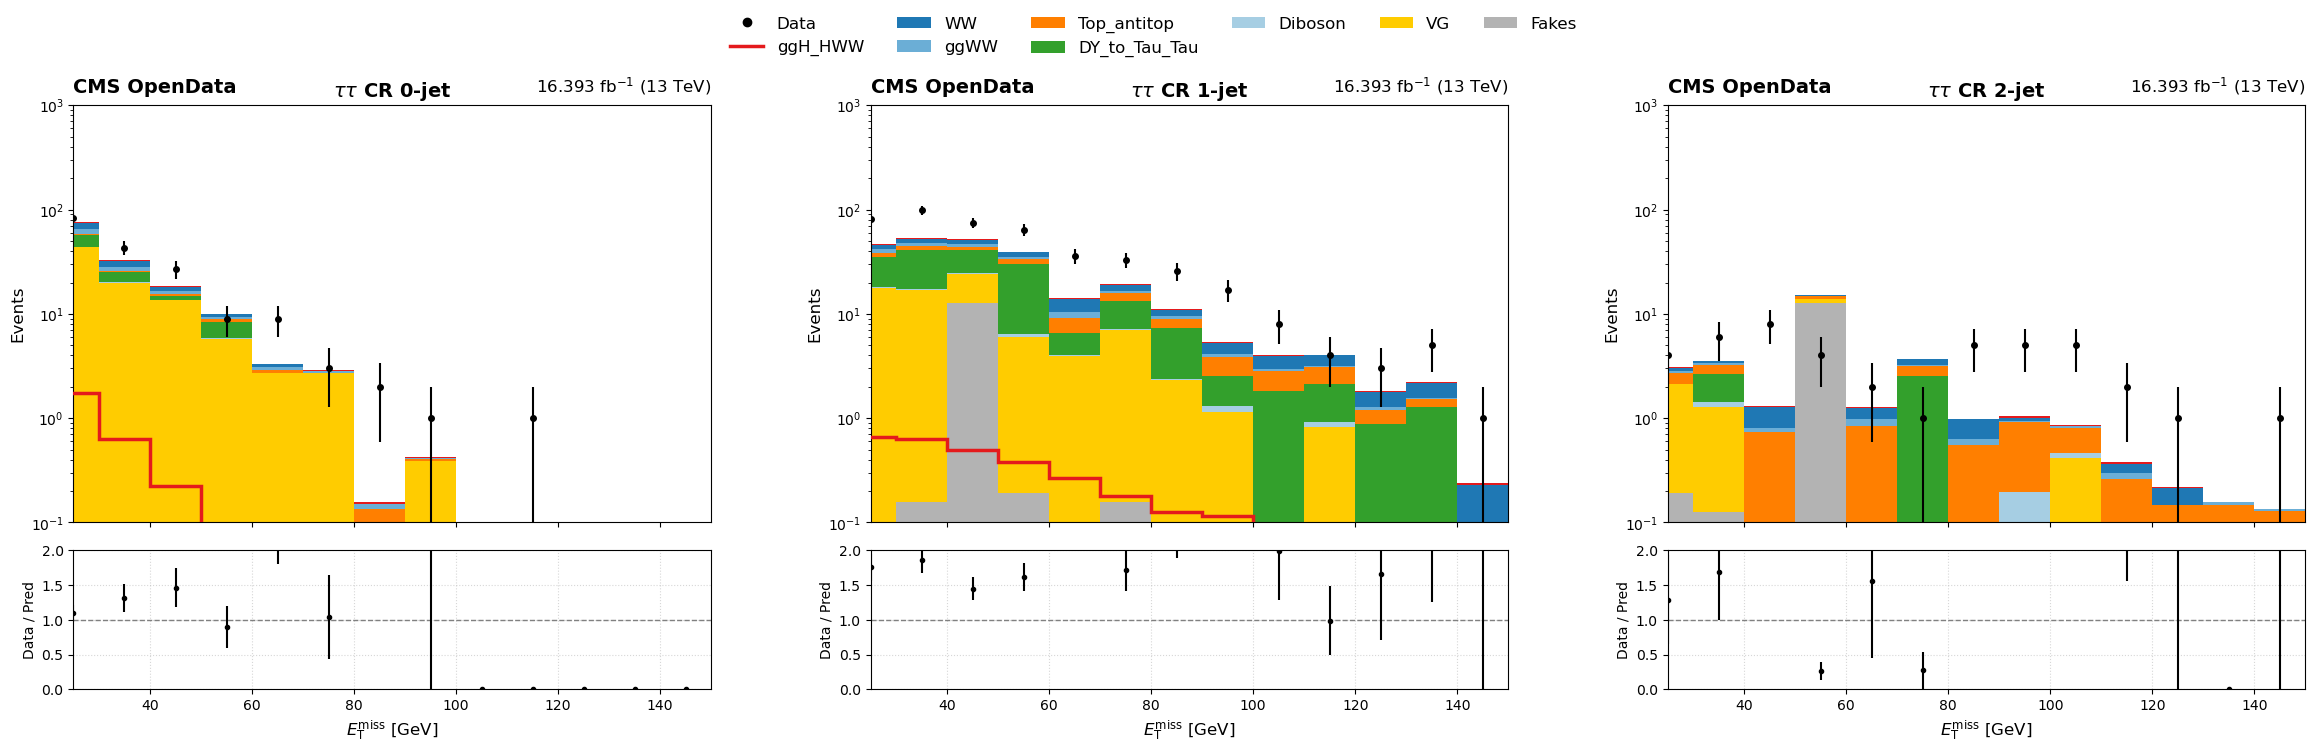


---> Processing ptll...
Processing Group: Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/stacked/ptll_Signal_Region.png


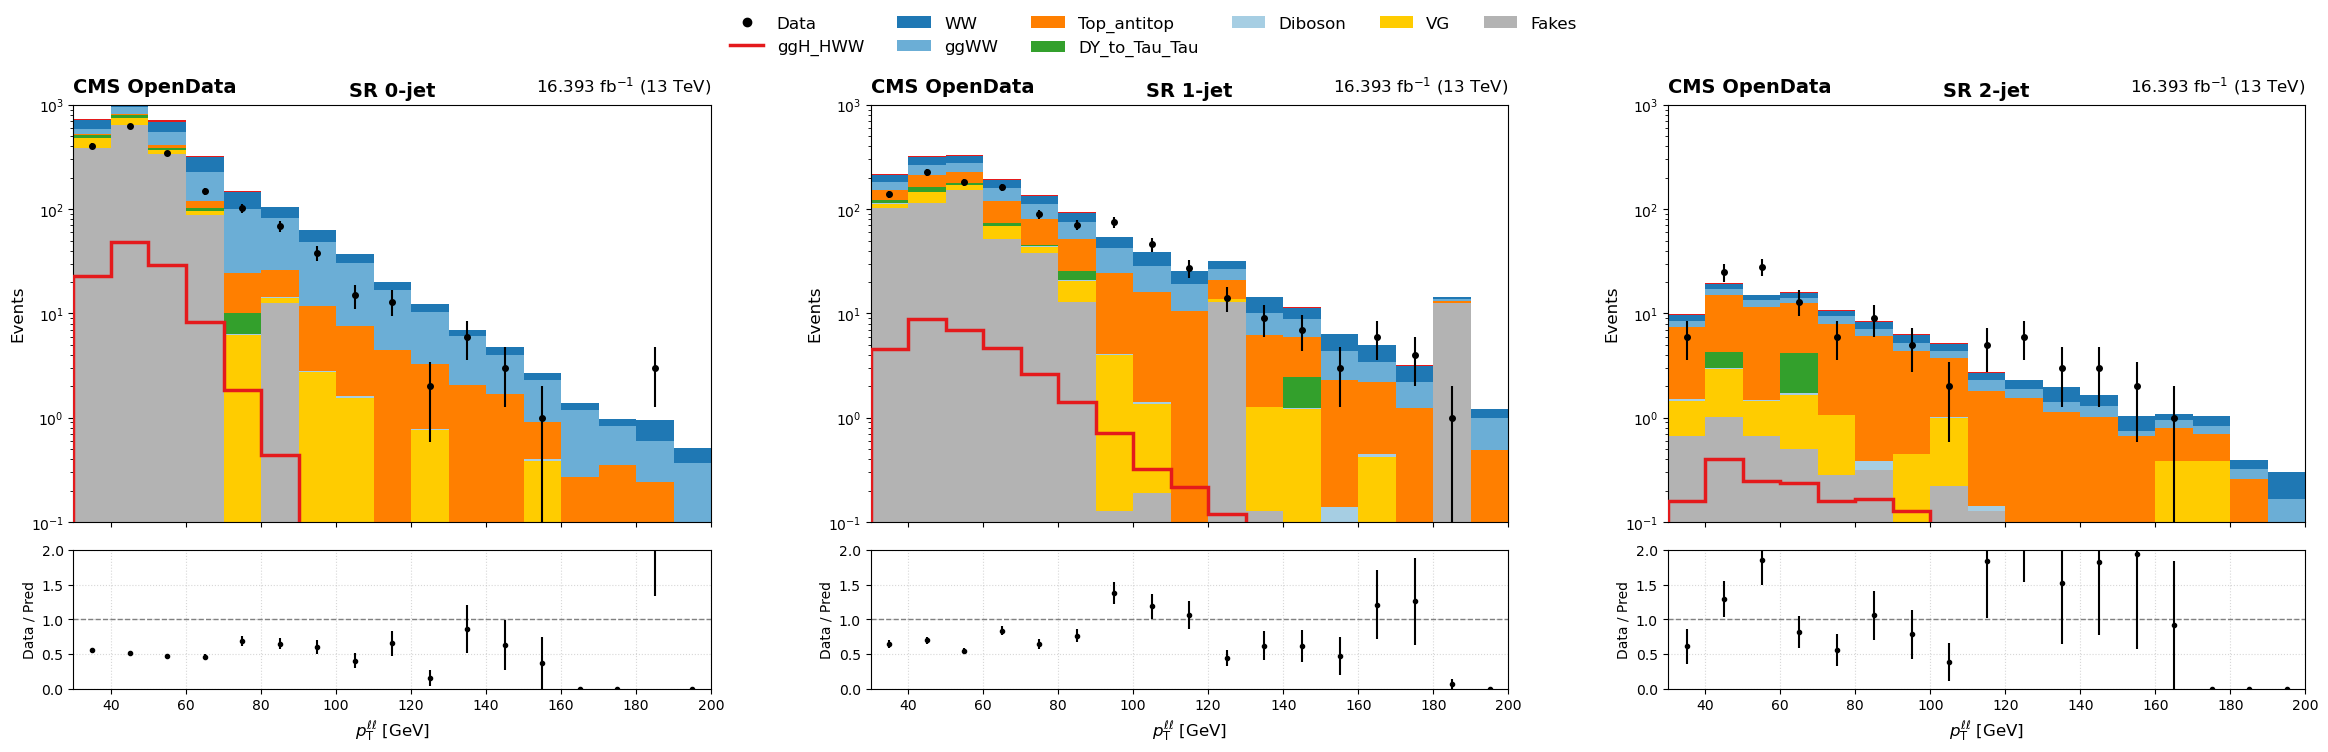

Processing Group: Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/stacked/ptll_Control_Region_Top.png


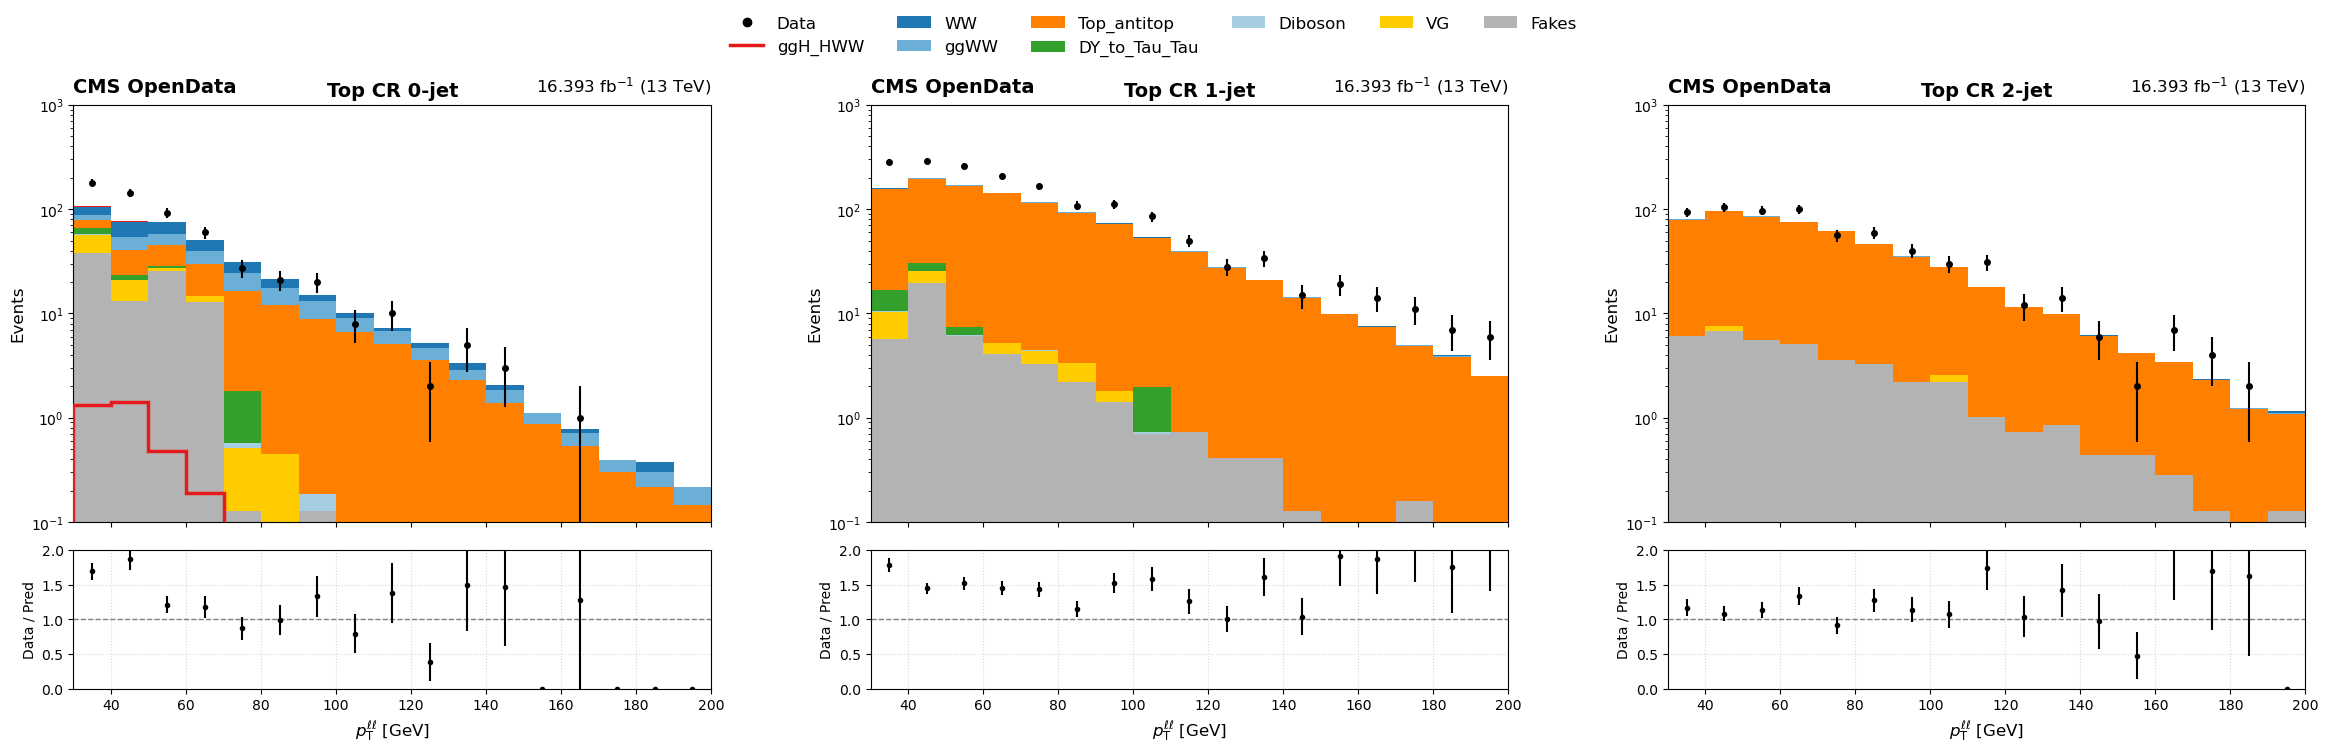

Processing Group: Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/stacked/ptll_Control_Region_Tau.png


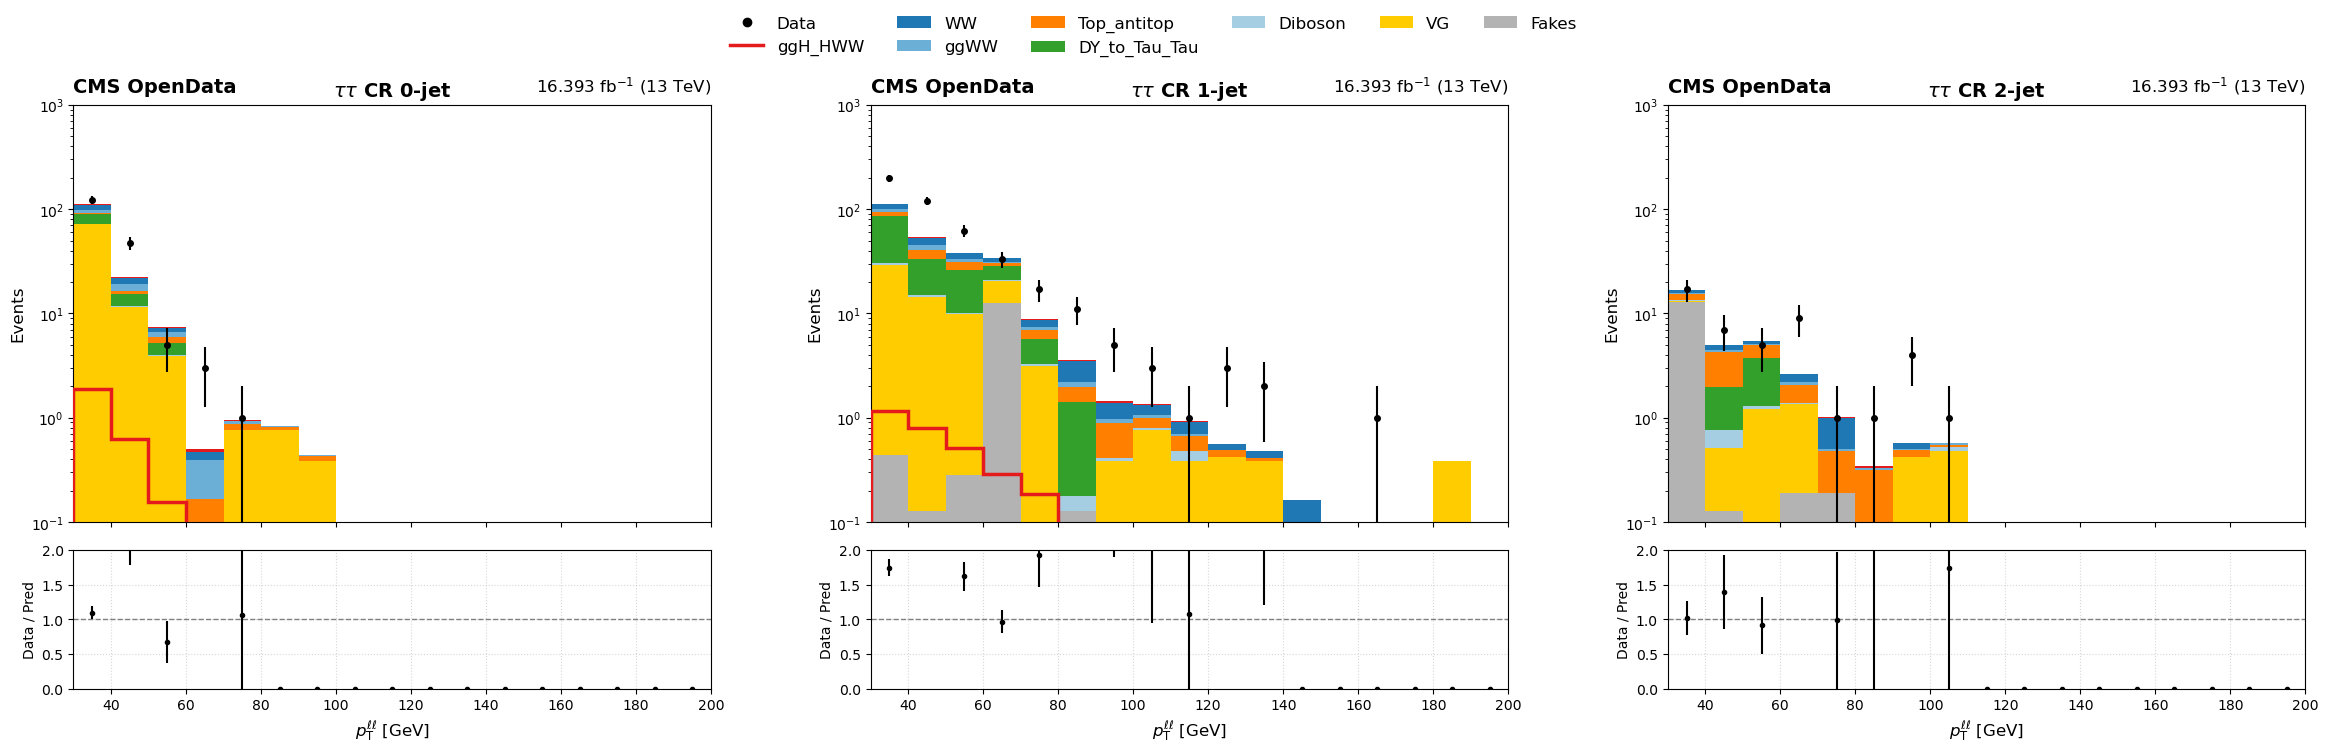


---> Processing dphi...
Processing Group: Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/stacked/dphi_Signal_Region.png


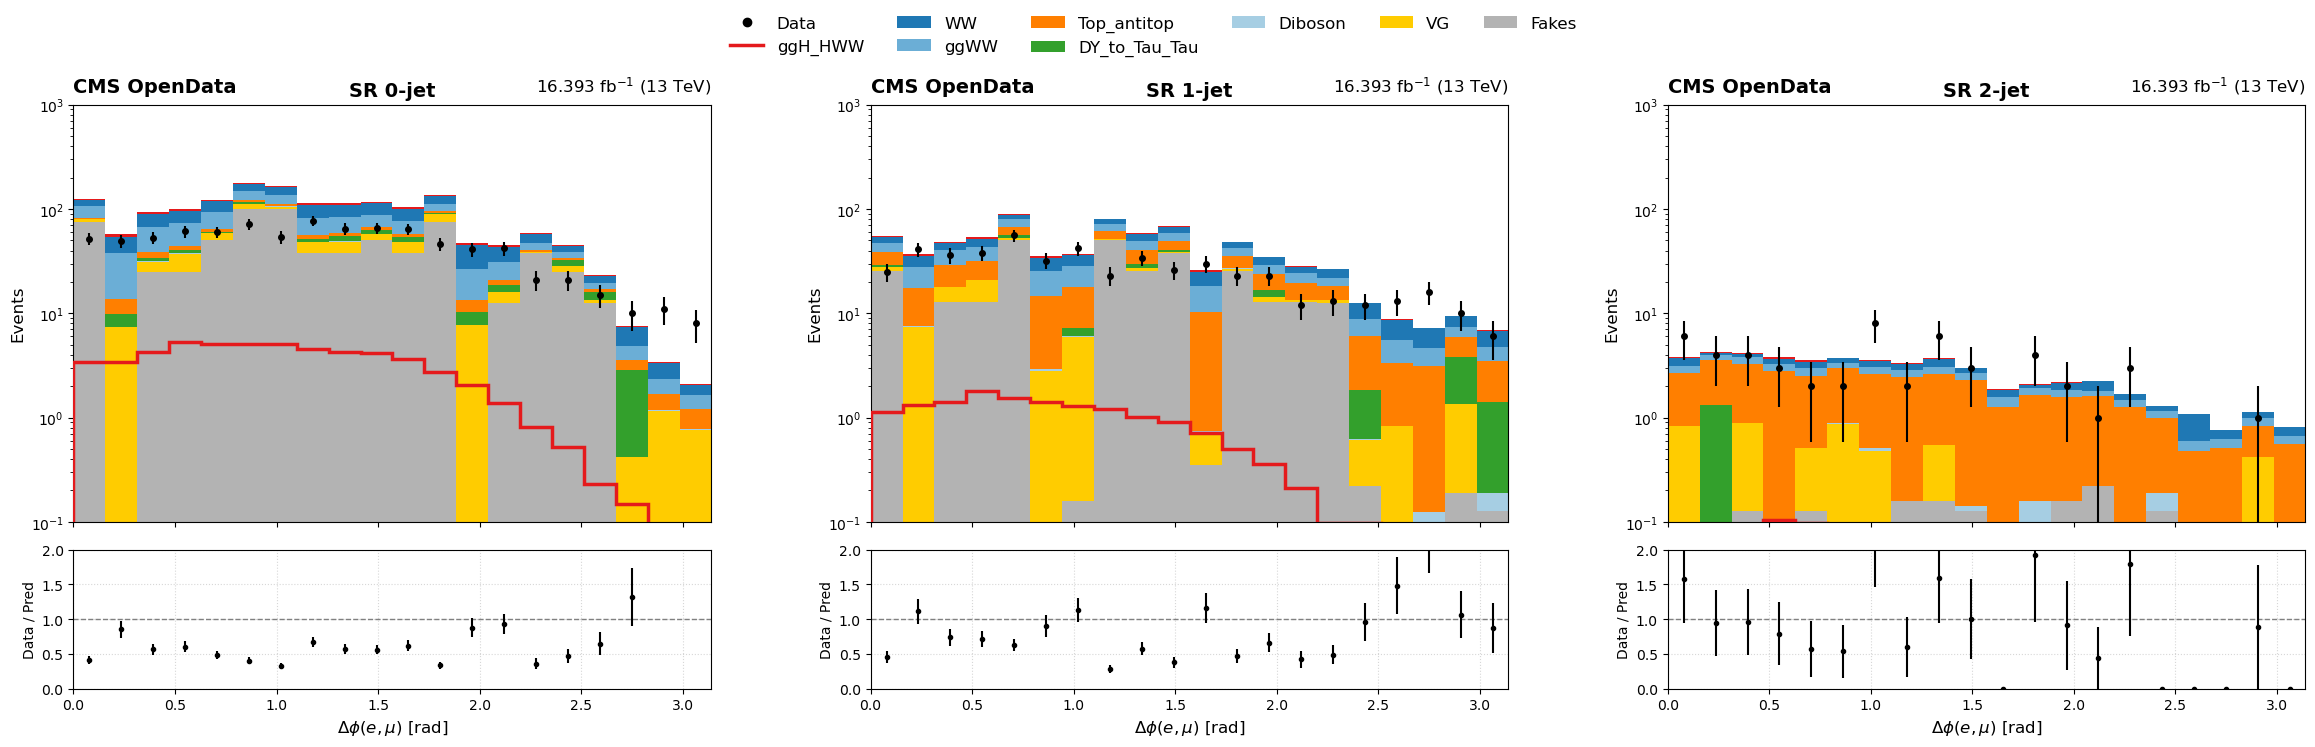

Processing Group: Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/stacked/dphi_Control_Region_Top.png


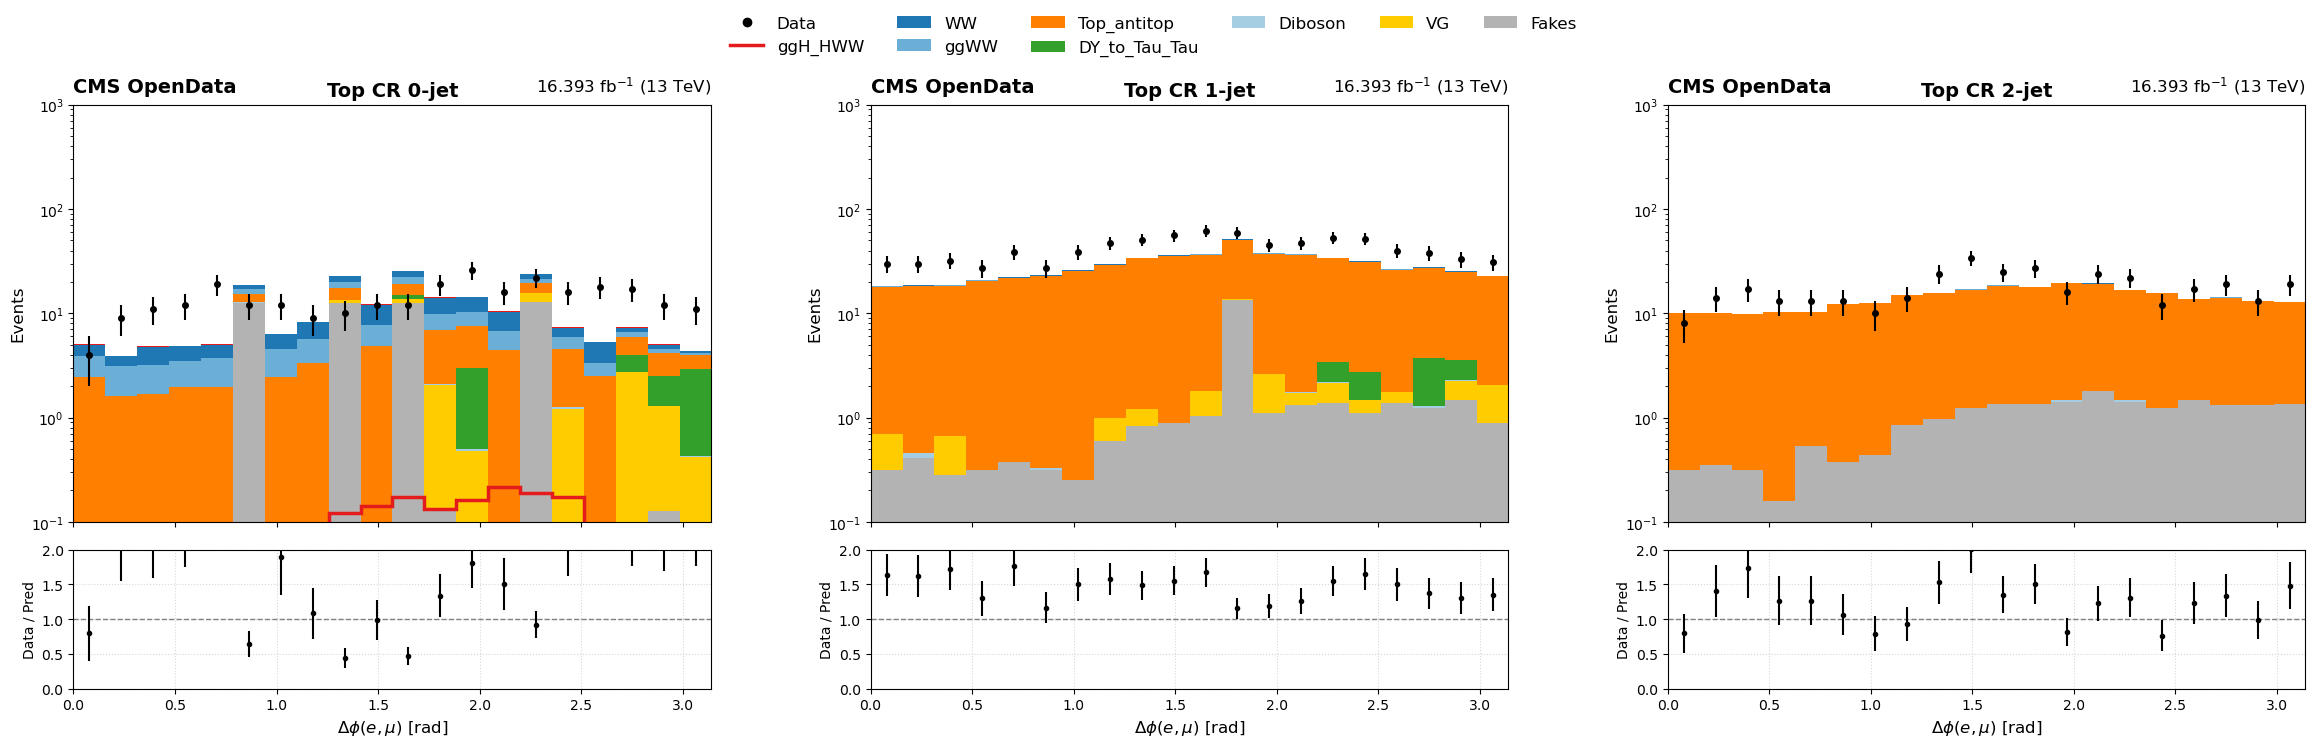

Processing Group: Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/stacked/dphi_Control_Region_Tau.png


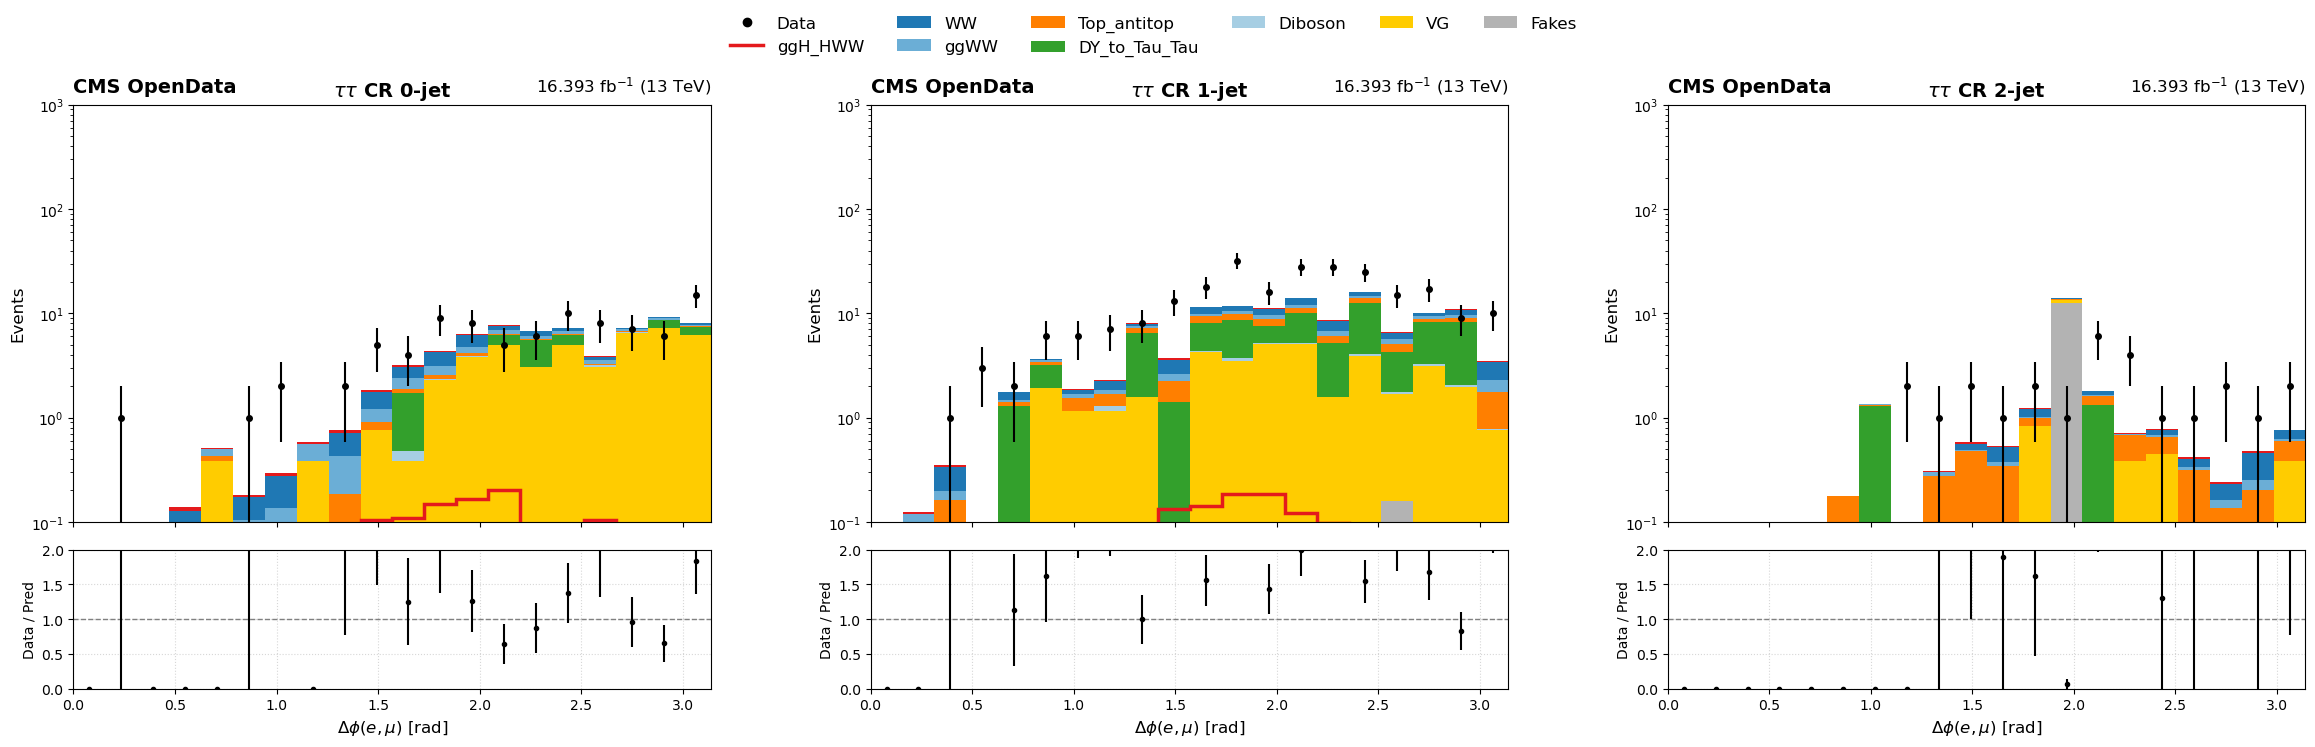


---> Processing mt_higgs...
Processing Group: Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/stacked/mt_higgs_Signal_Region.png


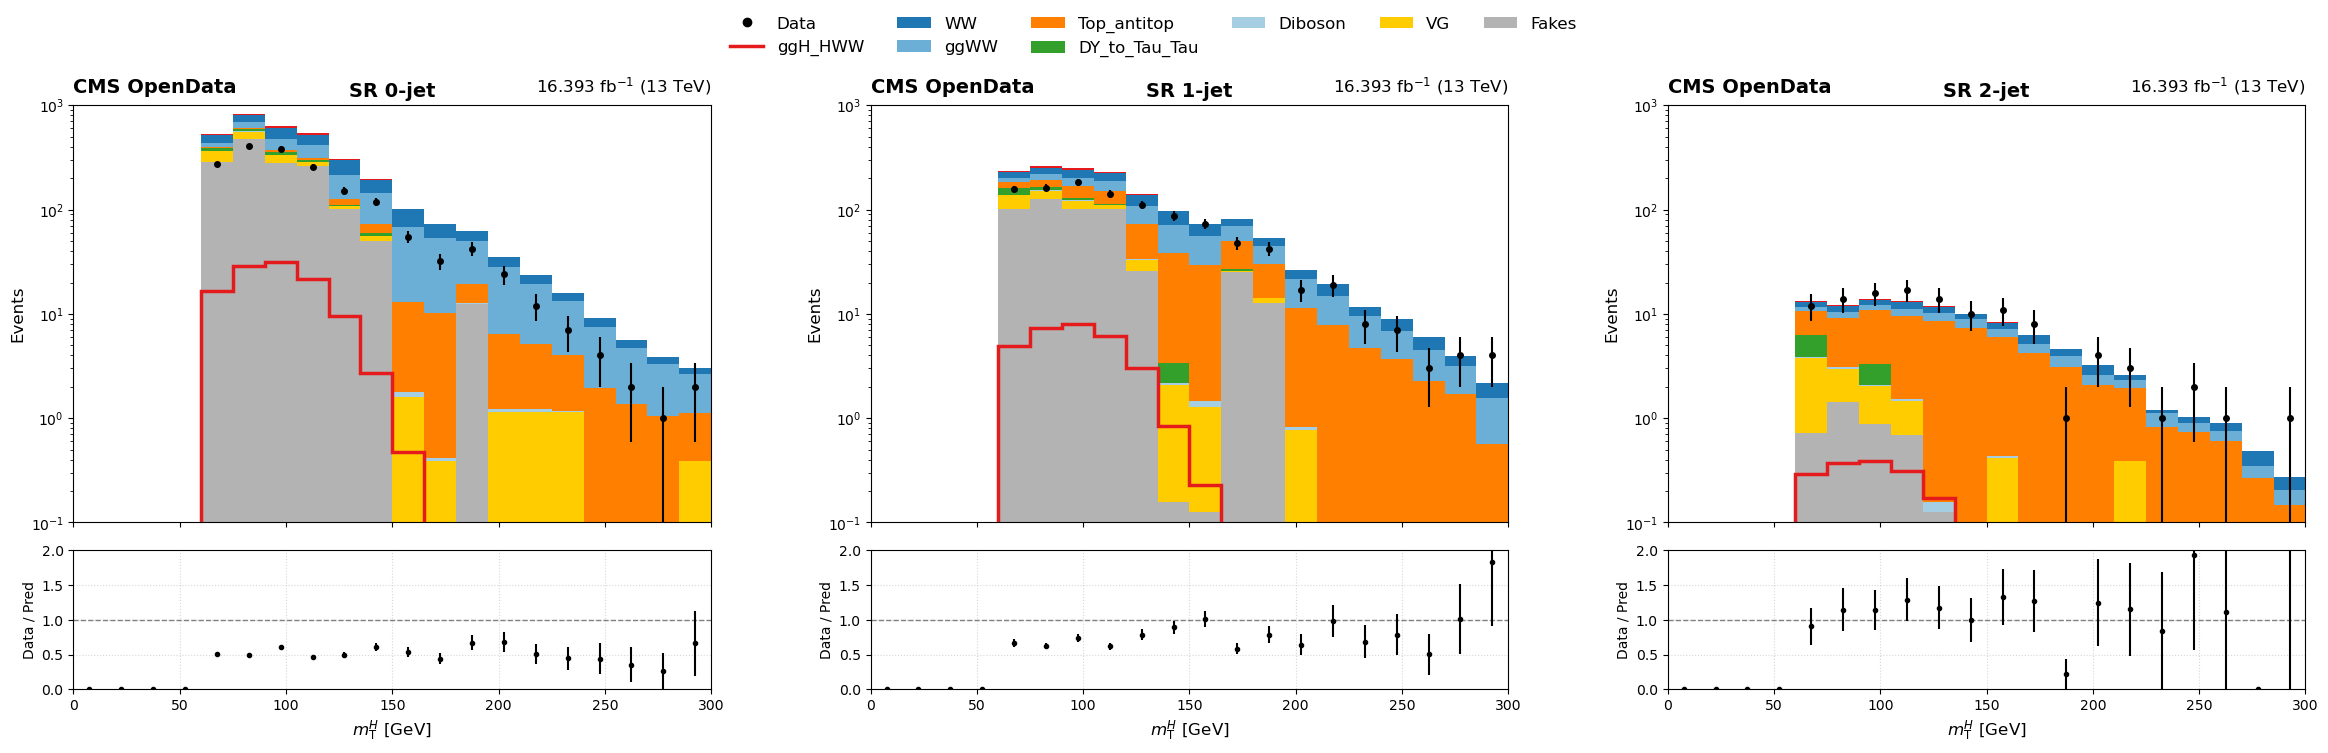

Processing Group: Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/stacked/mt_higgs_Control_Region_Top.png


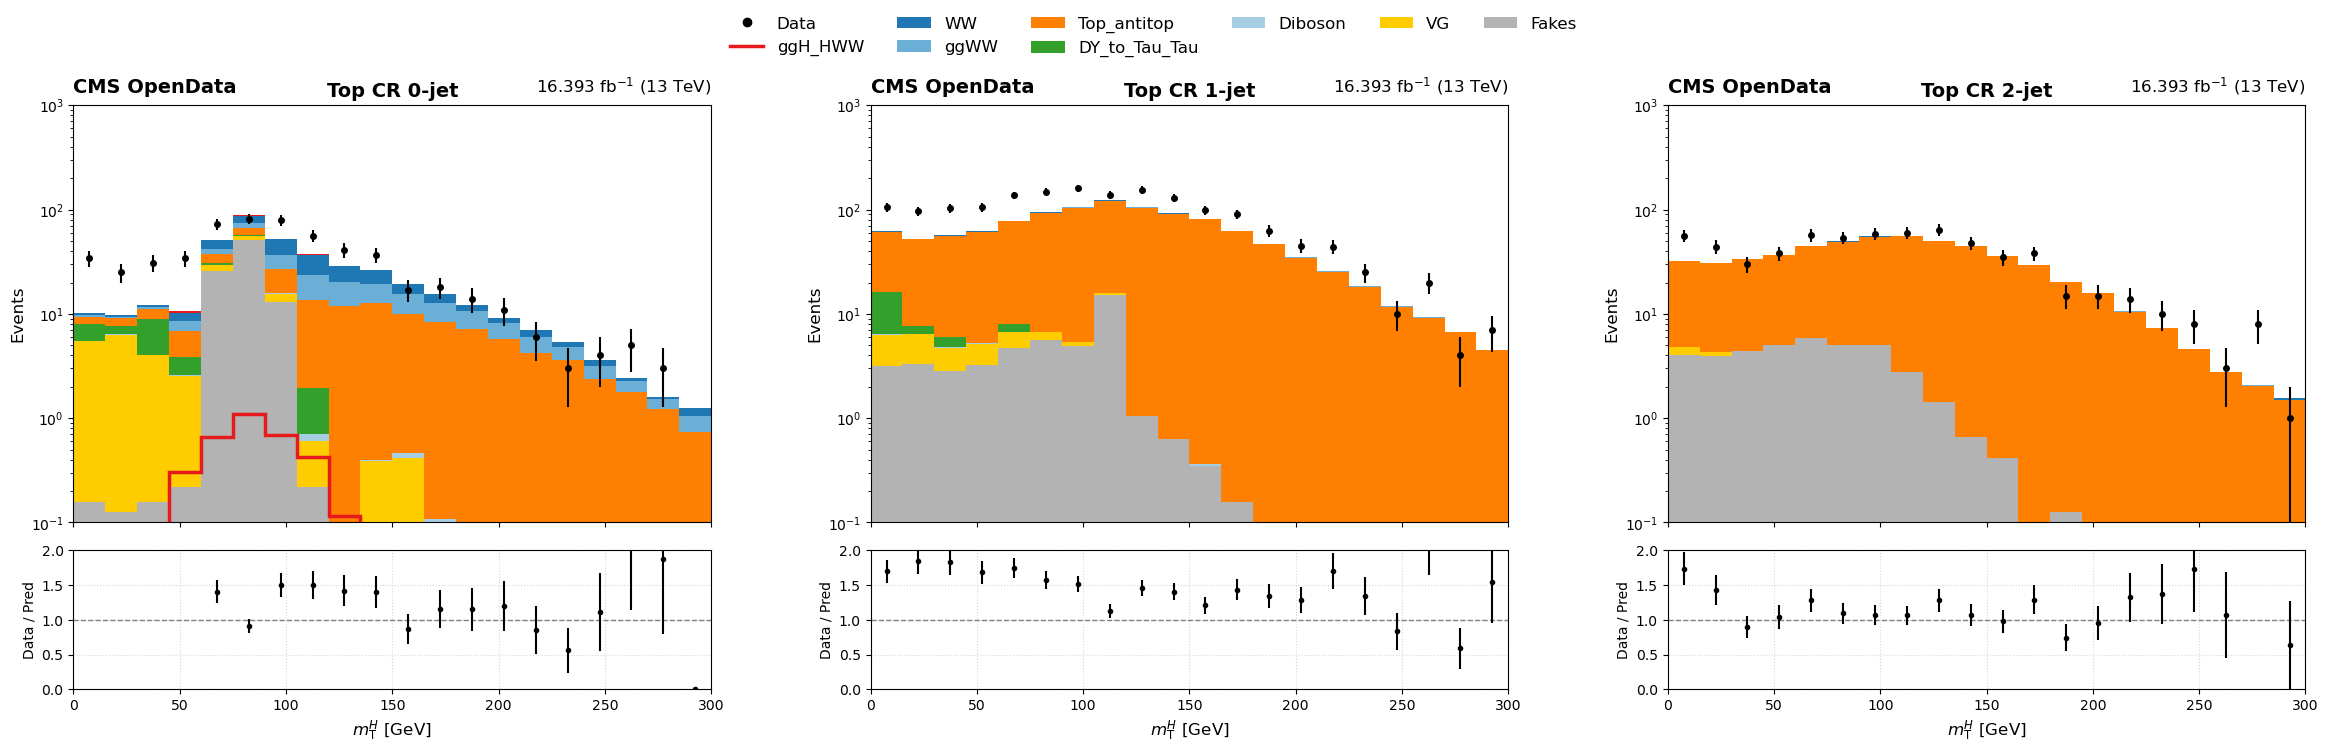

Processing Group: Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/stacked/mt_higgs_Control_Region_Tau.png


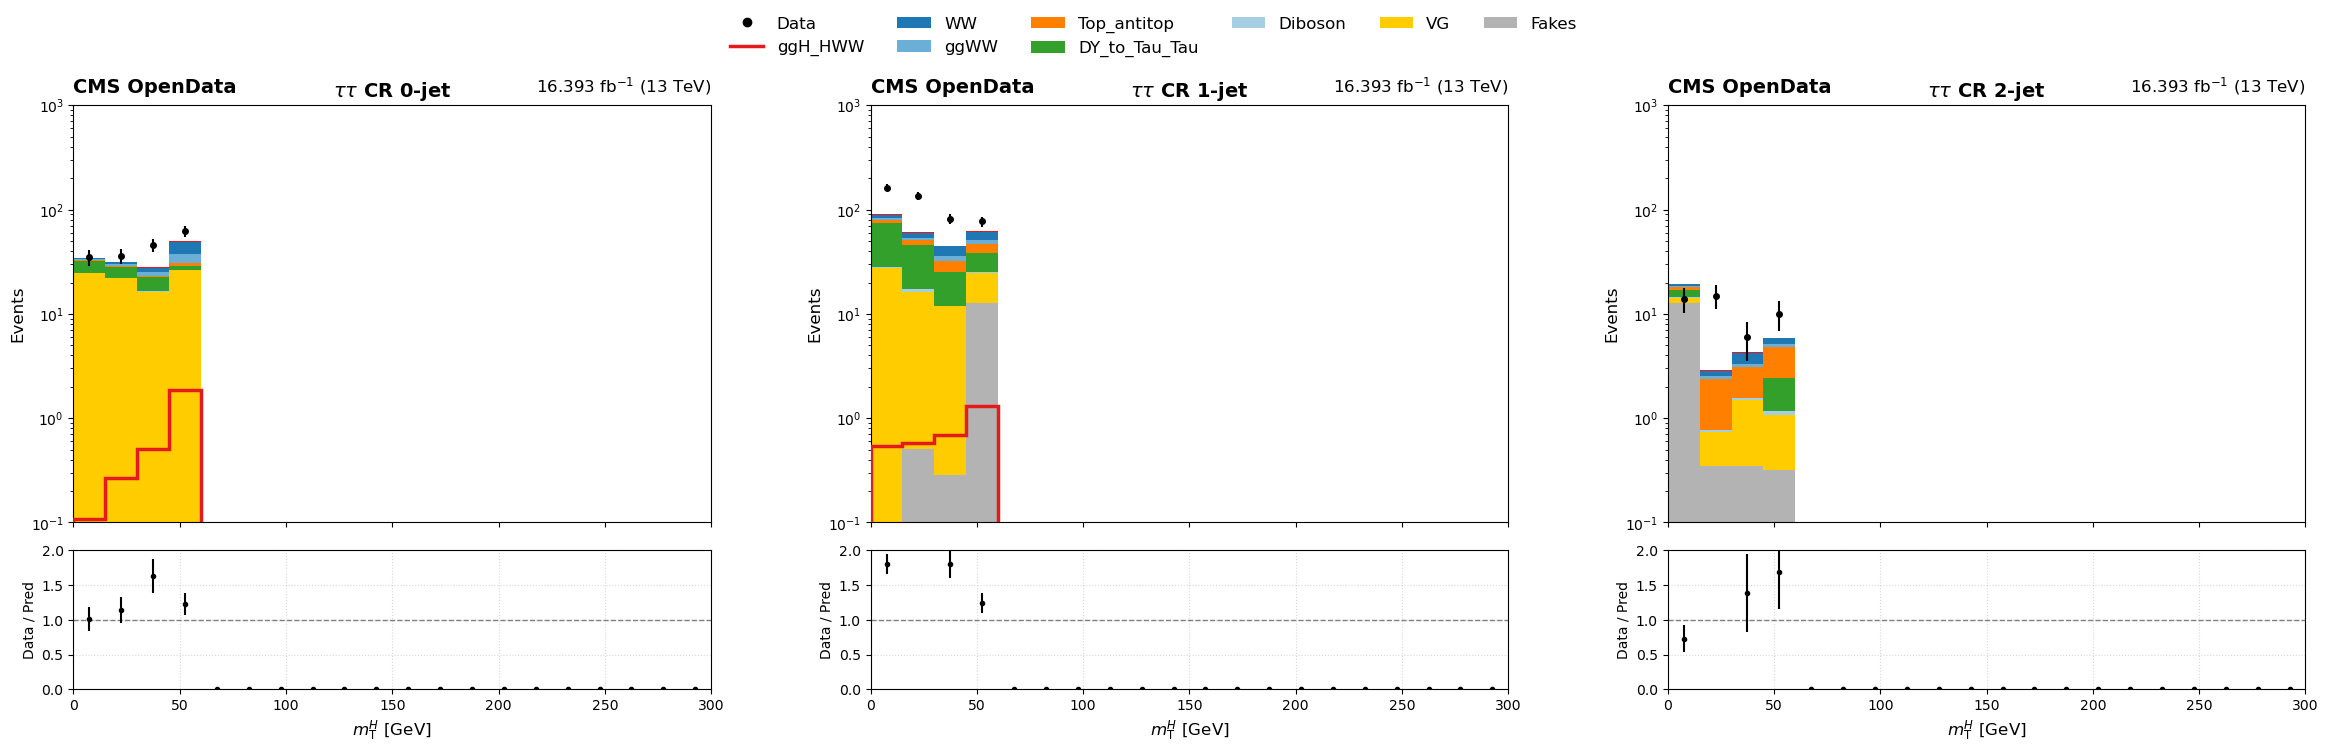


---> Processing mt_l2_met...
Processing Group: Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/stacked/mt_l2_met_Signal_Region.png


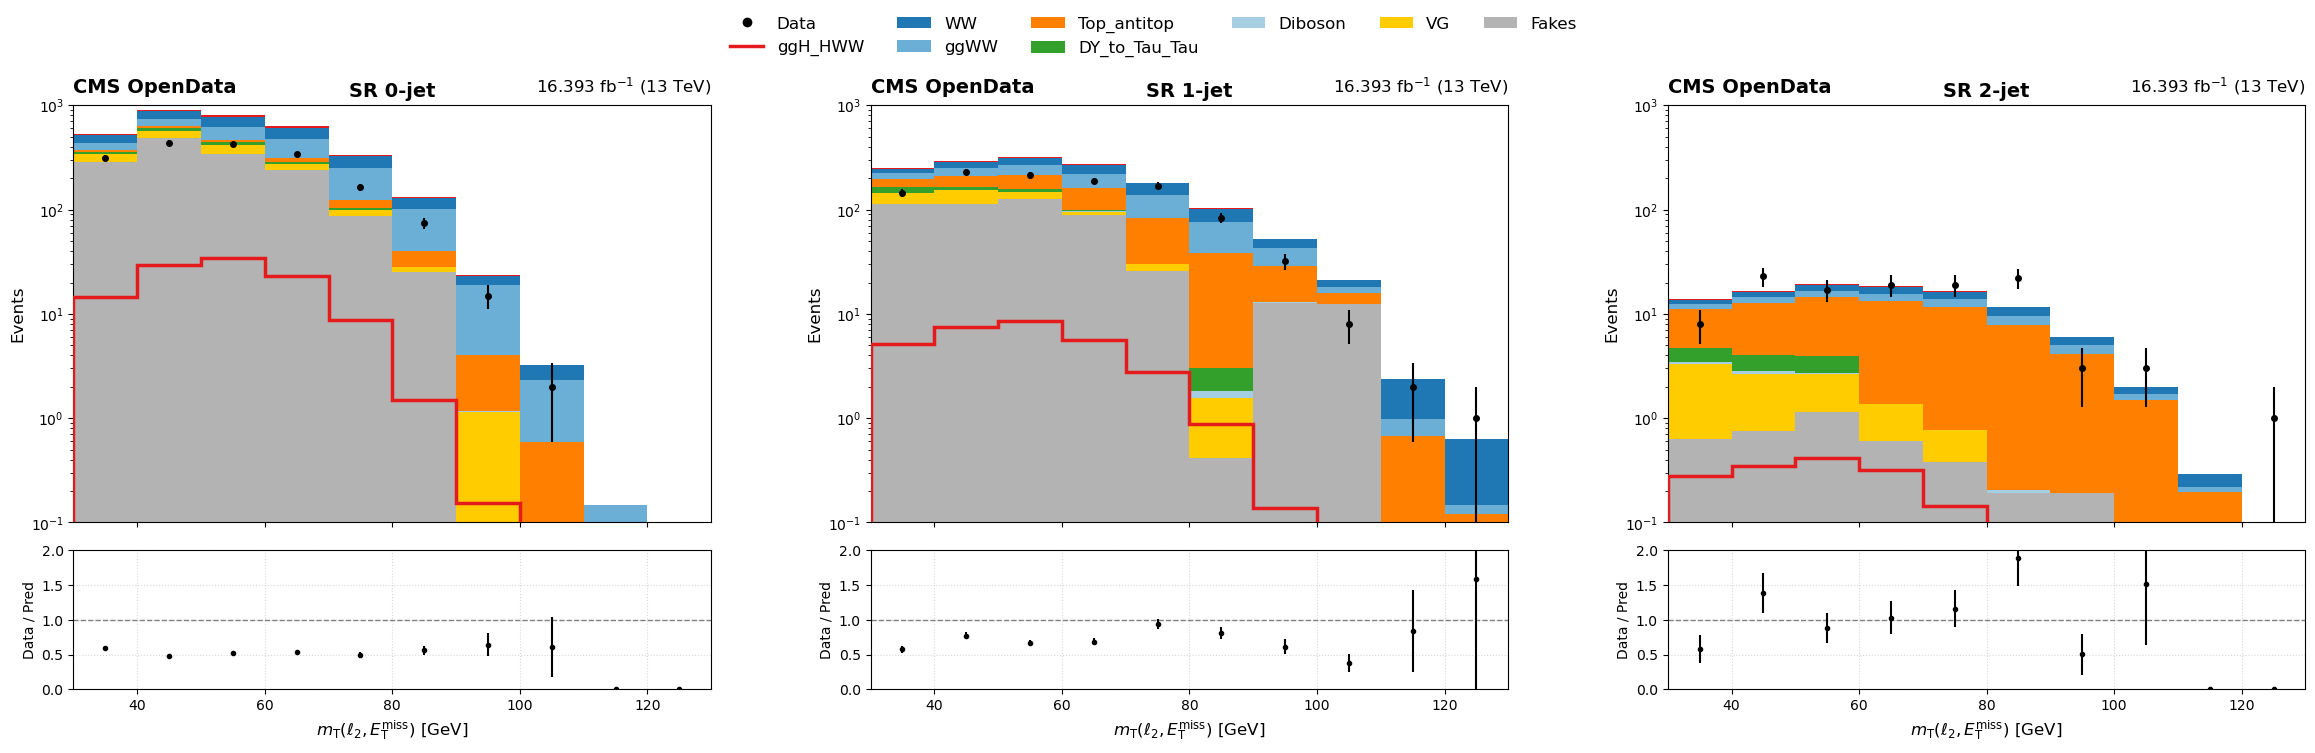

Processing Group: Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/stacked/mt_l2_met_Control_Region_Top.png


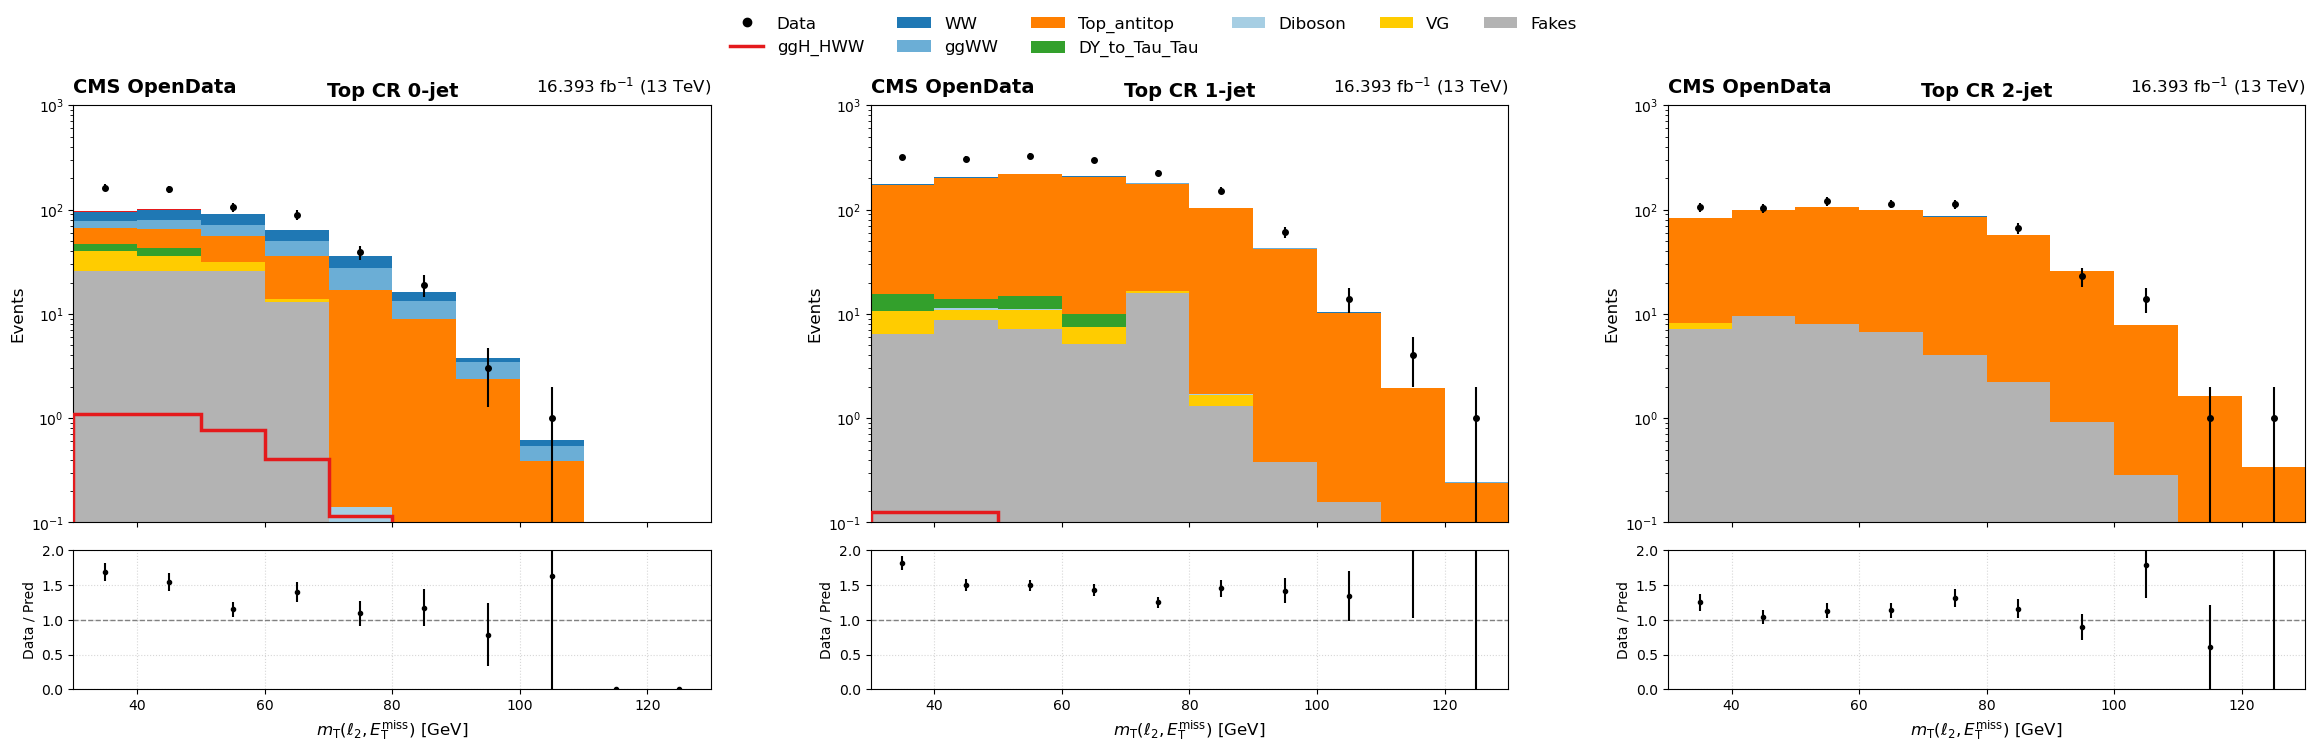

Processing Group: Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/stacked/mt_l2_met_Control_Region_Tau.png


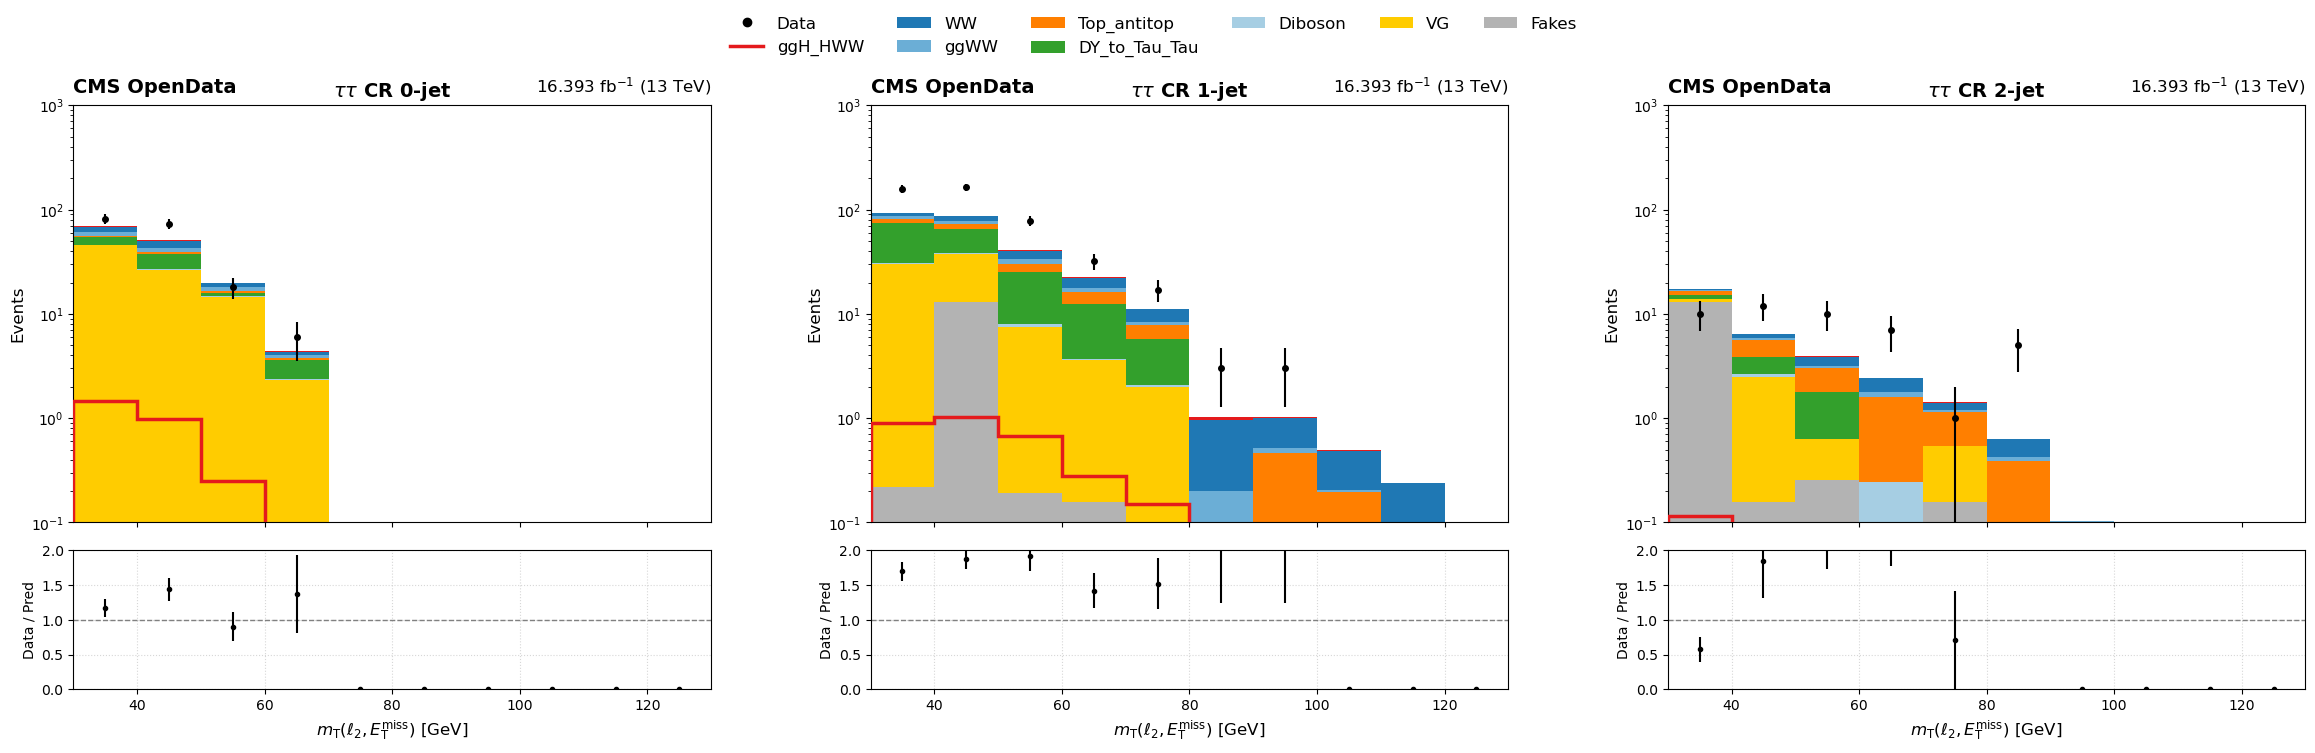


---> Processing mjj...
Processing Group: Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/stacked/mjj_Signal_Region.png


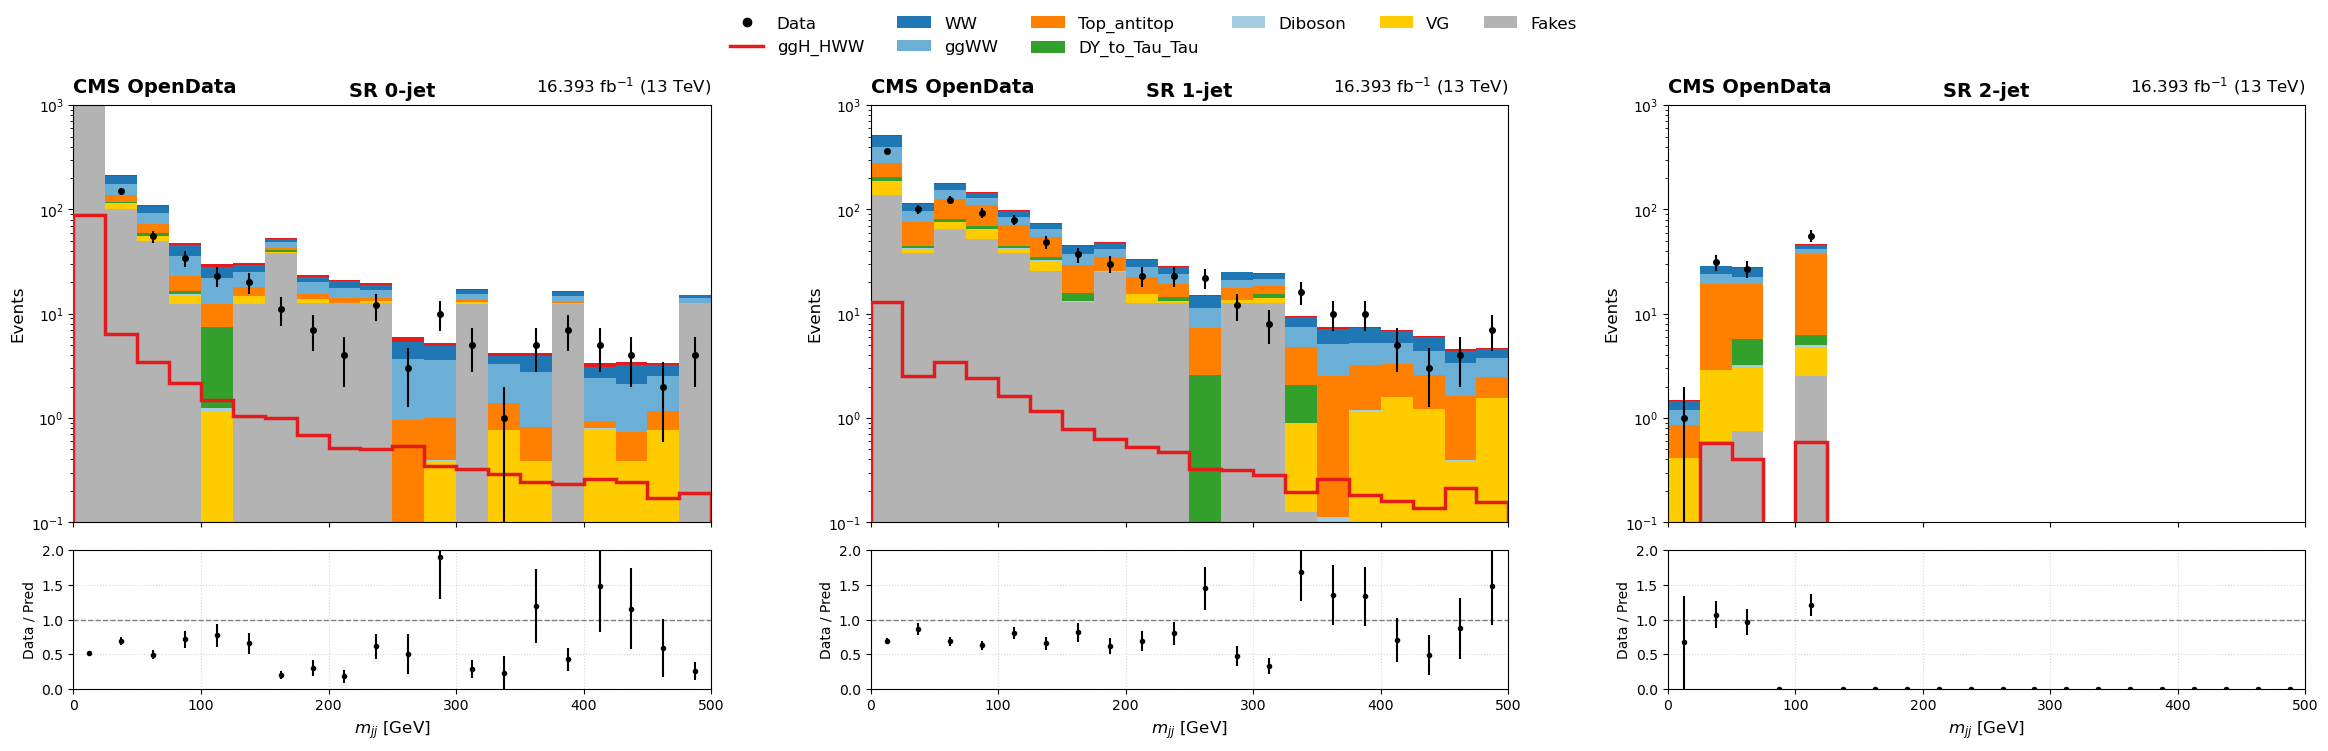

Processing Group: Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/stacked/mjj_Control_Region_Top.png


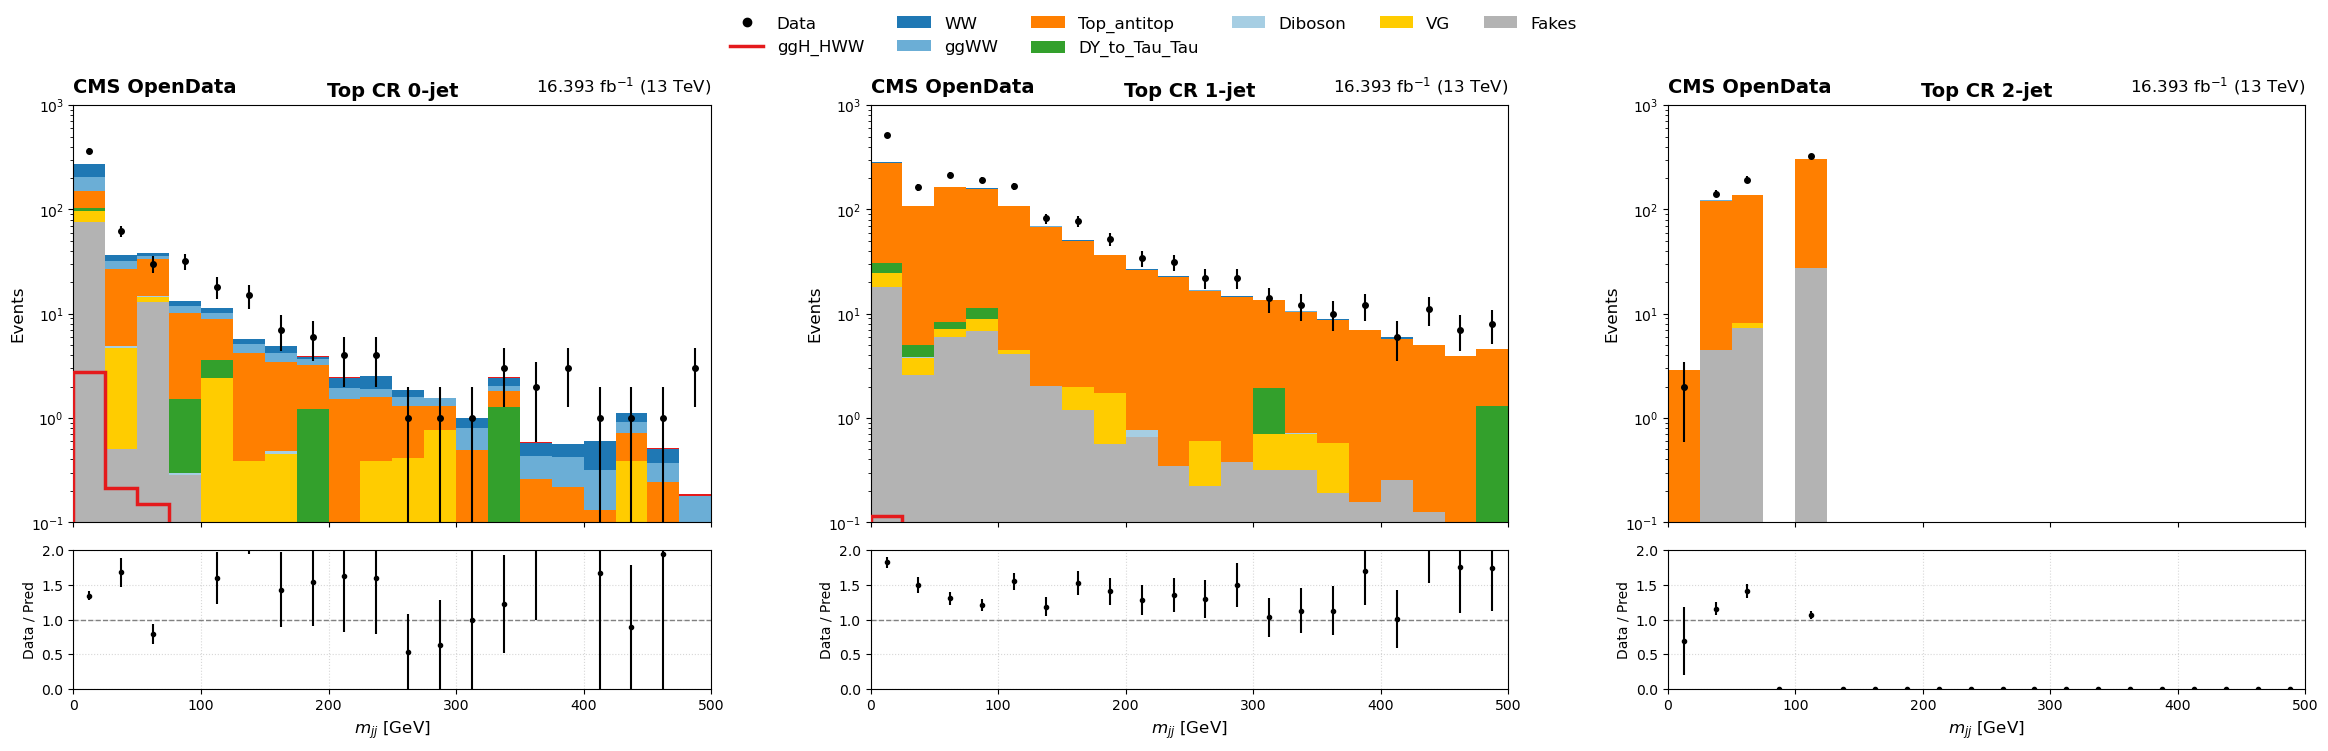

Processing Group: Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/stacked/mjj_Control_Region_Tau.png


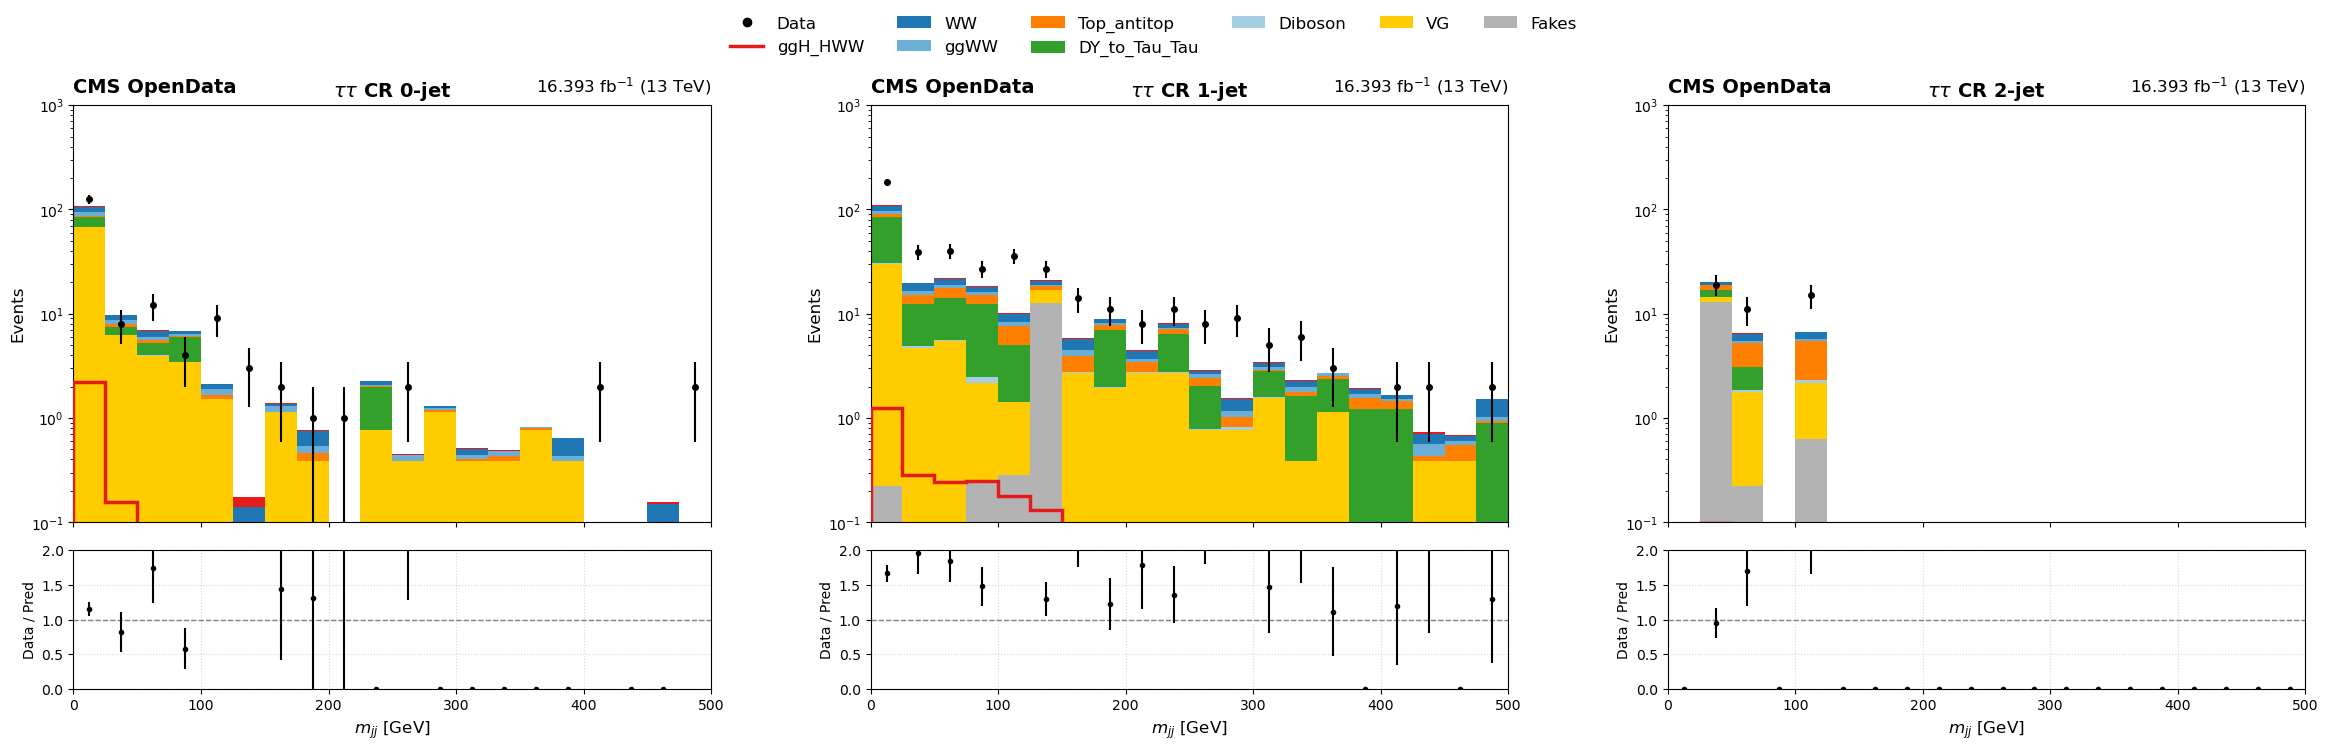


---> Processing leading_pt...
Processing Group: Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/stacked/leading_pt_Signal_Region.png


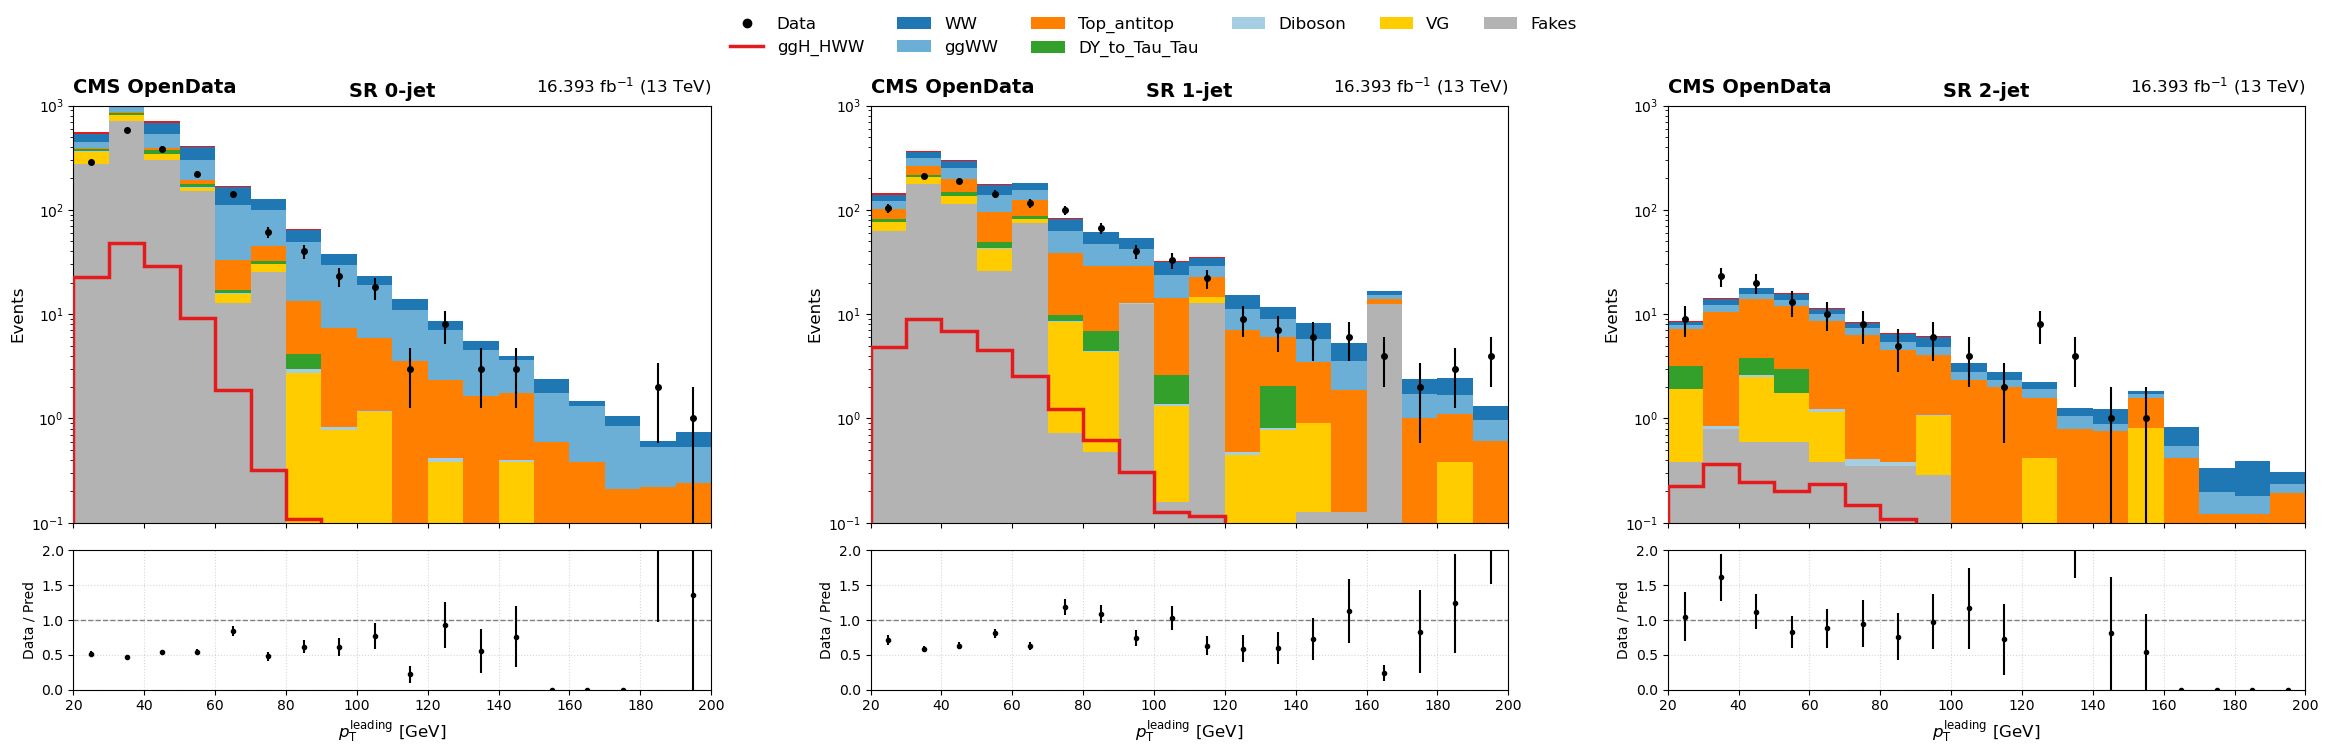

Processing Group: Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/stacked/leading_pt_Control_Region_Top.png


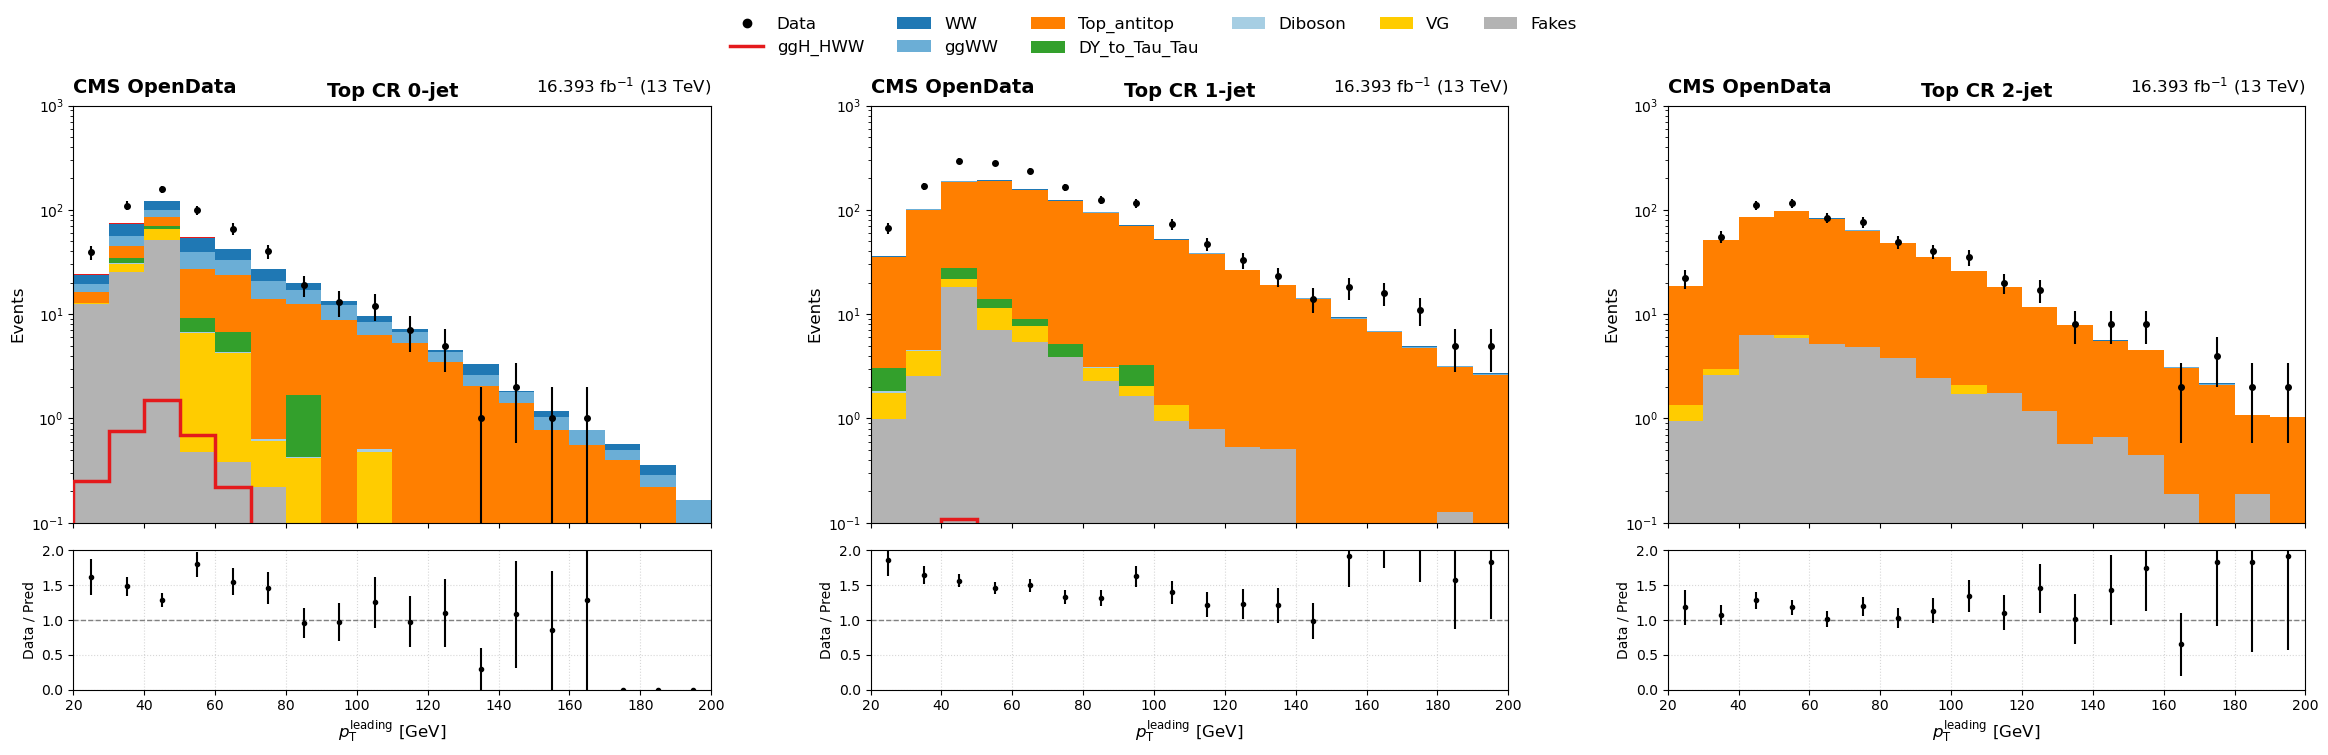

Processing Group: Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/stacked/leading_pt_Control_Region_Tau.png


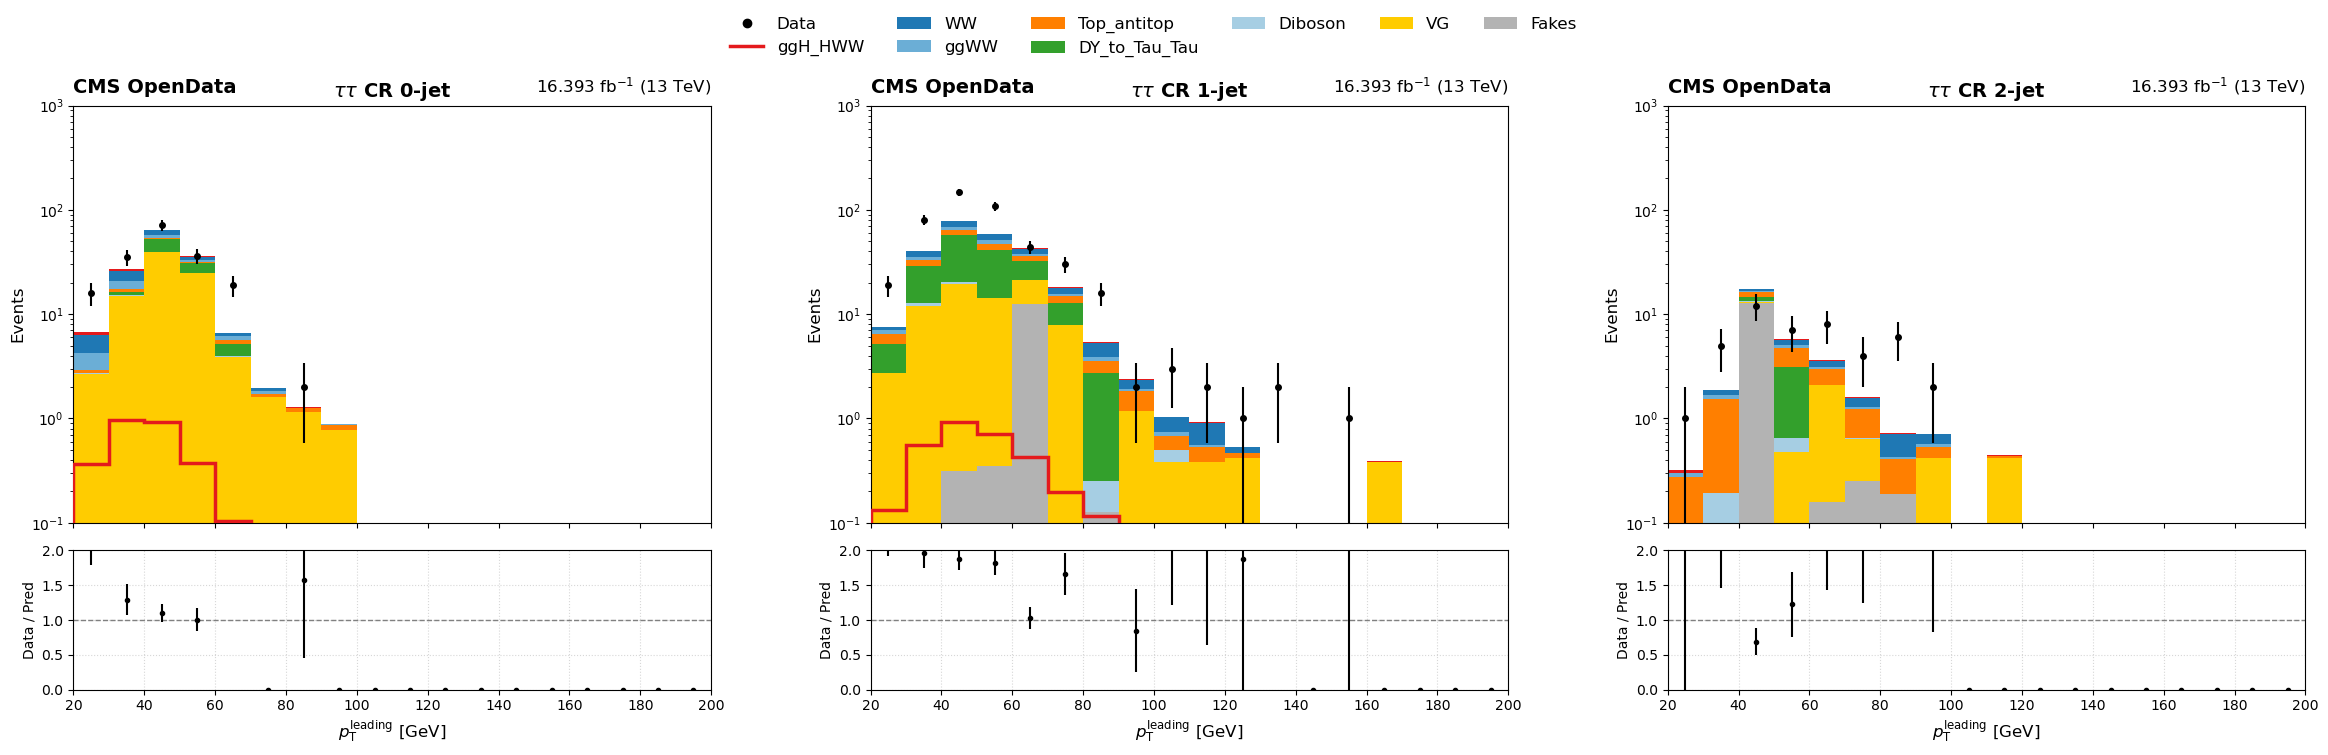


---> Processing subleading_pt...
Processing Group: Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/stacked/subleading_pt_Signal_Region.png


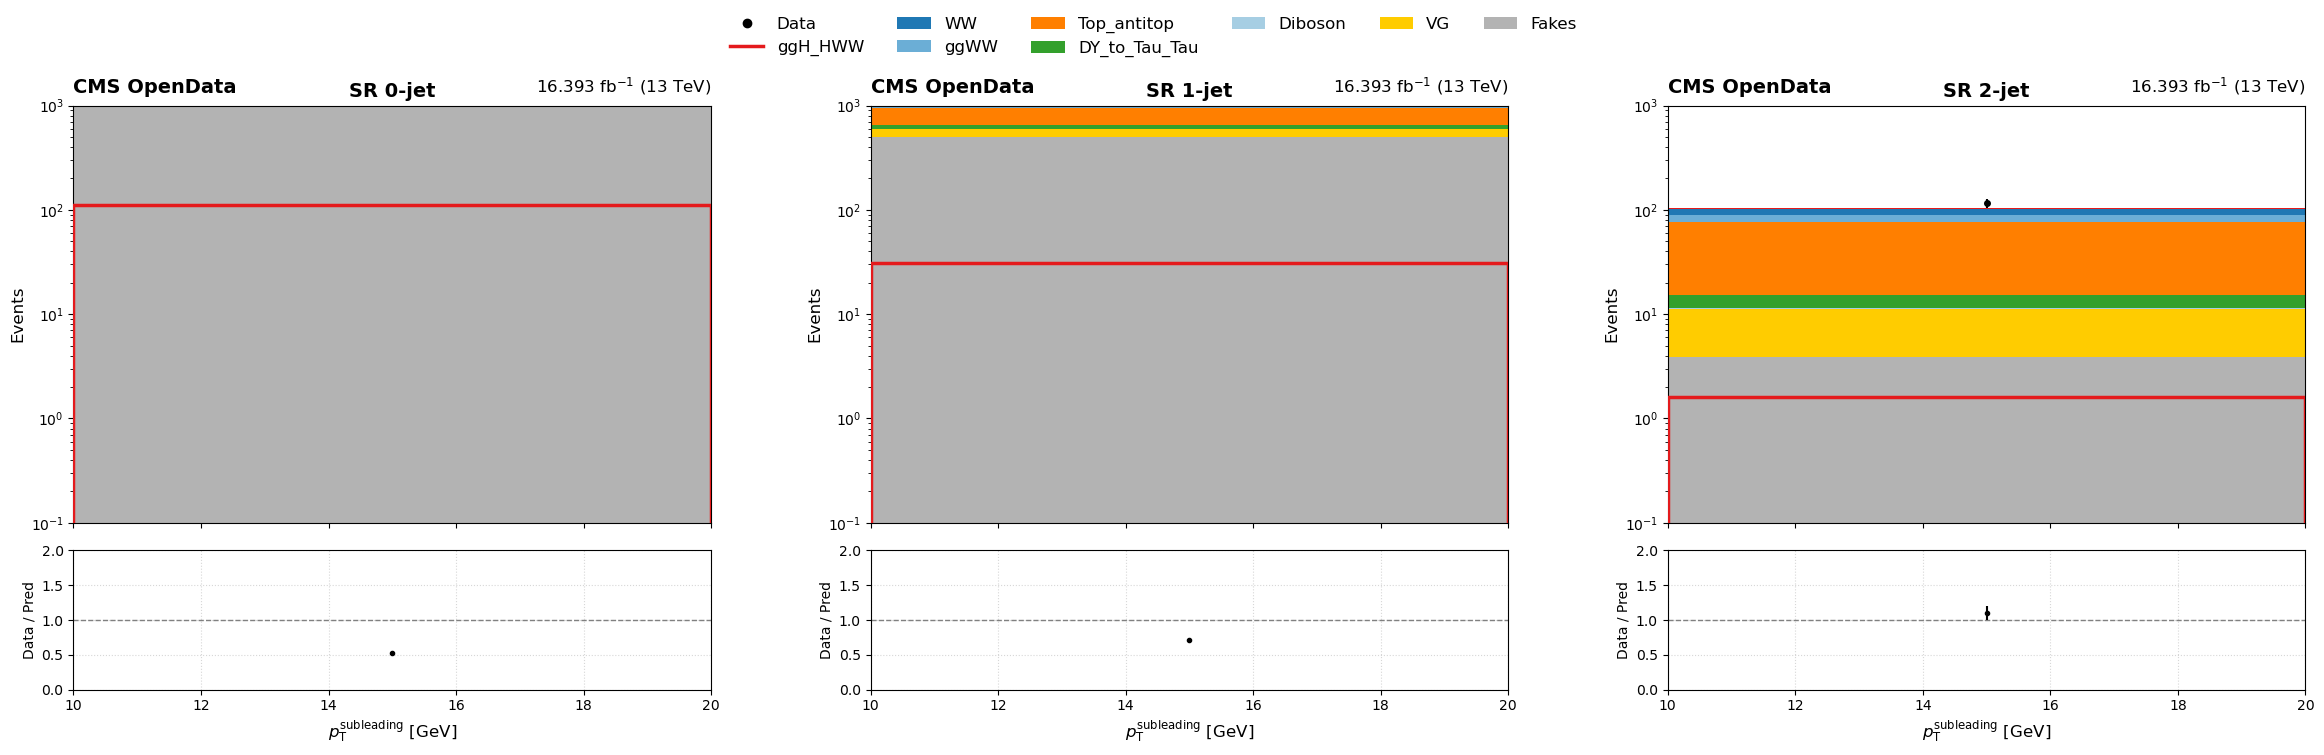

Processing Group: Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/stacked/subleading_pt_Control_Region_Top.png


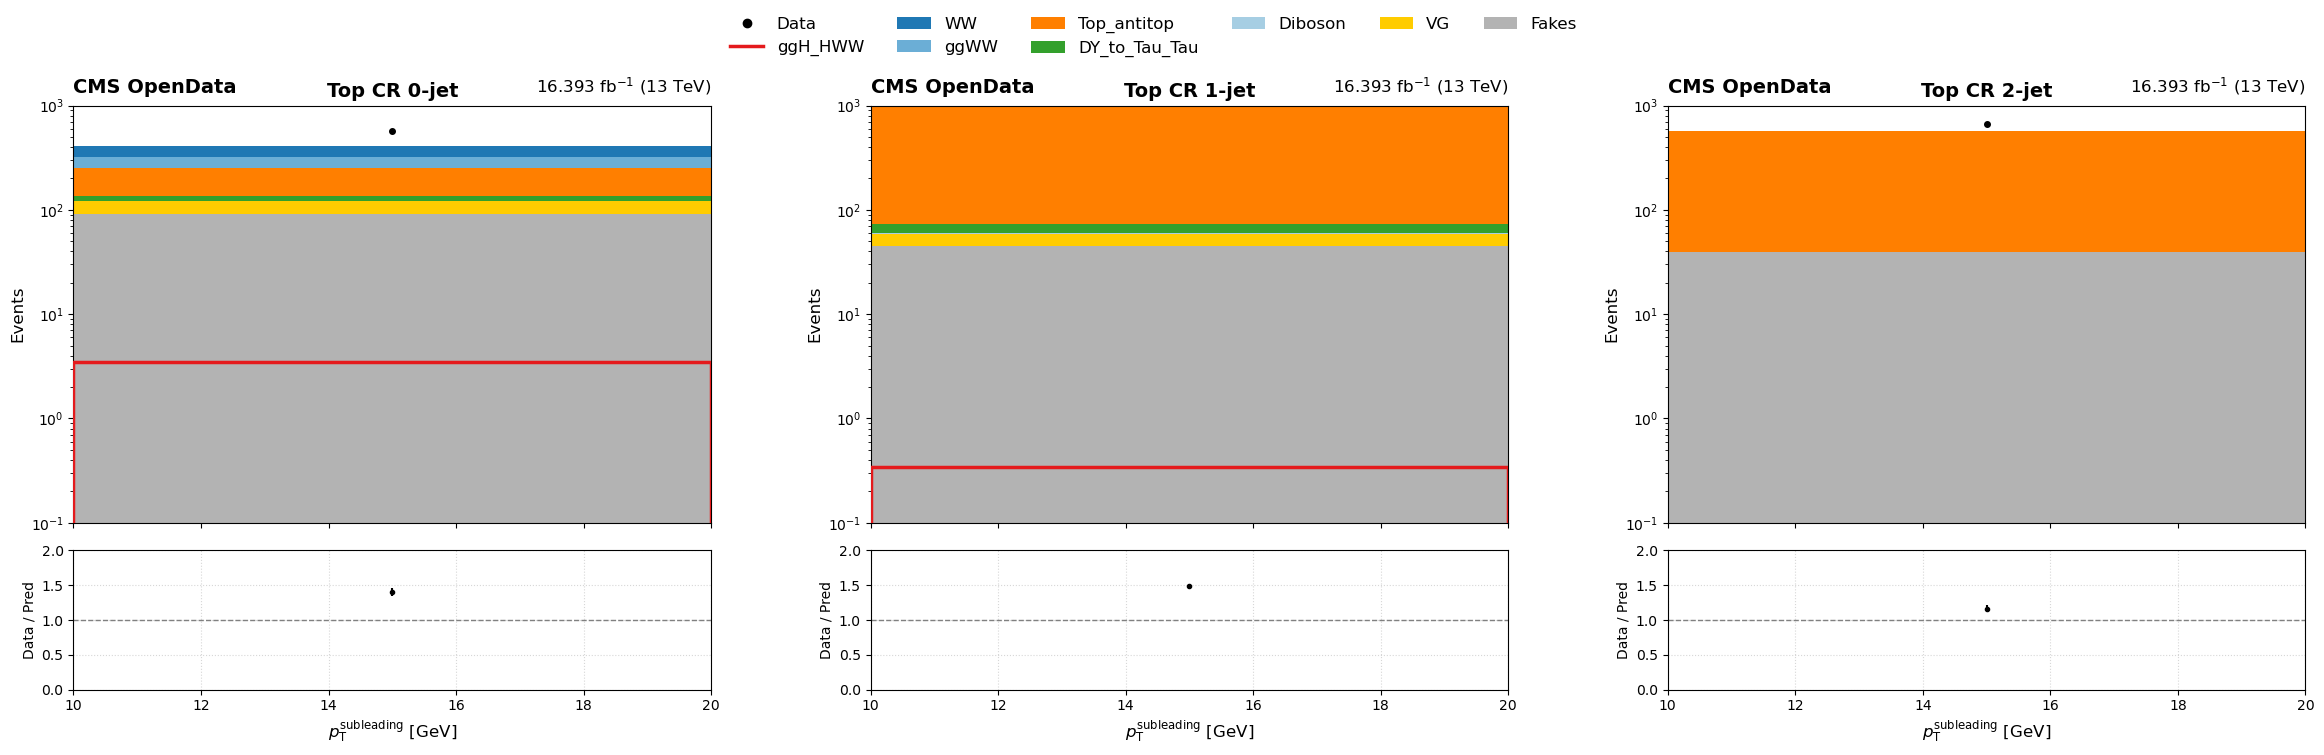

Processing Group: Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/stacked/subleading_pt_Control_Region_Tau.png


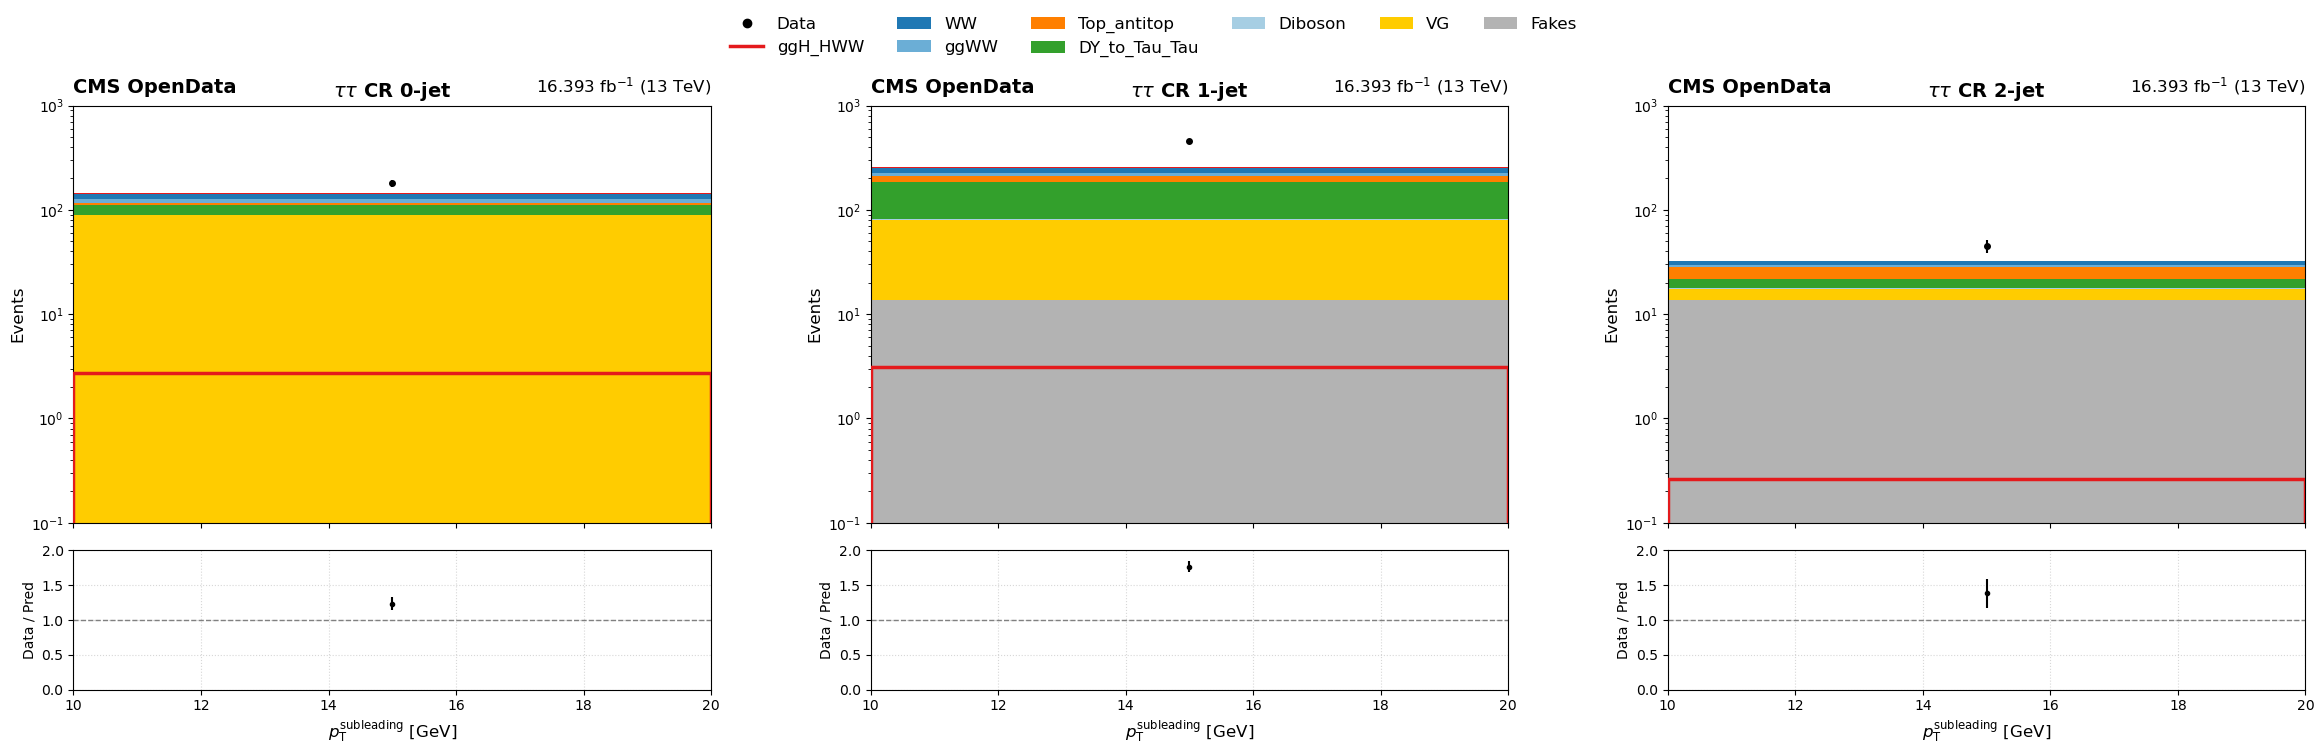


COMPLETE: 9 variables processed successfully, 0 failed



In [286]:
    
    VARIABLE_CONFIG = {
        'mass': {
            'xlabel': r'$m_{e\mu}$ [GeV]',
            'xlim':  (25, 200),
            'title': 'Invariant Mass Distribution',
        },
        'met': {
            'xlabel': r'$E_{\mathrm{T}}^{\mathrm{miss}}$ [GeV]',
            'xlim': (25, 150),
            'title': 'Missing Transverse Energy Distribution',
        },
        'ptll': {
            'xlabel': r'$p_{\mathrm{T}}^{\ell\ell}$ [GeV]',
            'xlim': (30, 200),
            'title': 'Dilepton Transverse Momentum Distribution',
        },
        'dphi':  {
            'xlabel': r'$\Delta\phi(e,\mu)$ [rad]',
            'xlim': (0, 3.14),
            'title': 'Azimuthal Angle Difference Distribution',
        },
        'mt_higgs': {
            'xlabel': r'$m_{\mathrm{T}}^{H}$ [GeV]',
            'xlim': (0, 300),
            'title': 'Higgs Transverse Mass Distribution',
        },
        'mt_l2_met':  {
            'xlabel': r'$m_{\mathrm{T}}(\ell_2, E_{\mathrm{T}}^{\mathrm{miss}})$ [GeV]',
            'xlim': (30, 130),
            'title': 'Subleading Lepton-MET Transverse Mass Distribution',
        },
        'mjj': {
            'xlabel': r'$m_{jj}$ [GeV]',
            'xlim': (0, 500),
            'title': 'Dijet Invariant Mass Distribution',
        },
        'leading_pt': {
            'xlabel': r'$p_{\mathrm{T}}^{\mathrm{leading}}$ [GeV]',
            'xlim': (20, 200),
            'title': 'Leading Lepton Transverse Momentum Distribution',
        },
        'subleading_pt':  {
            'xlabel': r'$p_{\mathrm{T}}^{\mathrm{subleading}}$ [GeV]',
            'xlim':  (10, 20),
            'title': 'Subleading Lepton Transverse Momentum Distribution',
        },
    }
    
    DEFAULT_PROPS = {
        'use_log_scale': True,
        'plot_data_in_SR': True
    }
    
    
    
    def plot_distribution(variable, hist_data_all, config=VARIABLE_CONFIG, defaults=DEFAULT_PROPS, output_dir="plots"):
        if variable not in config:
            raise ValueError(f"Unknown variable '{variable}'. Available: {list(config.keys())}")
        
        var_props = {**defaults, **config[variable]}
        
        stacked_plots(variable, var_props, hist_data_all, output_dir=output_dir)
    
    
    def plot_all_distributions(hist_data_all, variables=None, config=VARIABLE_CONFIG, output_dir="plots"):
        
        if variables is None: 
            variables = list(config.keys())
        
        print("\n" + "=" * 80)
        print("GENERATING DISTRIBUTION PLOTS ")
        print("=" * 80)
        print(f"Variables: {', '.join(variables)}")
        print(f"Output Directory: {output_dir}")
        print("-" * 80)
        
        successful = 0
        failed = 0
        
        for var_name in variables:
            print(f"\n---> Processing {var_name}...")
            
            try:
                plot_distribution(var_name, hist_data_all, config, output_dir=output_dir)
                successful += 1
                
            except Exception as e:
                print(f"     [ERROR] Failed to plot {var_name}: {e}")
                import traceback
                traceback.print_exc()
                failed += 1
        
        print("\n" + "=" * 80)
        print(f"COMPLETE: {successful} variables processed successfully, {failed} failed")
        print("=" * 80 + "\n")
    
    
    
    """
        EXECUTION
        Run the plotting loop
    """
    plot_all_distributions(hist_data_final, output_dir=OUTPUT_DIR)